In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# 1. Paramètres de Référence pour Générer X_obs et Y_obs
theta_ref = {
    "F": 10.0,  # Forçage externe
    "h": 1.0,   # Couplage grandes/petites échelles
    "b": 9.5,   # Échelle temporelle des petites échelles
    "c": 10.0   # Intensité des interactions petites échelles
}

<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



1. **`lorenz96_two_equations`** génère des données observées ($X_{\text{obs}}, Y_{\text{obs}}$) en utilisant des paramètres de référence ($\theta_{\text{ref}}$).
2. **`calculate_metrics`** extrait des statistiques résumées ($S(X, Y)$) des données observées pour définir une référence.
3. **`smc_abc`** compare les statistiques des simulations avec celles des observations ($S(X, Y)$) pour estimer les paramètres correspondant à la distribution a posteriori.

### **`lorenz96_two_equations`**
#### Utilité :
Simule les données pour le modèle de Lorenz-96 (grandes échelles $X_k$ et petites échelles $Y_{j,k}$) en utilisant les paramètres fournis.

#### Paramètres :
- **`F`** : *(float)* Forçage externe, contrôle l'injection d'énergie dans les grandes échelles.
- **`h`** : *(float)* Couplage entre les grandes et petites échelles.
- **`b`** : *(float)* Échelle temporelle des petites échelles (vitesse de dissipation).
- **`c`** : *(float)* Intensité des interactions chaotiques entre les petites échelles.
- **`T`** : *(float)* Durée totale de simulation, indique combien de temps on souhaite simuler le système.
- **`dt`** : *(float)* Pas de temps, contrôle la précision de l'intégration numérique (Euler explicite).
- **`K`** : *(int, par défaut 36)* Nombre de grandes échelles ($X_k$).
- **`J`** : *(int, par défaut 10)* Nombre de petites échelles ($Y_{j,k}$) par grande échelle.

#### Sortie

- **`theta_ref`** : Dictionnaire contenant les paramètres de référence ($F, h, b, c$).
- **Sortie** :
  - `X_obs` : Trajectoire des grandes échelles au cours du temps ($T \times K$).
  - `Y_obs` : Trajectoire des petites échelles au cours du temps ($T \times K \times J$).

In [2]:

# 2. Modèle Lorenz-96 avec Deux Équations
def lorenz96_two_equations(F, h, b, c, T=10, dt=0.01, K=36, J=10):
    X = np.random.rand(K)
    Y = np.random.rand(K, J)
    n_steps = int(T / dt)
    for _ in range(n_steps):
        coupling_term = h * np.mean(Y, axis=1)
        dX = (
            -np.roll(X, -1) * (np.roll(X, 1) - np.roll(X, -2))
            - X
            + F
            - coupling_term
        )
        dY = (
            -c * np.roll(Y, -1, axis=1) * (np.roll(Y, 1, axis=1) - np.roll(Y, -2, axis=1))
            - b * Y
            + h * X[:, None]
        )
        X += dX * dt
        Y += dY * dt
    return X, Y



Ajouter du bruit à $X_{\text{obs}}$ et $Y_{\text{obs}}$ permet de mieux refléter les incertitudes des données réelles et de tester la robustesse de l'algorithme. Cela aide à éviter un rejet excessif des simulations en introduisant une tolérance réaliste. Par exemple, on peut ajouter un bruit gaussien $\mathcal{N}(0, \sigma^2)$, où $\sigma$ représente l'incertitude de mesure.

In [3]:
import numpy as np


def add_noise(X_obs, Y_obs, noise_level_X=0.1, noise_level_Y=0.1):
    """
    Ajoute un bruit gaussien à X_obs et Y_obs.

    Paramètres :
    -----------
    X_obs : ndarray
        Données des grandes échelles.
    Y_obs : ndarray
        Données des petites échelles.
    noise_level_X : float
        Écart-type du bruit pour X_obs.
    noise_level_Y : float
        Écart-type du bruit pour Y_obs.

    Retourne :
    ---------
    tuple(ndarray, ndarray) :
        X_obs et Y_obs avec bruit ajouté.
    """
    X_obs_noisy = X_obs + np.random.normal(0, noise_level_X, size=X_obs.shape)
    Y_obs_noisy = Y_obs + np.random.normal(0, noise_level_Y, size=Y_obs.shape)
    return X_obs_noisy, Y_obs_noisy





### **`calculate_metrics`**
#### Utilité :
Calcule des statistiques résumées ($S(X, Y)$) pour les données observées $X_{\text{obs}}$ et $Y_{\text{obs}}$. Ces métriques sont utilisées comme référence pour comparer les données simulées.

#### Paramètres :
- **`X`** : *(ndarray)* Données simulées des grandes échelles ($T \times K$).
- **`Y`** : *(ndarray)* Données simulées des petites échelles ($T \times K \times J$).
- **`tau`** : *(float)* Période sur laquelle les moyennes temporelles sont calculées.

#### Sortie :
  - **`X_mean`** : Moyenne temporelle de $X_k$.
  - **`Y_mean`** : Moyenne temporelle de $Y_{j,k}$.
  - **`X_squared`** : Carrés moyens de $X_k$.
  - **`Y_squared`** : Carrés moyens de $Y_{j,k}$.
  - **`XY_interaction`** : Interaction entre $X_k$ et la moyenne de $Y_{j,k}$.




In [4]:

# 3. Calcul des Métriques
def calculate_metrics(X, Y, tau):
    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    X_squared = np.mean(X**2)
    Y_squared = np.mean(Y**2)
    XY_interaction = np.mean(X * np.mean(Y, axis=1))
    return {
        "X_mean": X_mean,
        "Y_mean": Y_mean,
        "X_squared": X_squared,
        "Y_squared": Y_squared,
        "XY_interaction": XY_interaction
    }
    


In [6]:

# 4. Calcul de la Distance
def calculate_distance(metrics_sim, metrics_obs):
    sim_vector = np.array(list(metrics_sim.values()))
    obs_vector = np.array(list(metrics_obs.values()))
    return np.linalg.norm(sim_vector - obs_vector)

In [7]:
# 6. Paramètres et Exécution

priors = {
    "F": (9.5, 10.5),
    "h": (0.5, 1.5),
    "b": (9.0, 10.0),
    "c": (9.0, 11.0)
}




In [8]:

# Générer des données observées bruitées
X_obs, Y_obs = lorenz96_two_equations(**theta_ref, T=10, dt=0.01)
X_obs_noisy, Y_obs_noisy = add_noise(X_obs, Y_obs, noise_level_X=0.1, noise_level_Y=0.1)




In [9]:
# Calcul des métriques observées
metrics_obs = calculate_metrics(X_obs_noisy, Y_obs_noisy, tau=10)

### Methode 1:**`Algorithme ABC Rejection`**

In [10]:

def sample_prior(priors):
    return {key: np.random.uniform(low, high) for key, (low, high) in priors.items()}




def abc_rejection(priors, metrics_obs, n_simulations=1000, epsilon=0.5, T=10, dt=0.01):
    """
    Implémente l'ABC Rejection.
    
    Paramètres :
    -----------
    priors : dict
        Dictionnaire définissant les bornes des distributions a priori pour chaque paramètre.
    metrics_obs : dict
        Métriques calculées sur les données observées.
    n_simulations : int, optionnel
        Nombre total de simulations à effectuer (défaut : 1000).
    epsilon : float, optionnel
        Seuil de tolérance pour l'acceptation des paramètres (défaut : 0.5).
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).
    
    Retourne :
    ---------
    list of dict
        Liste des paramètres \(\theta\) acceptés.
    """
    accepted_thetas = []

    for i in range(n_simulations):
        # Étape (a) : Tirage d'un paramètre \theta* depuis la loi a priori
        # Tirage d'un paramètre \theta* depuis la loi a priori
        theta_i = sample_prior(priors)      

        # Étape (b) : Simulation des données
        X_sim_i, Y_sim_i = lorenz96_two_equations(**theta_i, T=T, dt=dt)

        # Étape (c) : Calcul des métriques simulées
        metrics_sim_i = calculate_metrics(X_sim_i, Y_sim_i, tau=T)

        # Étape (d) : Calcul de la distance
        distance_i = calculate_distance(metrics_sim_i, metrics_obs)

        # Étape (e) : Critère d'acceptation
        if distance_i <= epsilon:
            accepted_thetas.append(theta_i)

    return accepted_thetas




In [11]:

# Exécution de l'ABC Rejection
accepted_thetas_ABC_R = abc_rejection(priors, metrics_obs, n_simulations=1000, epsilon=0.5)

# 7. Résultats
print(f"Nombre de paramètres acceptés : {len(accepted_thetas_ABC_R)}")
for theta in accepted_thetas_ABC_R[:5]:  # Afficher les 5 premiers paramètres acceptés
    print(theta)





Nombre de paramètres acceptés : 20
{'F': 10.409088825250308, 'h': 1.153700696719095, 'b': 9.69145370338849, 'c': 9.479168527512334}
{'F': 10.2187382503537, 'h': 1.17530535843995, 'b': 9.594440307144833, 'c': 9.846988390133882}
{'F': 9.635012201819922, 'h': 1.0165962944588542, 'b': 9.156948854408732, 'c': 9.694653240559528}
{'F': 10.340382238671962, 'h': 0.9048954785149322, 'b': 9.32251398956004, 'c': 10.91437713586404}
{'F': 10.033315645034516, 'h': 1.0687261144454385, 'b': 9.308049743495918, 'c': 10.25630415931855}



### Contexte Général

Dans l'**Approximate Bayesian Computation (ABC)**, ces formules décrivent deux étapes fondamentales du processus d'inférence bayésienne :

1. **Échantillonnage des paramètres** ($\theta_i$) à partir de la distribution a priori ($\pi(\theta)$).
2. **Simulation des données** ($x_{\text{sim}}^{(i)}$) conditionnées par ces paramètres via le modèle ($f(x \mid \theta_i)$).

Voyons comment cela se traduit concrètement dans ton code Python.

### Étape 1 : Échantillonnage des Paramètres ($\theta_i \sim \pi(\theta)$)

#### Formule Mathématique

$
\theta_i \sim \pi(\theta)
$

#### Explication

- **$\theta_i$** : C'est un vecteur de paramètres pour la $i$-ème simulation.
- **$\pi(\theta)$** : C'est la distribution a priori des paramètres, représentant nos connaissances ou hypothèses initiales avant d'observer les données.

#### Dans ton Code

Supposons que tu as défini une distribution a priori pour chaque paramètre de ton modèle Lorenz-96. Par exemple, si tu utilises des distributions uniformes ou normales pour chaque paramètre ($(F)$, $(h)$, $(b)$, $(c)$).

Ici, chaque appel à `sample_prior()` génère un nouvel ensemble de paramètres $\theta_i$ = $F_i, h_i, b_i, c_i$ en les échantillonnant selon les distributions spécifiées.

### Étape 2 : Simulation des Données ($x_{\text{sim}}^{(i)} \sim f(x \mid \theta_i)$)

#### Formule Mathématique

$
x_{\text{sim}}^{(i)} \sim f\bigl(x \mid \theta_i\bigr)
$

où :

- $x_{\text{sim}}^{(i)}$ : Données simulées pour la $i$-ème simulation.
- $f(x \mid \theta_i)$ : Modèle de simulation générant des données $x conditionnées par les paramètres $\theta_i$.

#### Explication

- **$x_{\text{sim}}^{(i)}$** : Ce sont les données simulées pour la $i$-ème simulation.
- **$f(x \mid \theta_i)$** : C'est le modèle de simulation qui génère des données $x$conditionnées par les paramètres $\theta_i$.
Dans cette étape, pour chaque ensemble de paramètres $\theta_i$ échantillonné à partir de la distribution a priori $\pi(\theta)$, nous générons des données simulées $x_{\text{sim}}^{(i)}$ en utilisant le modèle de simulation $f(x \mid \theta_i)$. Concrètement, dans ton implémentation, cela se traduit par l'appel de la fonction `lorenz96_two_equations` avec les paramètres échantillonnés $\theta_i$. Cette fonction simule les variables d'état $X$ et $Y$ du modèle Lorenz-96 à deux équations, produisant ainsi des données $X_{\text{sim}}^{(i)}$ et $Y_{\text{sim}}^{(i)}$ spécifiques à chaque simulation.

**Implémentation dans le Code**


Tu utilises une fonction `lorenz96_two_equations` pour simuler les données en fonction des paramètres $\theta_i$. 

Dans la fonction `abc_rejection`, la simulation des données est réalisée à l'aide de la ligne suivante :

```python
# Étape (b) : Simulation des données
X_sim_i, Y_sim_i = lorenz96_two_equations(**theta_i, T=T, dt=dt)
```

**Détails de l'Implémentation**

- **Fonction `lorenz96_two_equations`** :
  - **Paramètres** :
    - `F`, `h`, `b`, `c` : Paramètres du modèle Lorenz-96 extraits du dictionnaire $\theta_i$.
    - `T` : Temps total de simulation.
    - `dt` : Pas de temps pour la simulation.
  - **Processus** :
    - La fonction simule les variables d'état $X$ et $Y$ en résolvant les équations différentielles du modèle Lorenz-96 à deux équations.
  - **Retourne** :
    - Les données simulées $X_{\text{sim}}^{(i)}$ et $Y_{\text{sim}}^{(i)}$.

**Intégration dans le Pipeline ABC**

Lors de l'exécution de l'algorithme ABC Rejection, l'étape de simulation est intégrée de la manière suivante au sein de la boucle principale :

1. **Échantillonnage des Paramètres** :
   $
   \theta_i \sim \pi(\theta)
   $
   - Les paramètres $\theta_i$ sont échantillonnés à partir de la distribution a priori définie.

2. **Simulation des Données** :
   $
   x_{\text{sim}}^{(i)} \sim f\bigl(x \mid \theta_i\bigr)
   $
   - Utilisation de $\theta_i$ pour générer des données simulées $X_{\text{sim}}^{(i)}$ et $Y_{\text{sim}}^{(i)}$ via l'appel à `lorenz96_two_equations(**theta_i, T=T, dt=dt)`.

3. **Calcul des Métriques Résumées** :
   - Les métriques résumées des données simulées sont calculées pour faciliter la comparaison avec les données observées.

4. **Calcul de la Distance et Critère d'Acceptation** :
   - La distance entre les métriques simulées et observées est évaluée. Si la distance est inférieure ou égale au seuil $\epsilon$, les paramètres $\theta_i$ sont acceptés.



### Exemple Complet dans le Pipeline ABC

Intégrons ces étapes dans le cadre d'un pipeline ABC simplifié :

1. **Définir la distribution a priori** :
   - Spécifier les distributions de $\pi(\theta)$ pour chaque paramètre.

2. **Échantillonner $\theta_i$** :
   - Utiliser une fonction comme `sample_prior()` pour obtenir $\theta_i$.

3. **Simuler $x_{\text{sim}}^{(i)}$** :
   - Appeler `simulate_data(theta_i)` pour générer $X_{\text{sim}}^{(i)}, Y_{\text{sim}}^{(i)}$.

4. **Calculer les statistiques résumées** :
   - Utiliser `calculate_metrics(X_sim, Y_sim, tau)` pour obtenir des métriques résumées.

5. **Calculer la distance et accepter/rejeter** :
   - Comparer les métriques simulées avec celles observées et décider d'accepter $ theta_i $ si la distance est inférieure à $ epsilon $.


### Visualisation du Processus

1. **Échantillonnage des Paramètres** :
   $
   \theta_i \sim \pi(\theta)
   $
   - Par exemple, $\theta_i = \{F_i, h_i, b_i, c_i\}$ où chaque paramètre est échantillonné selon sa distribution a priori.

2. **Simulation des Données** :
   $
   x_{\text{sim}}^{(i)} \sim f\bigl(x \mid \theta_i\bigr)
   $
   - Utilisation de $\theta_i$ pour simuler $X_{\text{sim}}^{(i)}, Y_{\text{sim}}^{(i)}$ via `lorenz96_two_equations`.

3. **Comparaison et Acceptation** :
   - Calcul de la distance entre les statistiques résumées des données simulées et observées.
   - Acceptation de $\theta_i$ si la distance est inférieure ou égale à $\epsilon$.

4. **Construction de la Postérieure** :
   - Les $\theta_i $ acceptés forment une approximation de la distribution postérieure $\pi_{\text{ABC}}$ ($\theta \mid x_{\text{obs}}$).



### **Statistiques descriptives :**
   - Calculez les **moyennes**, **médianes**, **écarts-types** et **intervalle de crédibilité** (ex. : 95 %) pour chaque paramètre.
   


In [12]:
import numpy as np
import matplotlib.pyplot as plt


def plot_parameter_distributions(theta_ref,priors,accepted_thetas):
    """
    Affiche les histogrammes pour la répartition des paramètres F, H, b, et c.

    Paramètres :
    -----------
    accepted_thetas : list
        Liste des ensembles de paramètres acceptés (\(\theta\)).

    Retourne :
    ---------
    None
    """


    # Analyse des paramètres acceptés
    for param in priors.keys():
        for param, ref_value in theta_ref.items():
            # Extraire les valeurs du paramètre
            values = [theta[param] for theta in accepted_thetas]
            
            # Résumé statistique
            print(f"Paramètre : {param}")
            print(f" - Moyenne : {np.mean(values):.4f}")
            print(f" - Médiane : {np.median(values):.4f}")
            print(f" - Écart-type : {np.std(values):.4f}")
            print(f" - Intervalle de crédibilité (5%-95%) : {np.percentile(values, [5, 95])}")
            print("-" * 50)

            # Visualisation de la distribution
            plt.figure(figsize=(8, 6))
            plt.hist(values, bins=20, density=True, alpha=0.7, color="skyblue", edgecolor="black")
            plt.title(f"Distribution de {param} dans les \u03B8 acceptés")
            plt.xlabel(param)
            plt.ylabel("Densité")
            plt.axvline(np.mean(values), color="red", linestyle="dashed", label="Moyenne")
            plt.axvline(np.median(values), color="green", linestyle="dashed", label="Médiane")
            plt.axvline(ref_value, color="blue", linestyle="--", label="Paramètre de référence")
            plt.legend()
            plt.show()





Paramètre : F
 - Moyenne : 10.0710
 - Médiane : 10.0760
 - Écart-type : 0.2945
 - Intervalle de crédibilité (5%-95%) : [ 9.64281155 10.43206279]
--------------------------------------------------


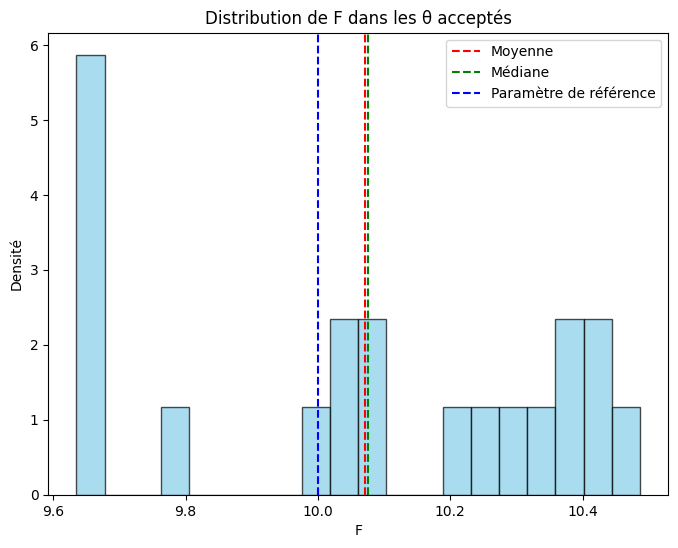

Paramètre : h
 - Moyenne : 1.0485
 - Médiane : 1.0594
 - Écart-type : 0.0973
 - Intervalle de crédibilité (5%-95%) : [0.84751404 1.17448218]
--------------------------------------------------


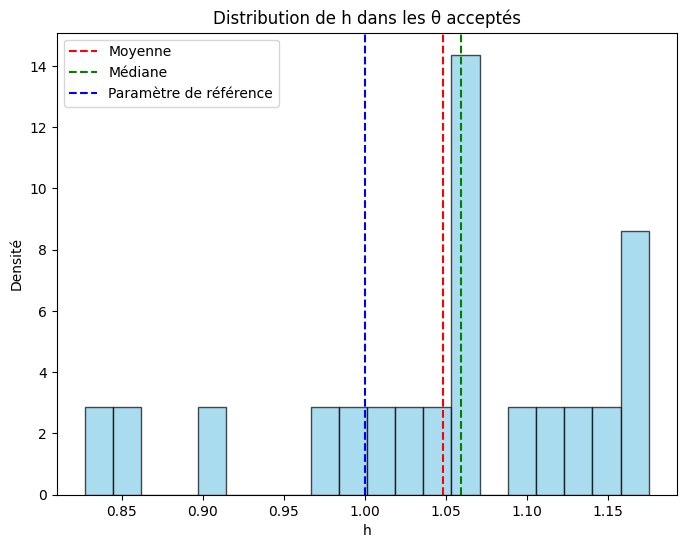

Paramètre : b
 - Moyenne : 9.5034
 - Médiane : 9.3964
 - Écart-type : 0.2209
 - Intervalle de crédibilité (5%-95%) : [9.3004947  9.98287475]
--------------------------------------------------


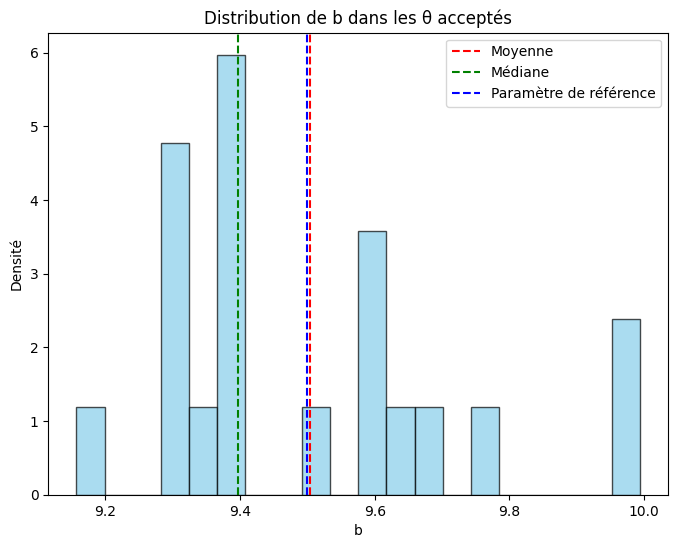

Paramètre : c
 - Moyenne : 10.0203
 - Médiane : 9.8735
 - Écart-type : 0.4954
 - Intervalle de crédibilité (5%-95%) : [ 9.45660128 10.87149357]
--------------------------------------------------


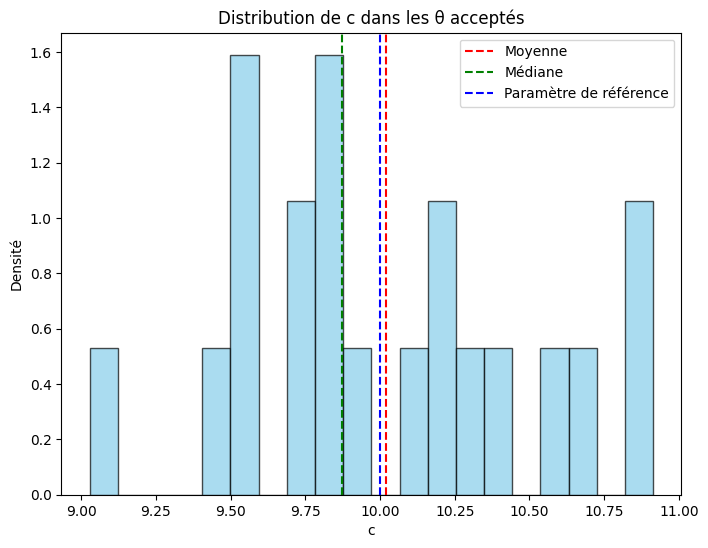

Paramètre : F
 - Moyenne : 10.0710
 - Médiane : 10.0760
 - Écart-type : 0.2945
 - Intervalle de crédibilité (5%-95%) : [ 9.64281155 10.43206279]
--------------------------------------------------


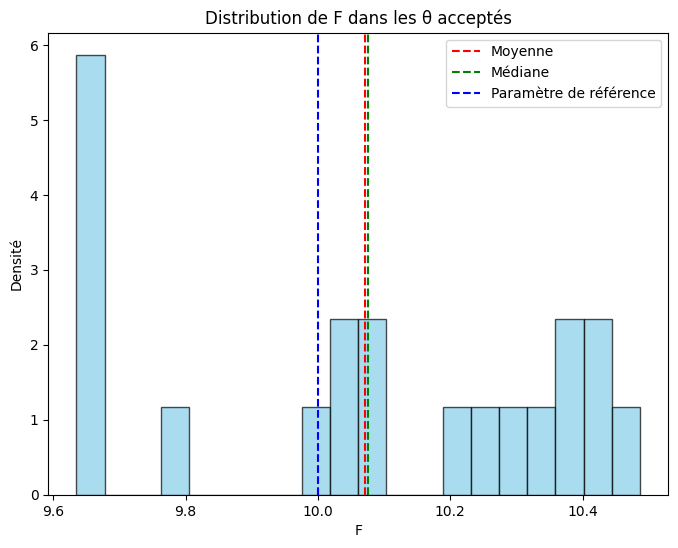

Paramètre : h
 - Moyenne : 1.0485
 - Médiane : 1.0594
 - Écart-type : 0.0973
 - Intervalle de crédibilité (5%-95%) : [0.84751404 1.17448218]
--------------------------------------------------


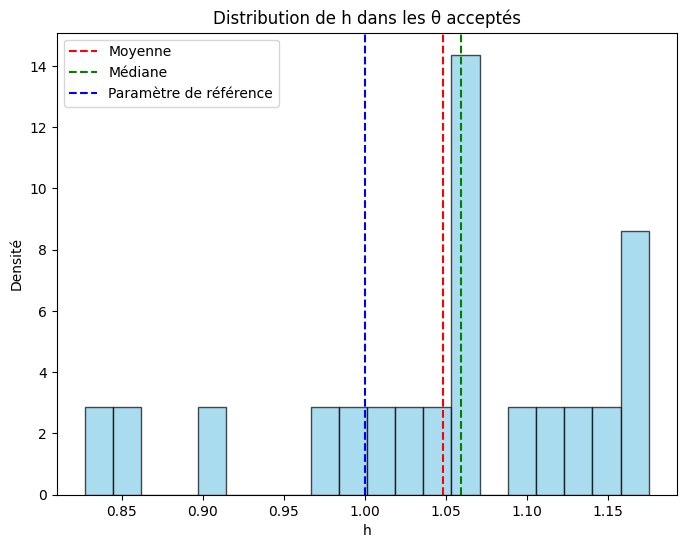

Paramètre : b
 - Moyenne : 9.5034
 - Médiane : 9.3964
 - Écart-type : 0.2209
 - Intervalle de crédibilité (5%-95%) : [9.3004947  9.98287475]
--------------------------------------------------


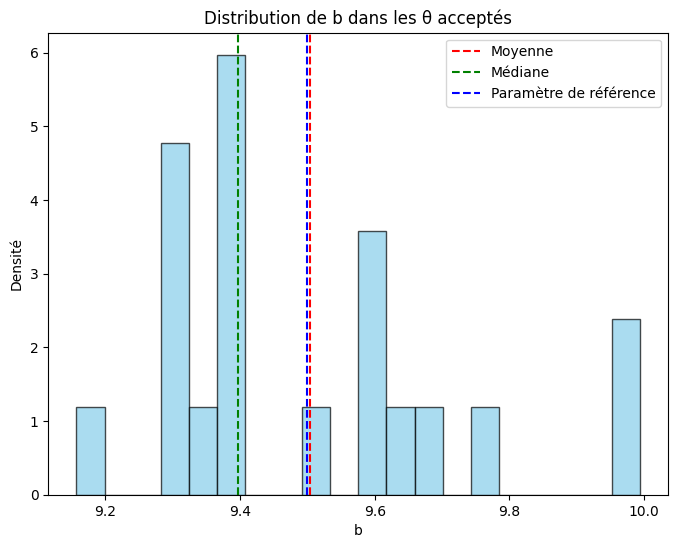

Paramètre : c
 - Moyenne : 10.0203
 - Médiane : 9.8735
 - Écart-type : 0.4954
 - Intervalle de crédibilité (5%-95%) : [ 9.45660128 10.87149357]
--------------------------------------------------


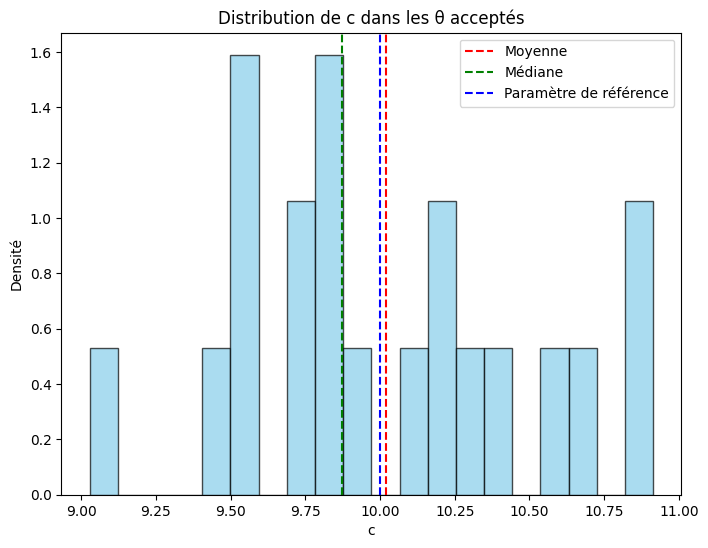

Paramètre : F
 - Moyenne : 10.0710
 - Médiane : 10.0760
 - Écart-type : 0.2945
 - Intervalle de crédibilité (5%-95%) : [ 9.64281155 10.43206279]
--------------------------------------------------


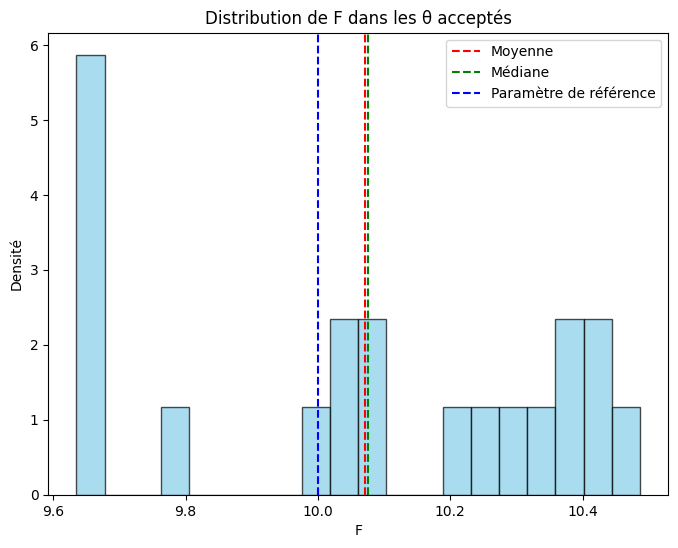

Paramètre : h
 - Moyenne : 1.0485
 - Médiane : 1.0594
 - Écart-type : 0.0973
 - Intervalle de crédibilité (5%-95%) : [0.84751404 1.17448218]
--------------------------------------------------


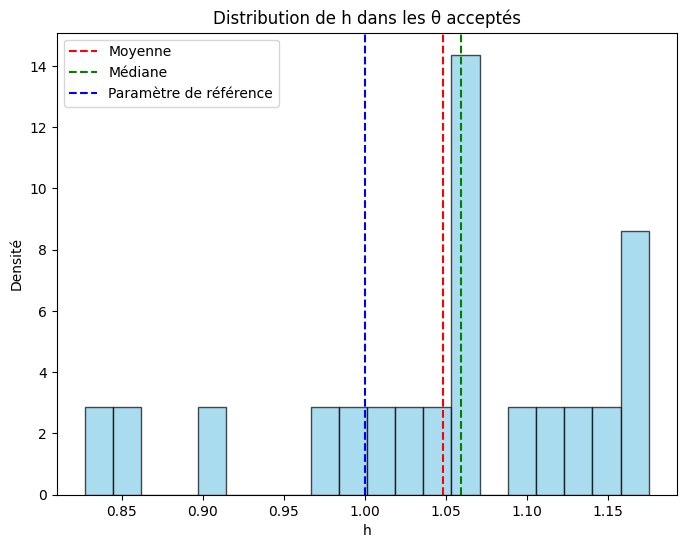

Paramètre : b
 - Moyenne : 9.5034
 - Médiane : 9.3964
 - Écart-type : 0.2209
 - Intervalle de crédibilité (5%-95%) : [9.3004947  9.98287475]
--------------------------------------------------


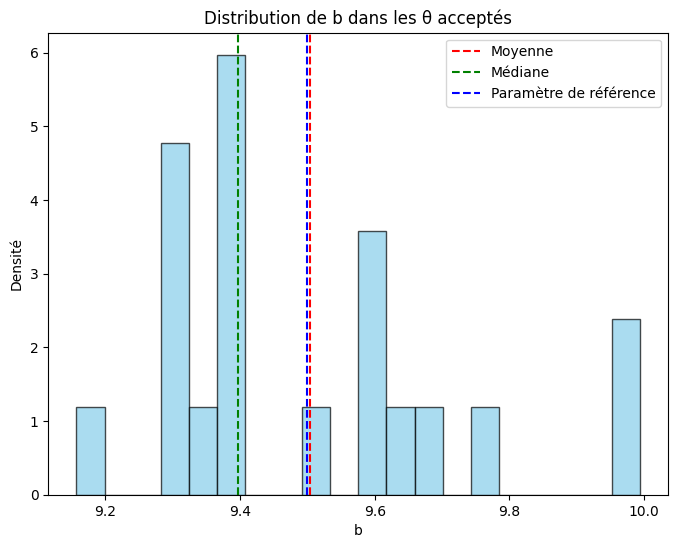

Paramètre : c
 - Moyenne : 10.0203
 - Médiane : 9.8735
 - Écart-type : 0.4954
 - Intervalle de crédibilité (5%-95%) : [ 9.45660128 10.87149357]
--------------------------------------------------


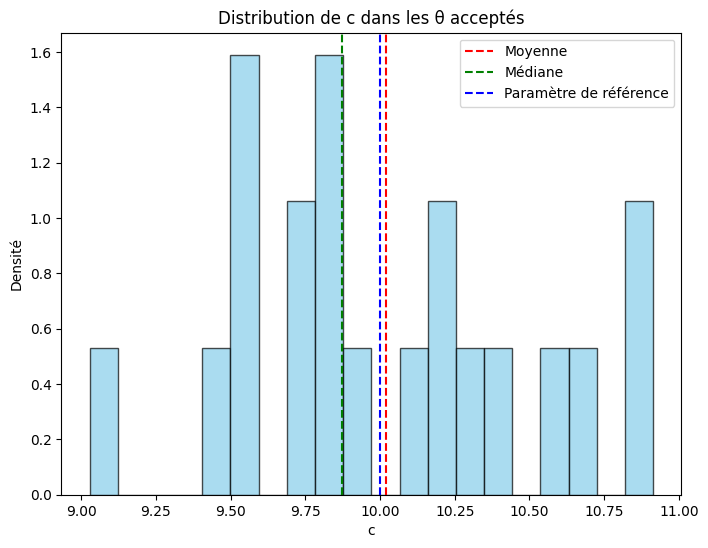

Paramètre : F
 - Moyenne : 10.0710
 - Médiane : 10.0760
 - Écart-type : 0.2945
 - Intervalle de crédibilité (5%-95%) : [ 9.64281155 10.43206279]
--------------------------------------------------


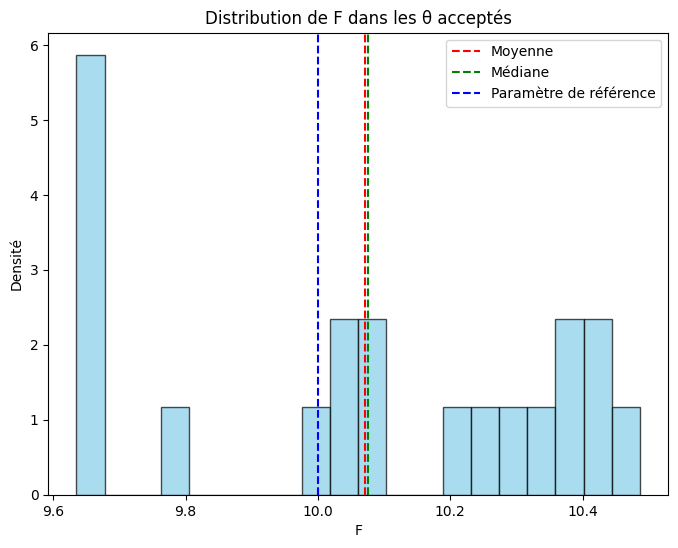

Paramètre : h
 - Moyenne : 1.0485
 - Médiane : 1.0594
 - Écart-type : 0.0973
 - Intervalle de crédibilité (5%-95%) : [0.84751404 1.17448218]
--------------------------------------------------


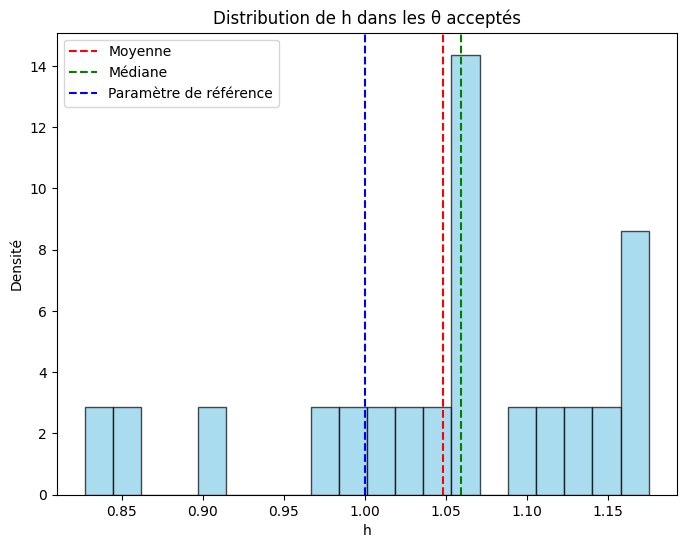

Paramètre : b
 - Moyenne : 9.5034
 - Médiane : 9.3964
 - Écart-type : 0.2209
 - Intervalle de crédibilité (5%-95%) : [9.3004947  9.98287475]
--------------------------------------------------


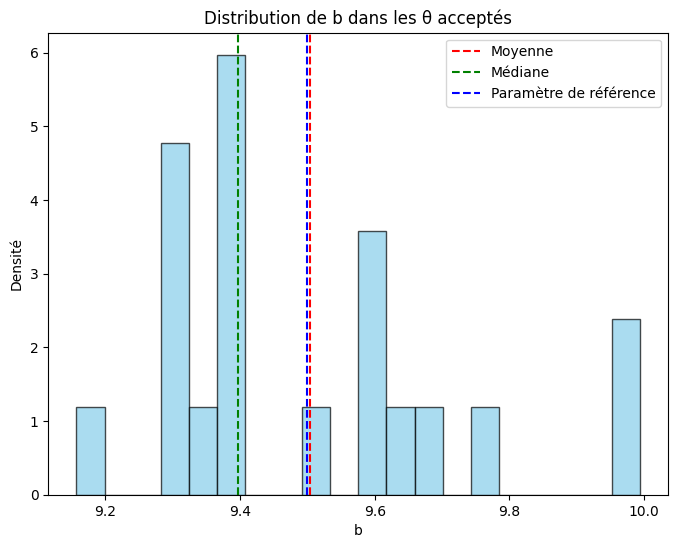

Paramètre : c
 - Moyenne : 10.0203
 - Médiane : 9.8735
 - Écart-type : 0.4954
 - Intervalle de crédibilité (5%-95%) : [ 9.45660128 10.87149357]
--------------------------------------------------


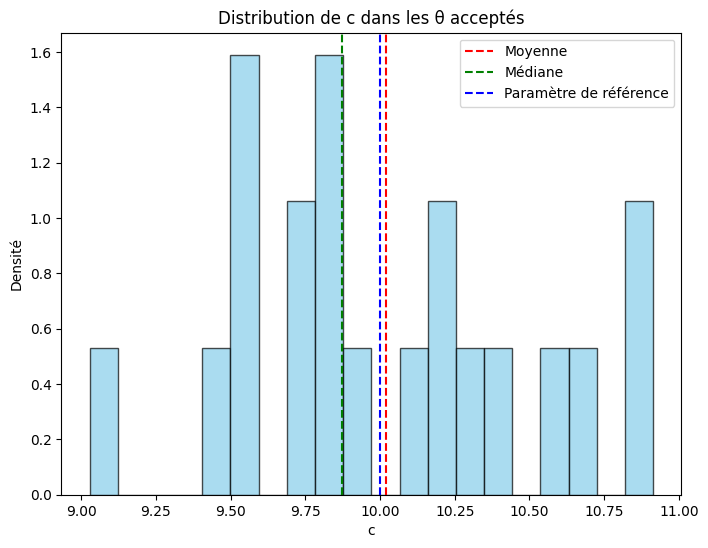

In [13]:
# Exemple d'utilisation
plot_parameter_distributions(theta_ref,priors,accepted_thetas_ABC_R)

### **Comparaison avec les paramètres de référence**
#### Objectif :
Évaluer si les paramètres acceptés se rapprochent des paramètres de référence ($F_{\text{ref}}, h_{\text{ref}}, b_{\text{ref}}, c_{\text{ref}}$).
**Calcul des écarts relatifs :**
   Comparez les valeurs estimées (par exemple, moyennes ou médianes des paramètres acceptés) aux paramètres de référence.
   

In [14]:


for param, ref_value in theta_ref.items():
       values = [theta[param] for theta in accepted_thetas_ABC_R]
       mean_value = np.mean(values)
       relative_error = abs(mean_value - ref_value) / ref_value * 100
       print(f"{param} : Erreur relative = {relative_error:.2f}%")

F : Erreur relative = 0.71%
h : Erreur relative = 4.85%
b : Erreur relative = 0.04%
c : Erreur relative = 0.20%


### **Visualisation des distributions marginales**



In [15]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_marginal_distributions(priors,accepted_thetas):
    """
    Trace les distributions marginales des paramètres \(\theta\) acceptés.

    accepted_thetas : list
        Liste des paramètres acceptés (\(\theta\)).
    priors : dict
        Dictionnaire des paramètres et leurs intervalles.

    """
    for param in priors.keys():
        # Extraire les valeurs acceptées pour ce paramètre
        values = [theta[param] for theta in accepted_thetas]
        
        # Estimation de densité par noyau
        kde = gaussian_kde(values)
        x_range = np.linspace(priors[param][0], priors[param][1], 500)
        density = kde(x_range)
        
        # Tracer la densité
        plt.figure(figsize=(8, 5))
        plt.plot(x_range, density, label=f'Densité estimée pour {param}')
        plt.hist(values, bins=20, density=True, alpha=0.6, label=f'Histogramme {param}')
        plt.title(f"Distribution marginale pour {param}")
        plt.xlabel(param)
        plt.ylabel("Densité")
        plt.legend()
        plt.grid()
        plt.show()




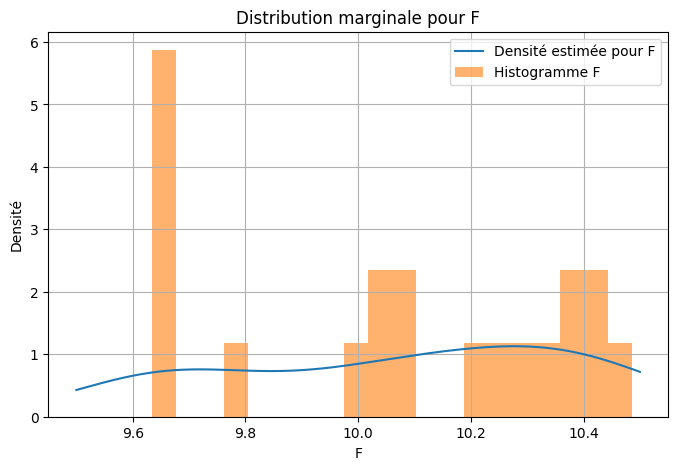

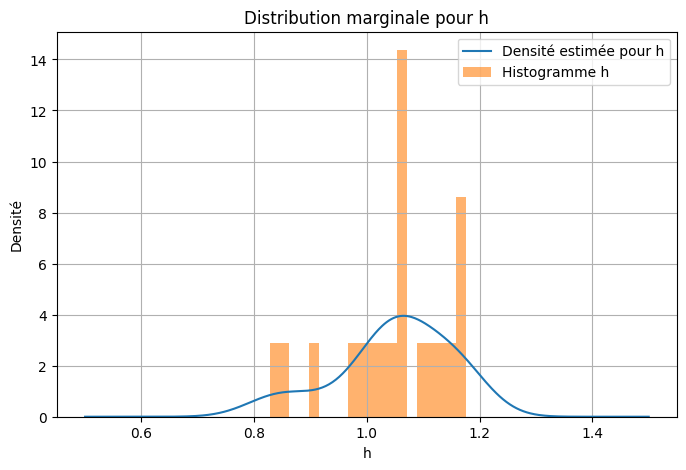

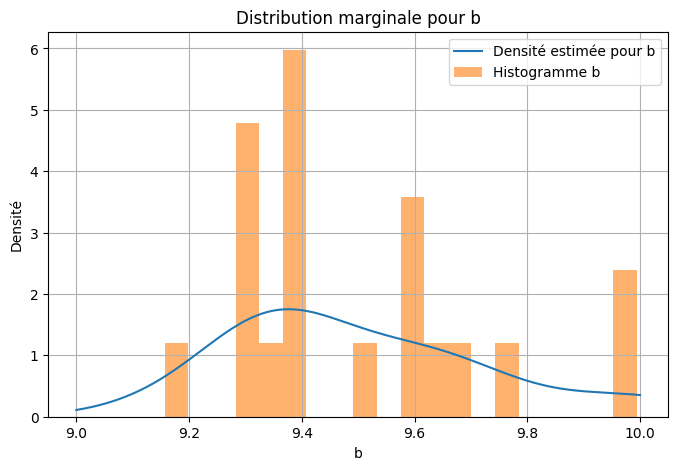

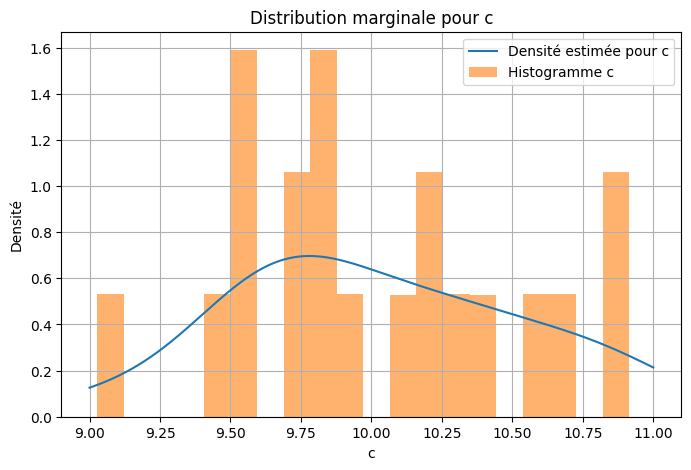

In [16]:
plot_marginal_distributions(priors,accepted_thetas_ABC_R) 




## **II/ Étude Empirique du Seuil ε**

### Méthodes de Sélection
Au-delà de l'approche empirique, explore et compare d'autres méthodes de sélection du seuil ε, comme l'utilisation d'une heuristique basée sur la distance minimale observée ou des méthodes adaptatives. Tu peux aussi mentionner des méthodes de validation croisée.

### Sensibilité
Analyse en profondeur la sensibilité de ton modèle aux différentes valeurs de ε. Crée des graphiques montrant comment la distribution a posteriori change avec ε. Quantifie l'impact de ε sur la précision de l'estimation et le taux d'acceptation.

### Intervalle Optimal
Essaie de déterminer un intervalle "optimal" pour ε qui offre un bon compromis entre précision et coût computationnel. Cela pourrait passer par une analyse empirique des performances pour différents intervalles.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from multiprocessing import Pool # Import pour la parallélisation


def run_abc_with_epsilon(epsilon, priors, metrics_obs, n_simulations):
    """
    Exécute l'algorithme ABC Rejection pour une valeur donnée de epsilon.
    Retourne les paramètres acceptés, le nombre total de simulations et
    le taux d'acceptation.
    """
    accepted_thetas= abc_rejection(priors, metrics_obs, n_simulations, epsilon)
    Nacc= len(accepted_thetas)
    percentage_accepted = (Nacc / n_simulations) * 100
    return accepted_thetas, percentage_accepted

def run_abc_with_adaptive_epsilon(priors, metrics_obs, n_simulations, initial_epsilon, decay_rate, T=10, dt=0.01):
    """
    Exécute l'algorithme ABC Rejection avec un seuil epsilon adaptatif.
    """
    accepted_thetas = []
    current_epsilon = initial_epsilon
    Nacc = 0
    for i in range(n_simulations):
        theta_i = sample_prior(priors)
        X_sim_i, Y_sim_i = lorenz96_two_equations(**theta_i, T=T, dt=dt)
        metrics_sim_i = calculate_metrics(X_sim_i, Y_sim_i, tau=T)
        distance_i = calculate_distance(metrics_sim_i, metrics_obs)

        if distance_i <= current_epsilon:
            accepted_thetas.append(theta_i)
            Nacc += 1
        # Mise à jour adaptative de epsilon
        current_epsilon *= decay_rate
    
    percentage_accepted = (Nacc / n_simulations) * 100
    return accepted_thetas, percentage_accepted, current_epsilon

def run_abc_with_dmin_epsilon(priors, metrics_obs, n_simulations, alpha, T=10, dt=0.01):
    """
    Exécute l'algorithme ABC Rejection avec epsilon basé sur la distance minimale.
    """
    distances = []
    for i in range(n_simulations):
        theta_i = sample_prior(priors)
        X_sim_i, Y_sim_i = lorenz96_two_equations(**theta_i, T=T, dt=dt)
        metrics_sim_i = calculate_metrics(X_sim_i, Y_sim_i, tau=T)
        distance_i = calculate_distance(metrics_sim_i, metrics_obs)
        distances.append(distance_i)

    dmin = min(distances)
    epsilon = alpha * dmin
    accepted_thetas= abc_rejection(priors, metrics_obs, n_simulations, epsilon, T=T, dt=dt)
    
    Nacc = len(accepted_thetas)
    percentage_accepted = (Nacc / n_simulations) * 100

    return accepted_thetas, percentage_accepted, epsilon


# --- Visualisation des Distributions avec Scipy ---
def plot_density_distributions(priors, accepted_thetas, ref_value_dict):
    """
    Trace les distributions marginales des paramètres \(\theta\) acceptés,
    avec les valeurs de référence et la méthode d'estimation de la densité.
    """
    for param_name in priors.keys():
        # Extraire les valeurs acceptées pour ce paramètre
        values = [theta[param_name] for theta in accepted_thetas]

        # Estimation de densité par noyau
        kde = gaussian_kde(values)
        x_range = np.linspace(priors[param_name][0], priors[param_name][1], 500)
        density = kde(x_range)

        # Tracer uniquement la courbe de densité
        plt.figure(figsize=(8, 5))
        plt.plot(x_range, density, label=f'Densité estimée pour {param_name}', color='blue')
        plt.title(f"Distribution marginale pour {param_name}")
        plt.xlabel(param_name)
        plt.ylabel("Densité")
        if param_name in ref_value_dict:  # Ajoutez la ligne verticale si la valeur de référence existe
            plt.axvline(ref_value_dict[param_name], color='red', linestyle='dashed', label="Valeur de référence")
        plt.legend()
        plt.grid()
        plt.show()


def plot_epsilon_sensitivity(results, ref_value_dict):
    """
    Trace les courbes de sensibilité de epsilon sur les paramètres et autres métriques.
    """
    param_names = list(priors.keys())
    
    # Nombre de lignes pour chaque subplot
    num_params = len(param_names)
    
    # Création de la figure et des sous-graphiques
    fig, axes = plt.subplots(nrows=3, ncols=num_params, figsize=(15*num_params, 18),sharex='col')
    # Pour chaque paramètre
    for idx, param_name in enumerate(param_names):
        
        epsilons = [res[0] for res in results]
        relative_errors = []
        accepted_percs = []
        uncertainties = []
        for epsilon, accepted_thetas, percentage_accepted in results:
            
            values = [theta[param_name] for theta in accepted_thetas]
            mean_value = np.mean(values)
            relative_error = abs(mean_value - ref_value_dict[param_name]) / ref_value_dict[param_name] * 100
            relative_errors.append(relative_error)
            accepted_percs.append(percentage_accepted)
            uncertainties.append(np.std(values))

        # Erreurs Relatives
        axes[0, idx].plot(epsilons, relative_errors, marker='o')
        axes[0, idx].set_title(f'Erreur Relative pour {param_name}')
        axes[0, idx].set_xlabel("Seuil $\\epsilon$")
        axes[0, idx].set_ylabel("Erreur Rel. (%)")
        axes[0, idx].grid(True)
    
        # Taux d'Acceptation
        axes[1, idx].plot(epsilons, accepted_percs, marker='x', color='g')
        axes[1, idx].set_title(f'Taux d\'Acceptation pour {param_name}')
        axes[1, idx].set_xlabel("Seuil $\\epsilon$")
        axes[1, idx].set_ylabel("Taux d'Acceptation (%)")
        axes[1, idx].grid(True)

        # Ecarts types
        axes[2, idx].plot(epsilons, uncertainties, marker='s', color='r')
        axes[2, idx].set_title(f'Écart-type pour {param_name}')
        axes[2, idx].set_xlabel("Seuil $\\epsilon$")
        axes[2, idx].set_ylabel("Écart-type")
        axes[2, idx].grid(True)
    
    plt.tight_layout()
    plt.show()




In [18]:


# Initialisation des listes pour stocker les résultats
results_empiric = []
results_adaptive = []
results_dmin = []



In [19]:
# --- Étude Empirique du Seuil ε ---
# Valeurs de epsilon pour l'analyse empirique
epsilon_values = [0.05, 0.1, 0.3, 0.5, 1.0]

# Exécution de l'ABC Rejet pour chaque valeur de epsilon et sauvegarde des résultats
for epsilon in epsilon_values:
    accepted_thetas, percentage_accepted = run_abc_with_epsilon(epsilon, priors, metrics_obs, n_simulations=1000)
    results_empiric.append((epsilon, accepted_thetas, percentage_accepted))
    print(f"Exécution de l'ABC Rejection pour epsilon = {epsilon}...")
    print(f"Pourcentage de paramètres acceptés : {percentage_accepted:.2f}%\n")



Exécution de l'ABC Rejection pour epsilon = 0.05...
Pourcentage de paramètres acceptés : 0.00%

Exécution de l'ABC Rejection pour epsilon = 0.1...
Pourcentage de paramètres acceptés : 0.00%

Exécution de l'ABC Rejection pour epsilon = 0.3...
Pourcentage de paramètres acceptés : 0.50%

Exécution de l'ABC Rejection pour epsilon = 0.5...
Pourcentage de paramètres acceptés : 1.80%

Exécution de l'ABC Rejection pour epsilon = 1.0...
Pourcentage de paramètres acceptés : 11.40%



In [58]:

# Exécution de l'ABC Rejet avec epsilon adaptatif
initial_epsilon = 1.0
decay_rate = 0.95
accepted_thetas_adaptive, percentage_accepted_adaptive, final_epsilon  = run_abc_with_adaptive_epsilon(priors, metrics_obs, n_simulations=1000, initial_epsilon=initial_epsilon, decay_rate=decay_rate)
results_adaptive =  [(final_epsilon, accepted_thetas_adaptive, percentage_accepted_adaptive)]
print(f"Exécution de l'ABC Rejection avec epsilon adaptatif...")
print(f"Pourcentage de paramètres acceptés : {percentage_accepted_adaptive:.2f}%, epsilon final: {final_epsilon:.2f}\n")



Exécution de l'ABC Rejection avec epsilon adaptatif...
Pourcentage de paramètres acceptés : 0.00%, epsilon final: 0.00



In [59]:

# Exécution de l'ABC Rejet avec epsilon basé sur la distance minimale
alpha_dmin = 0.5
accepted_thetas_dmin, percentage_accepted_dmin, epsilon_dmin = run_abc_with_dmin_epsilon(priors, metrics_obs, n_simulations=1000, alpha=alpha_dmin)
results_dmin =  [(epsilon_dmin, accepted_thetas_dmin, percentage_accepted_dmin)]
print(f"Exécution de l'ABC Rejection avec epsilon basé sur d_min, alpha = {alpha_dmin}...")
print(f"Pourcentage de paramètres acceptés : {percentage_accepted_dmin:.2f}%, epsilon final: {epsilon_dmin:.2f}\n")




Exécution de l'ABC Rejection avec epsilon basé sur d_min, alpha = 0.5...
Pourcentage de paramètres acceptés : 0.00%, epsilon final: 0.13



In [60]:
results_empiric[2][1]

[{'F': 9.622113429265937,
  'h': 0.9685627342882979,
  'b': 9.653681633296191,
  'c': 10.83252763766182},
 {'F': 10.08759194398623,
  'h': 0.9306067354935924,
  'b': 9.563369919204945,
  'c': 10.228524660009766},
 {'F': 10.381851867775424,
  'h': 1.0783454382900692,
  'b': 9.801807230506773,
  'c': 9.896227865144084},
 {'F': 9.848099806517922,
  'h': 0.936215000009809,
  'b': 9.759264020050491,
  'c': 9.748863972836572},
 {'F': 10.013105719277858,
  'h': 1.1028285669922124,
  'b': 9.69277398505664,
  'c': 10.74616451032237}]

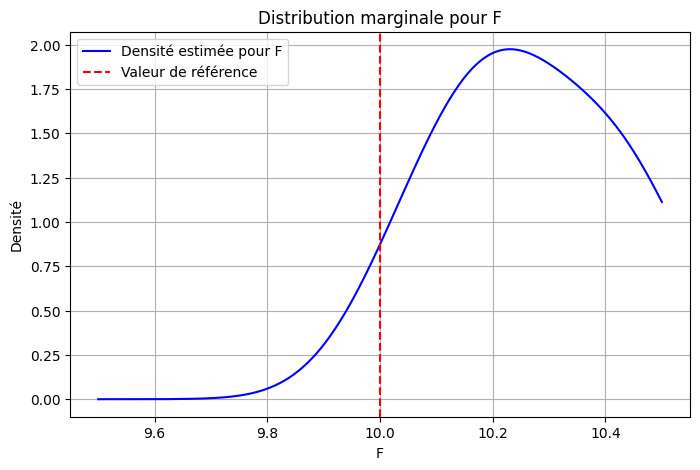

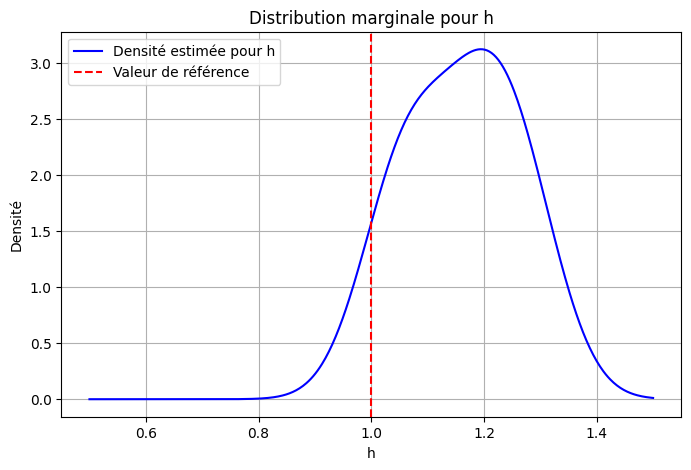

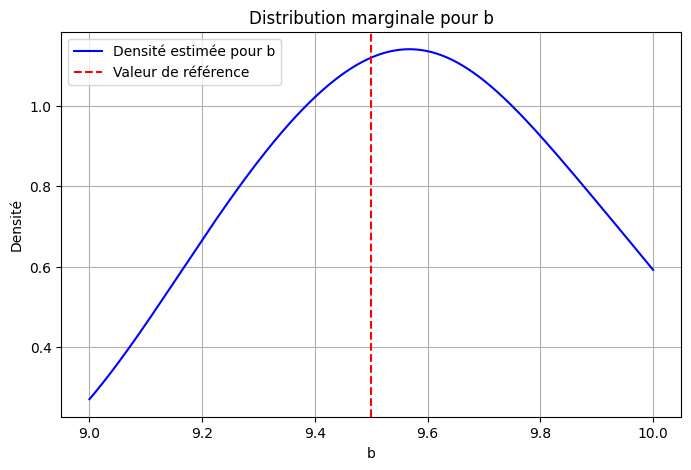

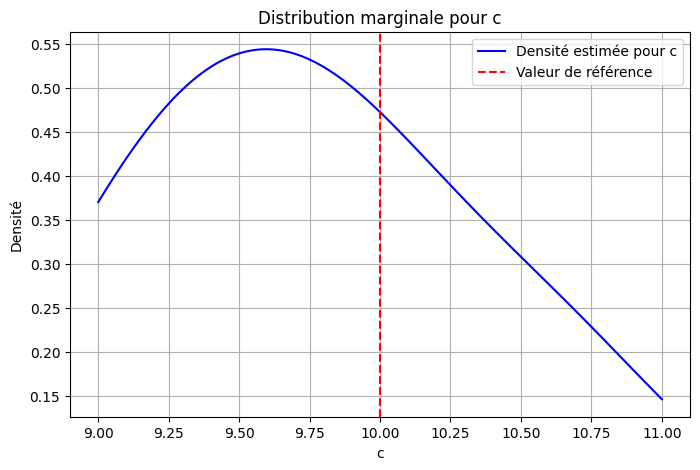

In [20]:


# Visualisation des distributions marginales et des statistiques descriptives avec la valeur de reference
plot_density_distributions(priors, results_empiric[2][1], ref_value_dict = theta_ref) 




In [62]:
results_empiric

[(0.05, [], 0.0),
 (0.1, [], 0.0),
 (0.3,
  [{'F': 9.622113429265937,
    'h': 0.9685627342882979,
    'b': 9.653681633296191,
    'c': 10.83252763766182},
   {'F': 10.08759194398623,
    'h': 0.9306067354935924,
    'b': 9.563369919204945,
    'c': 10.228524660009766},
   {'F': 10.381851867775424,
    'h': 1.0783454382900692,
    'b': 9.801807230506773,
    'c': 9.896227865144084},
   {'F': 9.848099806517922,
    'h': 0.936215000009809,
    'b': 9.759264020050491,
    'c': 9.748863972836572},
   {'F': 10.013105719277858,
    'h': 1.1028285669922124,
    'b': 9.69277398505664,
    'c': 10.74616451032237}],
  0.5),
 (0.5,
  [{'F': 10.293715913544807,
    'h': 0.8258261722697056,
    'b': 9.106542037064015,
    'c': 10.847658961452069},
   {'F': 10.362154598289848,
    'h': 1.0257613286969867,
    'b': 9.248415303631546,
    'c': 10.11991679728246},
   {'F': 10.04299956310652,
    'h': 0.9613257764815653,
    'b': 9.151795901708743,
    'c': 10.905423147450877},
   {'F': 10.3317554769179

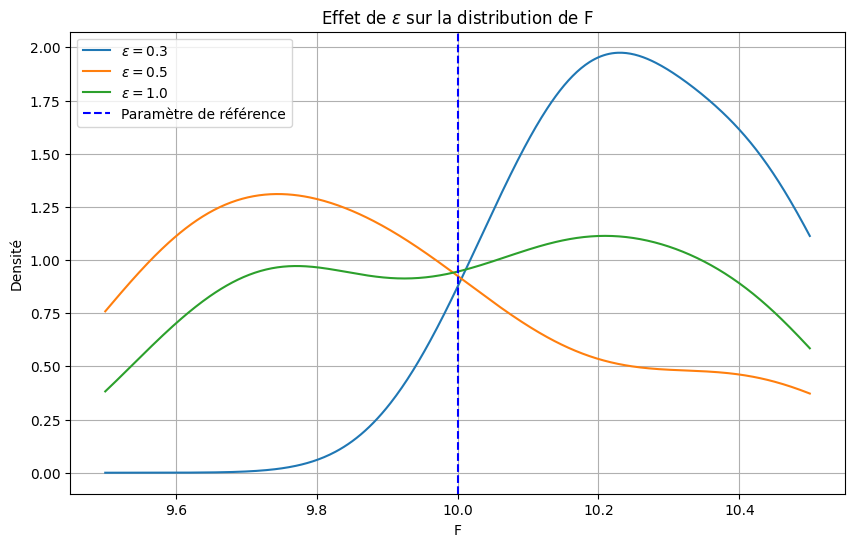

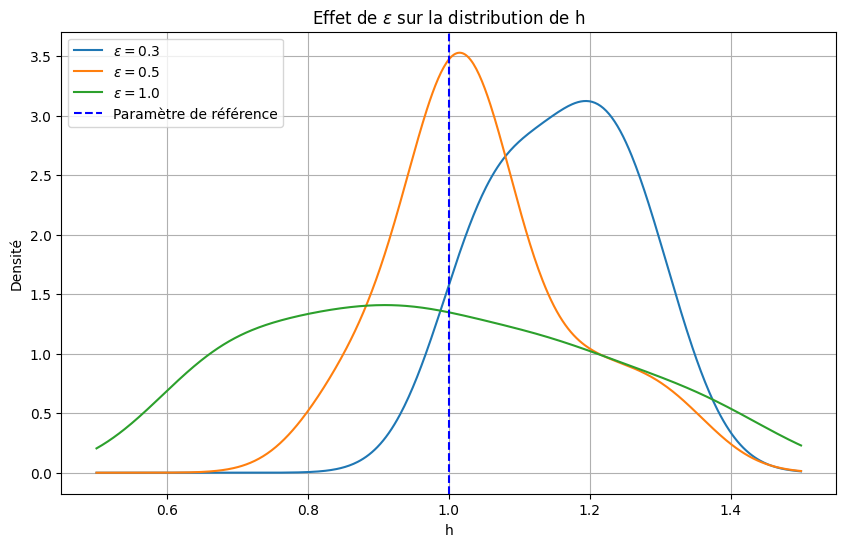

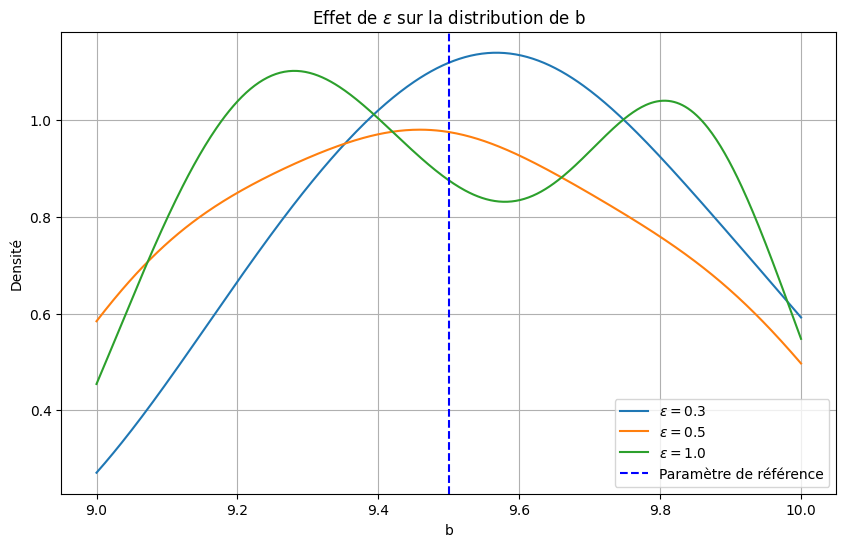

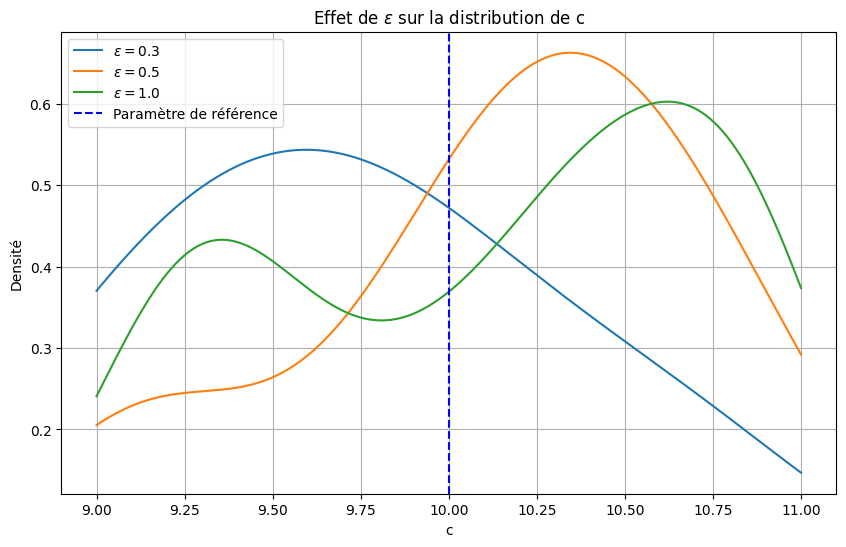

In [21]:
def plot_density_distributions(priors, results_empiric, epsilon_values, theta_ref):
    """
    Trace les distributions marginales des paramètres \(\theta\) acceptés
    pour différentes valeurs d'epsilon, avec les valeurs de référence.
    """
    for param_name in priors.keys():
        plt.figure(figsize=(10, 6))
        for i, (epsilon, accepted_thetas, _) in enumerate(results_empiric):
            if accepted_thetas: # verifier que la liste n'est pas vide
                values = [theta[param_name] for theta in accepted_thetas]
                kde = gaussian_kde(values)
                x_range = np.linspace(priors[param_name][0], priors[param_name][1], 500)
                density = kde(x_range)
                plt.plot(x_range, density, label=f"$\epsilon = {epsilon}$")
        
        plt.title(f"Effet de $\epsilon$ sur la distribution de {param_name}")
        plt.xlabel(param_name)
        plt.ylabel("Densité")
        if param_name in theta_ref:
            plt.axvline(theta_ref[param_name], color="blue", linestyle="--", label="Paramètre de référence")
        plt.legend()
        plt.grid()
        plt.show()


n_simulations = 1000




# Visualiser les distributions des paramètres pour chaque epsilon
plot_density_distributions(priors, results_empiric, epsilon_values, theta_ref)


/home/ensai/Bureau/PFE***/presentation de la methode ABC/myenv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ensai/Bureau/PFE***/presentation de la methode ABC/myenv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ensai/Bureau/PFE***/presentation de la methode ABC/myenv/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ensai/Bureau/PFE***/presentation de la methode ABC/myenv/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ensai/Bureau/PFE***/presentation de la methode ABC/myenv/lib/python3.11/site-packages/numpy/_core/_methods

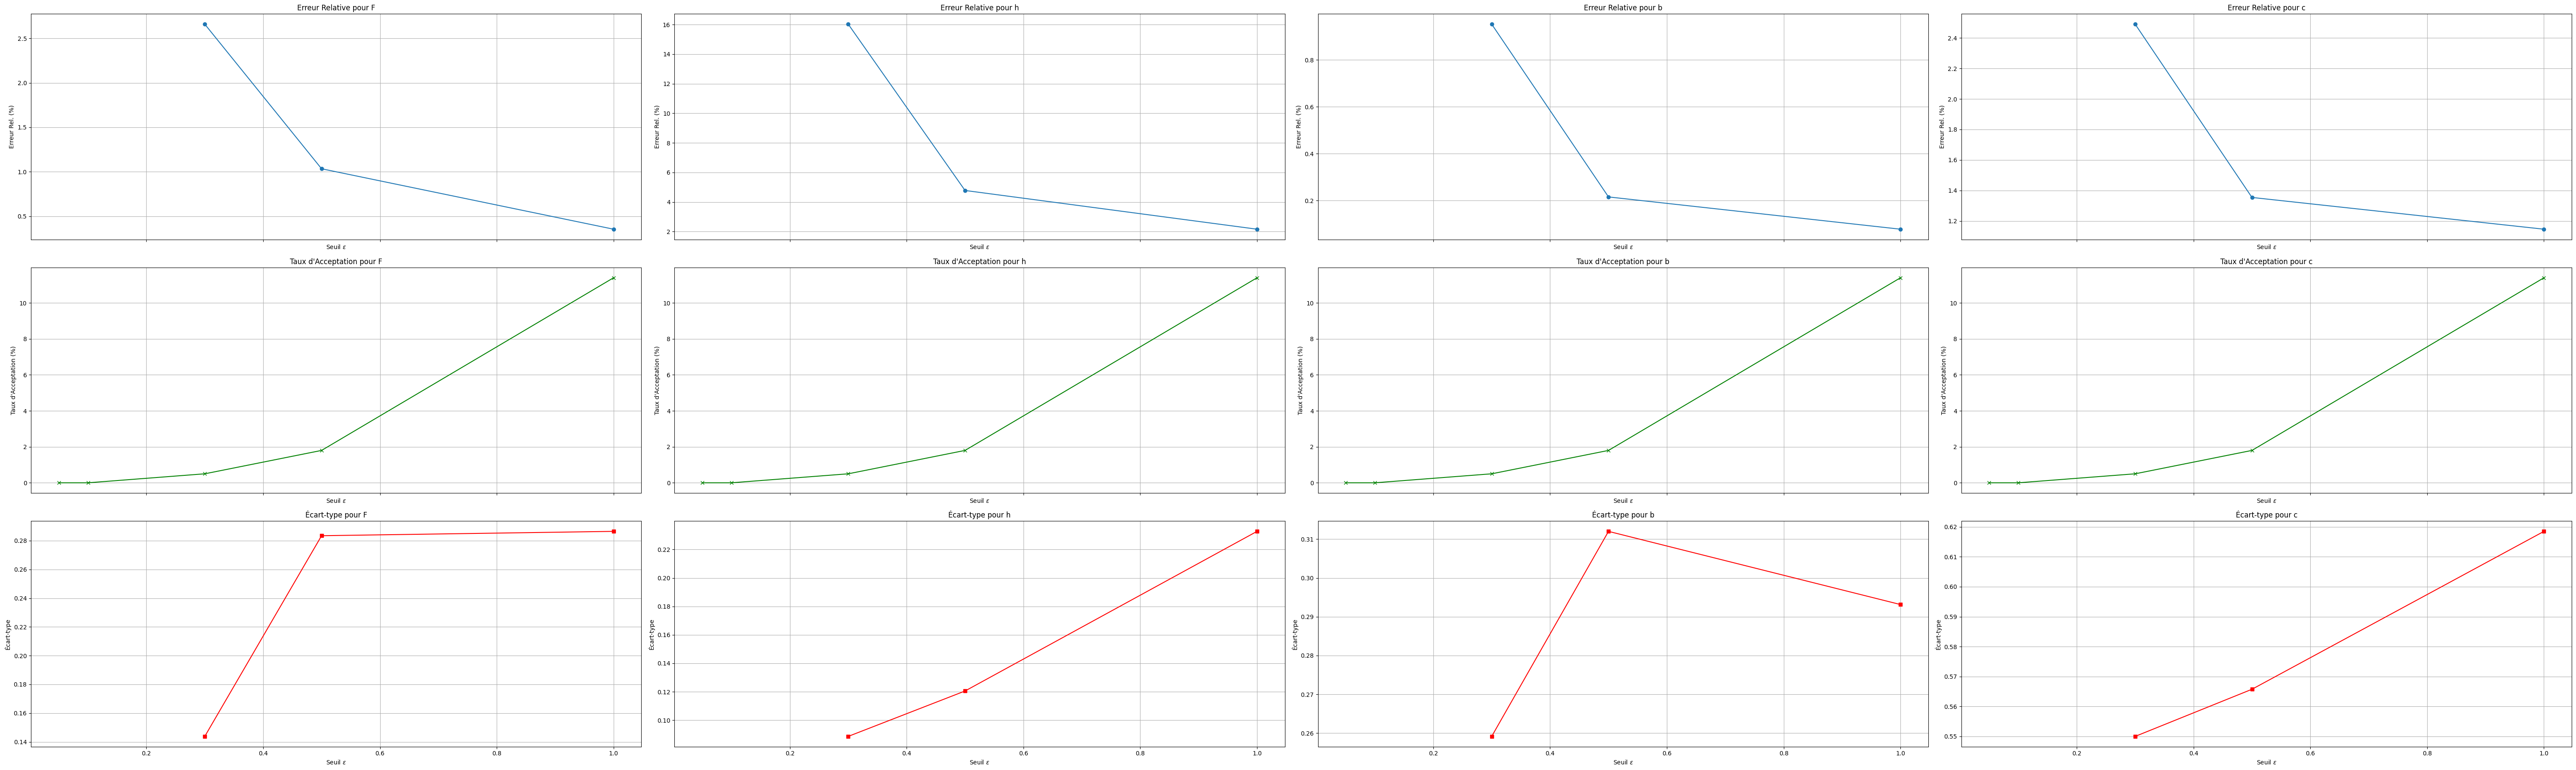

In [22]:

# Analyse de sensibilité
plot_epsilon_sensitivity(results_empiric, theta_ref)






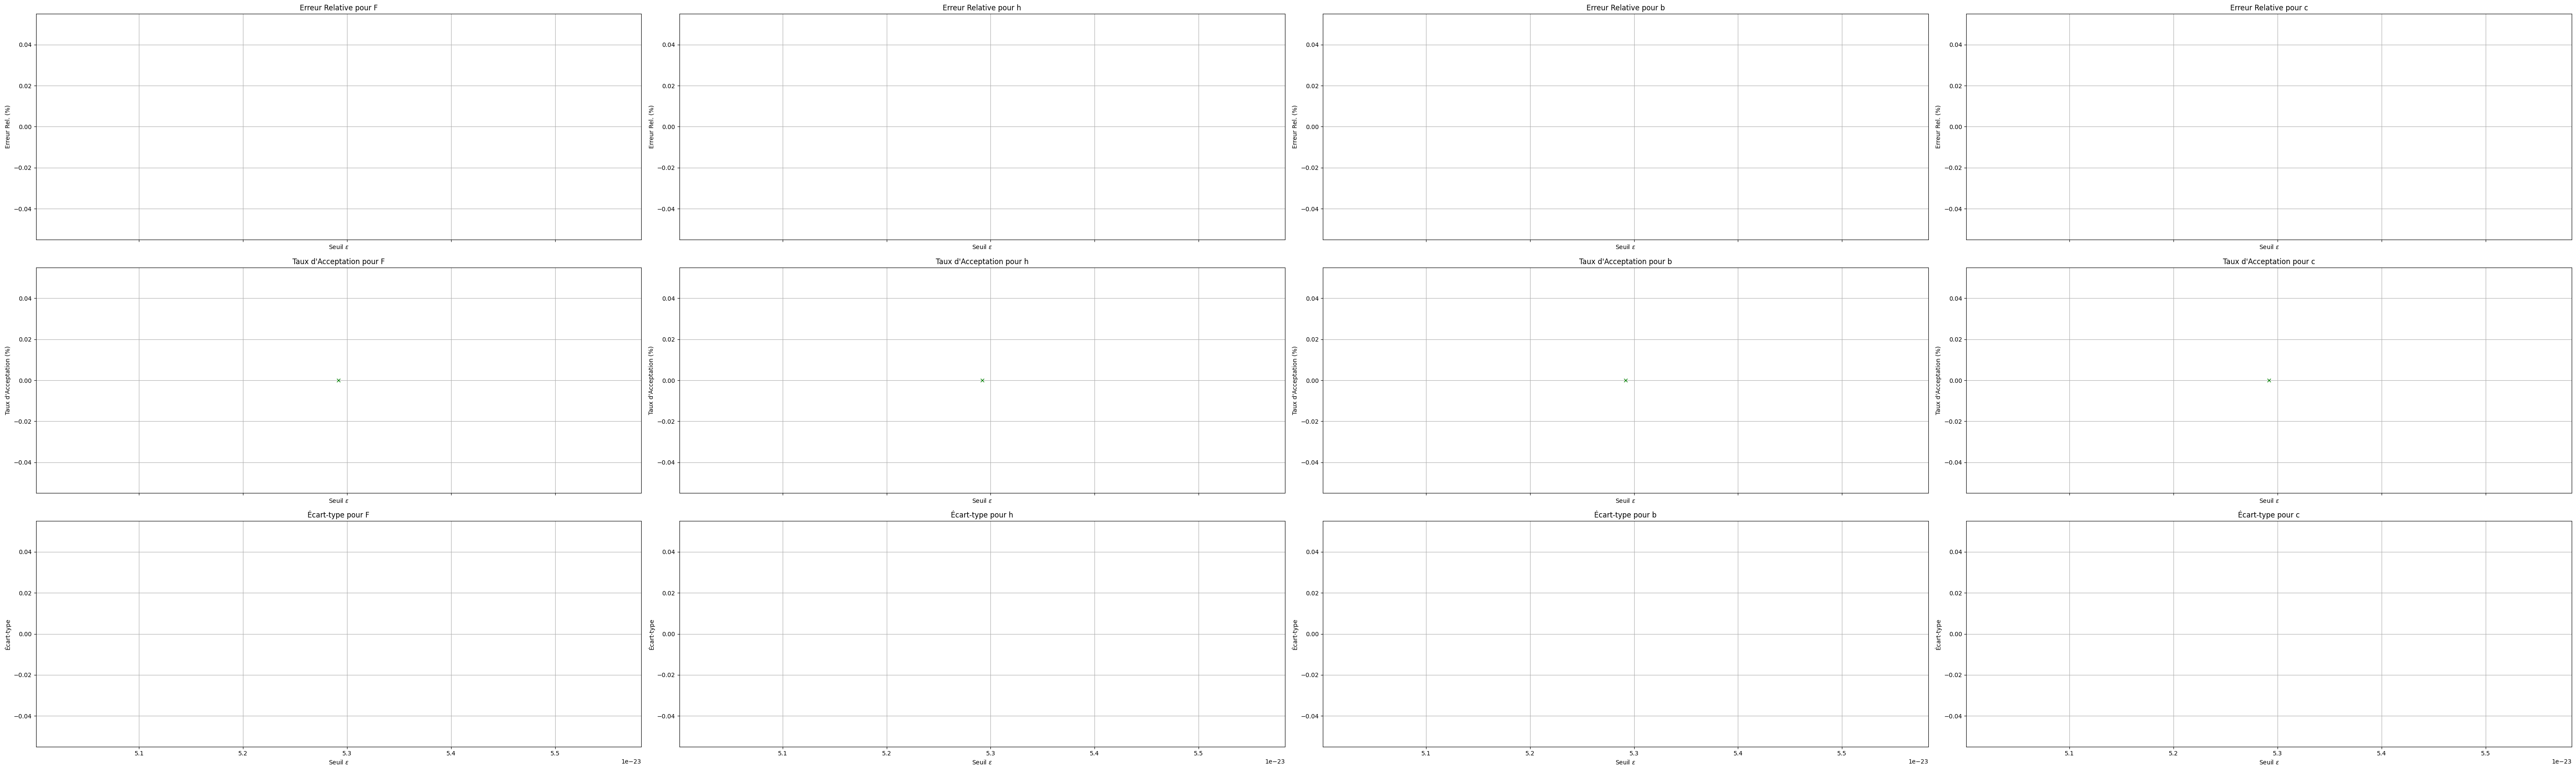

In [65]:

plot_epsilon_sensitivity(results_adaptive, theta_ref)


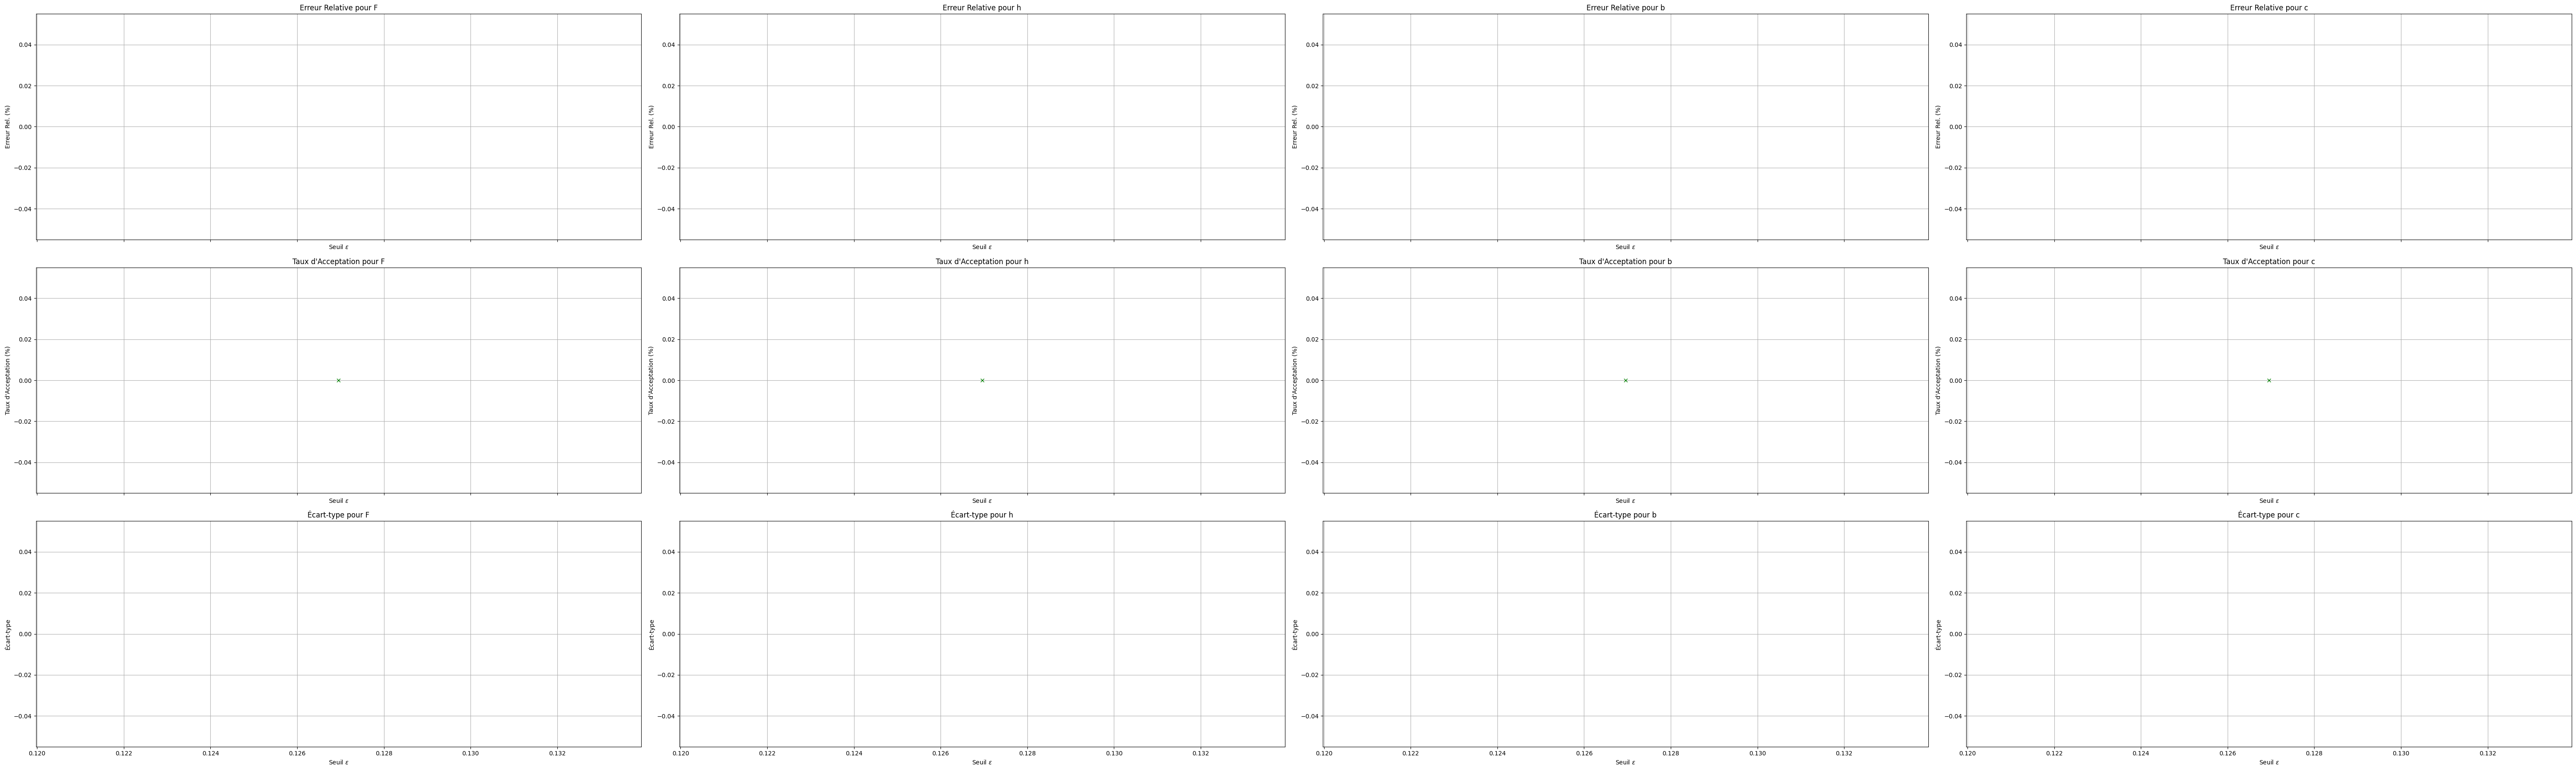

In [66]:
plot_epsilon_sensitivity(results_dmin, theta_ref)

In [67]:

#Afficher les densités pour les méthodes adaptatives et dmin
plot_density_distributions(priors, results_adaptive[0][1], ref_value_dict = theta_ref)


TypeError: plot_density_distributions() got an unexpected keyword argument 'ref_value_dict'

In [31]:

plot_density_distributions(priors, results_dmin[0][1], ref_value_dict = theta_ref)

ValueError: `dataset` input should have multiple elements.

<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



### **II/ Influence du nombre de simulations**

1. **Définition de l'Objectif**

   L'objectif est de déterminer comment le nombre de simulations (ou particles dans le contexte ABC) affecte :

   - **La convergence des distributions a posteriori** : C'est-à-dire, à partir de combien de simulations, la distribution a posteriori cesse de changer significativement.
   - **La précision de l'estimation des paramètres** : Quel est le niveau de précision atteint pour une estimation donnée.
   - **Le temps de calcul** : Comment le temps de calcul évolue en fonction du nombre de simulations.
   - **Le compromis entre précision et temps de calcul** : Trouver un bon compromis entre ces deux aspects.

2. **Méthodologie**

   Voici les étapes à suivre pour effectuer cette étude :

   - **Choisir une séquence de valeurs pour le nombre de simulations** : Choisissez une gamme de valeurs pour `n_simulations`. Il est conseillé de commencer avec des valeurs petites et d'augmenter progressivement (par exemple : 100, 500, 1000, 2000, 5000, 10000, etc.). Vous pouvez utiliser des séquences logarithmiques pour avoir un pas plus resserré dans les valeurs faibles.

   - **Réaliser l'ABC avec chaque valeur de `n_simulations`** : Pour chaque valeur de `n_simulations`, exécutez l'algorithme ABC et sauvegardez les résultats, les distributions a posteriori obtenues et le temps de calcul.

   - **Analyser la convergence des distributions a posteriori** :

     - **Visuellement** : Comparez les distributions a posteriori obtenues pour différentes valeurs de `n_simulations` en les traçant sur un même graphique. Si vous observez que les distributions cessent de changer de manière significative lorsque vous augmentez `n_simulations`, c'est un bon indicateur de convergence. Vous pouvez utiliser des tracés de densité marginale.

     - **Quantitativement** :

       - **Calcul de distances entre distributions** : Calculez une mesure de distance entre les distributions a posteriori obtenues avec différents nombres de simulations. La distance de Kullback-Leibler, la distance de Wasserstein ou des mesures plus simples comme la distance entre les moyennes ou les écart-types des distributions peuvent être utilisées.
       
       - **Variation des statistiques** : Suivez l'évolution des statistiques descriptives (moyenne, écart-type, quantiles) de la distribution a posteriori avec l'augmentation du nombre de simulations. La convergence est atteinte lorsque ces statistiques cessent de varier significativement.

   - **Mesurer le temps de calcul** :

     - **Utiliser `time`** : Utilisez la librairie `time` pour mesurer précisément le temps d'exécution de chaque simulation.
     
     - **Tracer l'évolution du temps de calcul** : Tracez un graphique du temps de calcul en fonction du nombre de simulations.

   - **Comparer les résultats** :

     - **Convergence vs. temps de calcul** : Comparez la convergence des distributions a posteriori avec le temps de calcul. Vous pouvez, par exemple, faire un graphique avec en abscisse le temps de calcul et en ordonnée une métrique de convergence (la distance entre distributions, par exemple).

     - **Précision vs. temps de calcul** : Comparez l'évolution de la précision de l'estimation (par exemple, la largeur des intervalles de confiance à 95 %) avec le temps de calcul. Vous pouvez faire un graphique avec le nombre de simulations (ou le temps de calcul) en abscisse et une métrique de la précision en ordonnée.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import gaussian_kde
from scipy.stats import wasserstein_distance
import warnings

### Remarque 

pour le graphes de convergence on a calculé les distance par rapport à min des n_sim



on va le fait maintenant avec les obs de ref 

In [24]:
# Copyright 2025 ensai
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.




### 1. Qu'est-ce que la convergence dans l'ABC Rejection ?

**Le but ultime :** L'objectif principal de l'ABC Rejection est d'estimer la distribution a posteriori des paramètres du modèle. On veut savoir quelles sont les valeurs des paramètres (F, h, b, c dans ton cas) qui sont les plus probables étant donné les données que l'on a observées (les métriques que l'on a calculées sur ces données observées).

**Le principe de l'ABC :** L'ABC simule de nombreuses fois le modèle avec des valeurs de paramètres tirées au hasard (dans des distributions a priori). Il compare les résultats simulés aux données observées, et accepte seulement les simulations qui sont suffisamment proches des données observées.

**La convergence en ABC :** La convergence dans l'ABC Rejection fait référence à l'idée que, au fur et à mesure que l'on augmente le nombre de simulations (n_sim), la distribution des paramètres acceptés se stabilise. Autrement dit, si l'algorithme ABC converge, on devrait voir que :
- Les distributions a posteriori des paramètres (F, h, b, c) ne changent plus beaucoup quand on augmente n_sim.
- Les métriques calculées à partir des paramètres acceptés se rapprochent des métriques calculées sur les données observées.
- L'incertitude autour des estimations des paramètres se réduit.

**Pourquoi la convergence est importante :** Si l'algorithme ABC ne converge pas, les distributions a posteriori des paramètres ne sont pas fiables, et on ne peut pas se baser sur ces résultats. La convergence, si elle est atteinte, indique que la méthode ABC permet d'obtenir des estimations fiables des paramètres du modèle.

### 2. Qu'est-ce qu'on fait converger ?

- **Distribution a posteriori :** On cherche à ce que la distribution des paramètres (F, h, b, c) se stabilise avec l'augmentation du nombre de simulations.
- **Métriques simulées :** On cherche à ce que les valeurs des métriques calculées sur les simulations se rapprochent des métriques calculées sur les données observées (metrics_obs).
- **Statistiques descriptives des paramètres :** On cherche à ce que la moyenne et l'écart-type des paramètres se stabilisent.

### 3. Comment vérifier la convergence ?

Pour vérifier la convergence dans l'ABC Rejection, on utilise différentes visualisations, que j'ai mises en place dans le code :

- **Distributions a posteriori :**
  - **Visualisation :** On visualise l'évolution de la forme des distributions des paramètres acceptés en fonction du nombre de simulations. On superpose les courbes de densité pour voir comment elles évoluent avec le nombre de simulations.
  - **Ce qu'on cherche :** On cherche à ce que la distribution se stabilise avec l'augmentation du nombre de simulations, c'est-à-dire que la forme de la distribution ne change plus beaucoup.
  - **Dans le code :** C'est le rôle de la fonction `plot_density_distributions`.

- **Distance de Wasserstein :**
  - **Principe :** La distance de Wasserstein permet de mesurer la similarité entre deux distributions. Dans notre cas, on mesure la similarité entre la distribution des métriques obtenues par simulation et les métriques obtenues à partir des données observées (metrics_obs).
  - **Visualisation :** On trace un graphique montrant comment la distance de Wasserstein évolue avec l'augmentation du nombre de simulations.
  - **Ce qu'on cherche :** On cherche à ce que la distance de Wasserstein diminue à mesure que l'on augmente le nombre de simulations, et qu'elle se stabilise à un niveau faible. Cela indique que les simulations permettent de mieux reproduire les données observées.
  - **Dans le code :** C'est le rôle de la fonction `plot_convergence_metrics`, qui utilise la fonction `calculate_wasserstein_distance`.

- **Moyenne et écart-type :**
  - **Principe :** On calcule la moyenne et l'écart-type des paramètres acceptés par l'ABC pour chaque nombre de simulations.
  - **Visualisation :** On trace un graphique de l'évolution de la moyenne et de l'écart-type en fonction du nombre de simulations.
  - **Ce qu'on cherche :** On cherche à ce que la moyenne et l'écart-type des paramètres se stabilisent avec l'augmentation du nombre de simulations. La stabilisation de la moyenne indique la stabilité de la valeur moyenne estimée par l'ABC. La diminution de l'écart-type indique une diminution de l'incertitude des paramètres.
  - **Dans le code :** C'est le rôle de la fonction `plot_convergence_metrics`.

- **Temps de calcul :**
  - **Principe :** On mesure le temps nécessaire pour faire les simulations de l'ABC.
  - **Visualisation :** On trace un graphique montrant le temps de calcul en fonction du nombre de simulations.
  - **Ce qu'on cherche :** On cherche un compromis entre précision et temps de calcul. Il ne faut pas utiliser un nombre de simulations trop grand qui prend trop de temps pour avoir un gain de précision négligeable.
  - **Dans le code :** C'est le rôle de la fonction `plot_computation_time`.

### En résumé :
La convergence dans l'ABC Rejection consiste à vérifier que les distributions de paramètres obtenues avec l'algorithme se stabilisent et se rapprochent de la solution. Pour cela, on utilise :
- **Les distributions marginales :** Pour visualiser si la forme des distributions des paramètres se stabilise avec l'augmentation du nombre de simulations.
- **La distance de Wasserstein :** Pour mesurer, de manière quantitative, comment les distributions a posteriori se rapprochent des données observées (les métriques observées).
- **La moyenne et l'écart-type :** Pour voir comment les statistiques des distributions a posteriori se stabilisent avec l'augmentation du nombre de simulations.
- **Le temps de calcul :** Pour évaluer le compromis entre précision des estimations et le temps de calcul.



<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [25]:
def calculate_wasserstein_distance(values1, values2):
    """
    Calculer la distance de Wasserstein entre deux listes de valeurs.
    """
    return wasserstein_distance(sorted(values1), sorted(values2))


def plot_density_distributions(priors, all_accepted_thetas, ref_value_dict, n_simulations_values):
    """
    Trace les distributions marginales des paramètres \(\theta\) acceptés
    pour différentes valeurs de n_sim sur un meme graphe
    """
    for param_name in priors.keys():
        plt.figure(figsize=(10, 6))
        for i, (n_sim, accepted_thetas, _) in enumerate(all_accepted_thetas):
            
            # Extraire les valeurs acceptées pour ce paramètre
            values = [theta[param_name] for theta in accepted_thetas]

            # Estimation de densité par noyau
            kde = gaussian_kde(values)
            x_range = np.linspace(priors[param_name][0], priors[param_name][1], 500)
            density = kde(x_range)

            # Tracer uniquement la courbe de densité
            plt.plot(x_range, density, label=f'n_sim = {n_sim}')
        plt.title(f"Distribution marginale pour {param_name}")
        plt.xlabel(param_name)
        plt.ylabel("Densité")
        if param_name in ref_value_dict:  # Ajoutez la ligne verticale si la valeur de référence existe
            plt.axvline(ref_value_dict[param_name], color='red', linestyle='dashed', label="Valeur de référence")
        plt.legend()
        plt.grid()
        plt.show()


Pour chaque métrique (X_mean, Y_mean, etc.) et chaque paramètre (F, h, b, c) :

Pour chaque n_sim : On compare la distribution des métriques simulées (obtenues avec les paramètres acceptés par ABC) avec la valeur observée de cette métrique en utilisant la distance de Wasserstein.

Les graphes montrent : L'évolution de cette distance en fonction du nombre de simulations (n_sim), afin d'évaluer la convergence de l'ABC par rapport aux données observées.

en d'autre termes 

Pour chaque métrique, chaque paramètre et chaque n_sim : on mesure l'écart (distance de Wasserstein) entre les simulations et les données observées.

Le but est de voir comment cet écart évolue avec l'augmentation du nombre de simulations.

In [26]:


def plot_convergence_metrics(priors, all_results, n_simulations_values, metrics_obs, T=10, dt=0.01):
    """
    Trace les graphiques de convergence : Wasserstein, moyenne et écart-type.
    """
    
    metric_names = ['X_mean', 'Y_mean', 'X_squared', 'Y_squared', 'XY_interaction'] # Liste des metriques observables

    for param_name in priors.keys():
        
        distributions_for_param = []
        for n_sim, accepted_thetas, _ in all_results :
            values = [theta[param_name] for theta in accepted_thetas]
            distributions_for_param.append(values)

        wasserstein_distances = {}
        mean_values = []
        std_values = []

        for i in range(len(distributions_for_param)):
             mean_values.append(np.mean(distributions_for_param[i]))
             std_values.append(np.std(distributions_for_param[i]))
        
        for metric_name in metric_names:
            wasserstein_distances_for_metric = []
            for n_sim, accepted_thetas, _ in all_results:
                 metrics_sim_values = []
                 for theta in accepted_thetas:
                     X_sim_i, Y_sim_i = lorenz96_two_equations(**theta, T=T, dt=dt)
                     metrics_sim_i = calculate_metrics(X_sim_i, Y_sim_i, tau=T)
                     if metric_name == 'X_mean':
                         metrics_sim_values.append(metrics_sim_i["X_mean"])
                     if metric_name == 'Y_mean':
                         metrics_sim_values.append(metrics_sim_i["Y_mean"])
                     if metric_name == 'X_squared':
                         metrics_sim_values.append(metrics_sim_i["X_squared"])
                     if metric_name == 'Y_squared':
                         metrics_sim_values.append(metrics_sim_i["Y_squared"])
                     if metric_name == 'XY_interaction':
                         metrics_sim_values.append(metrics_sim_i["XY_interaction"])
                 if len(metrics_sim_values)>0:
                     wasserstein_distances_for_metric.append(calculate_wasserstein_distance(metrics_sim_values, [metrics_obs[metric_name] for _ in range(len(metrics_sim_values))]))
                 else:
                    wasserstein_distances_for_metric.append(np.nan)

            wasserstein_distances[metric_name] = wasserstein_distances_for_metric
            #Visualisation de la distance de wasserstein
            plt.figure(figsize=(10, 6))
            plt.plot(n_simulations_values, wasserstein_distances[metric_name], marker='o')
            plt.title(f"Analyse de convergence : Distance de Wasserstein entre les données simulées et observées pour le paramètre {param_name} (métrique = {metric_name})")
            plt.xlabel("Nombre de simulations")
            plt.ylabel("Distance de Wasserstein par rapport aux métriques observées")
            plt.grid(True)
            plt.show()

        #Visualisation des statistiques
        plt.figure(figsize=(10, 6))
        plt.plot(n_simulations_values, mean_values, marker='o', label = 'moyenne')
        plt.plot(n_simulations_values, std_values, marker='x', label = 'ecart-type')
        plt.title(f"Statistiques des distributions pour {param_name} ")
        plt.xlabel("Nombre de simulations")
        plt.ylabel("Statistiques")
        plt.grid(True)
        plt.legend()
        plt.show()






In [27]:
def plot_computation_time(all_results, n_simulations_values):
    """
    Trace le graphique du temps de calcul en fonction du nombre de simulations.
    """
    times = [t for _, _, t in all_results]
    plt.figure(figsize=(10, 6))
    plt.plot(n_simulations_values, times, marker='o')
    plt.title("Temps de calcul en fonction du nombre de simulations")
    plt.xlabel("Nombre de simulations")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid(True)
    plt.show()



def analyze_simulation_number(priors, metrics_obs, epsilon, n_simulations_values, ref_value_dict):
    """
    Analyse l'effet du nombre de simulations sur les distributions a posteriori, le temps de calcul et la précision.
    """

    all_results = [] # Nouvelle liste pour stocker les resultats de chaque n_sim
    for n_sim in n_simulations_values:
        start_time = time.time()
        accepted_thetas = abc_rejection(priors, metrics_obs, n_sim, epsilon)
        end_time = time.time()
        time_elapsed = end_time - start_time
        all_results.append((n_sim, accepted_thetas, time_elapsed)) # Stocker les resultats dans la liste all_results

    plot_density_distributions(priors, all_results, ref_value_dict, n_simulations_values) # Trace les densites sur le meme graphe

    plot_convergence_metrics(priors, all_results, n_simulations_values, metrics_obs) # Trace les metriques de convergence (wasserstein, moyenne, ecart-type)
    
    plot_computation_time(all_results, n_simulations_values) # Trace le temps de calcul

    return all_results




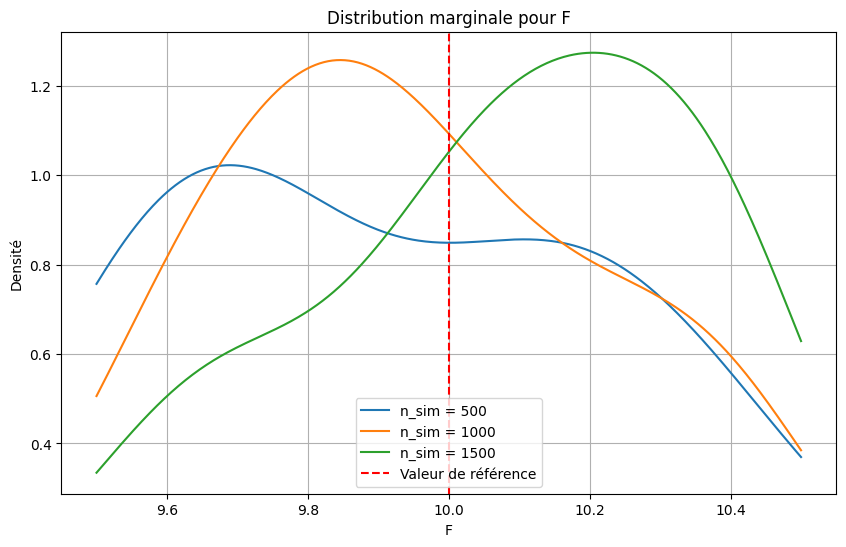

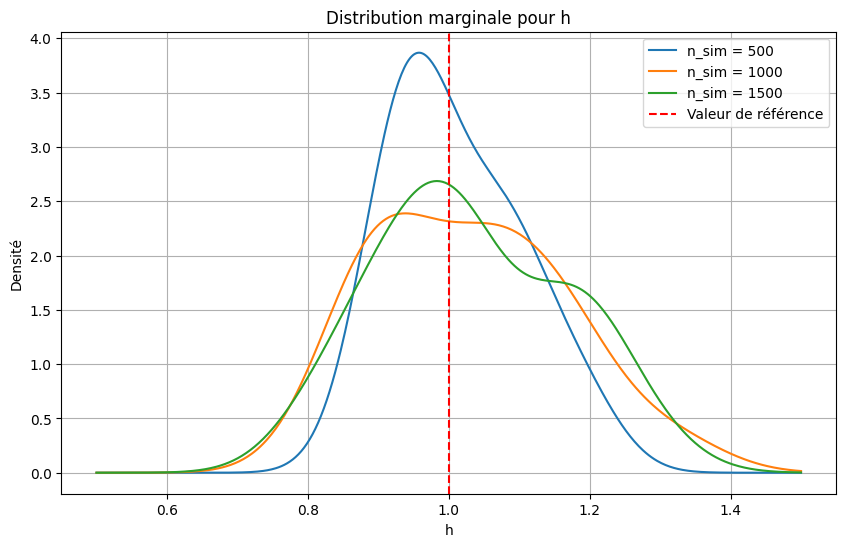

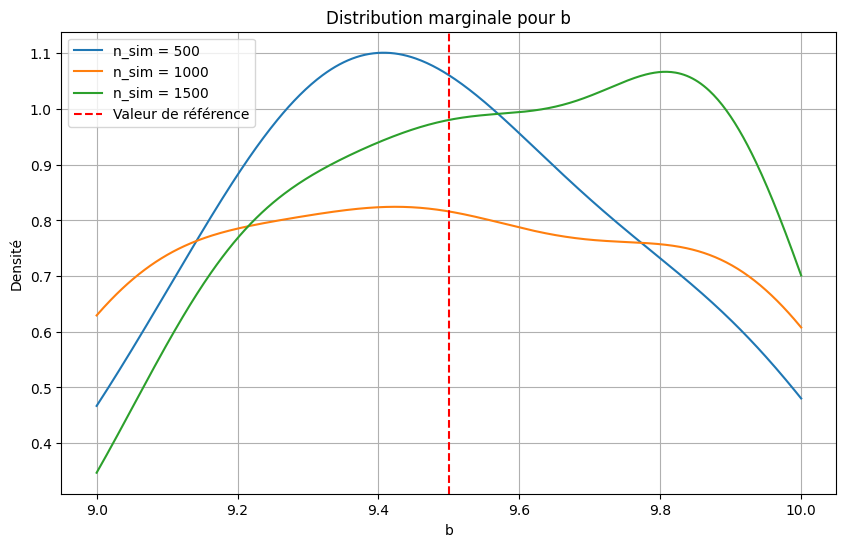

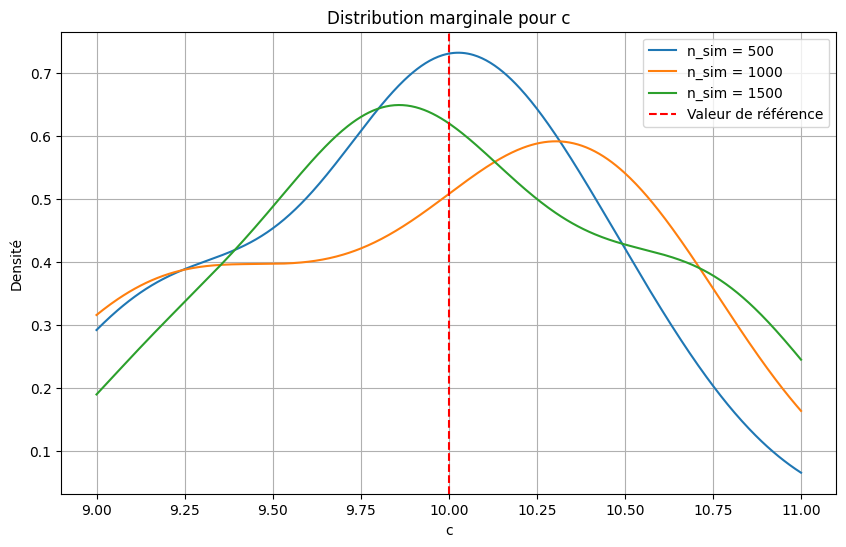

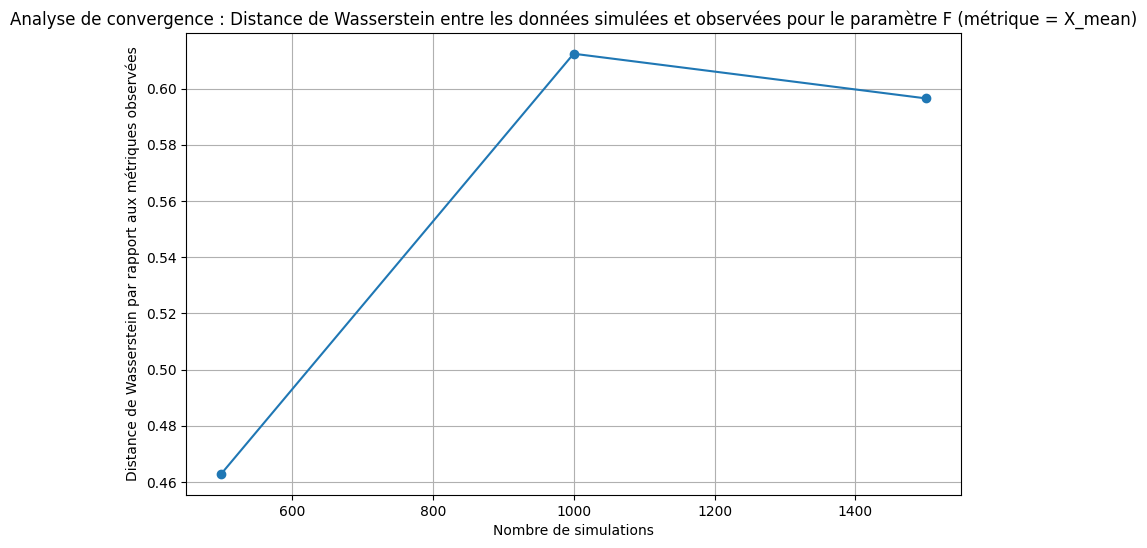

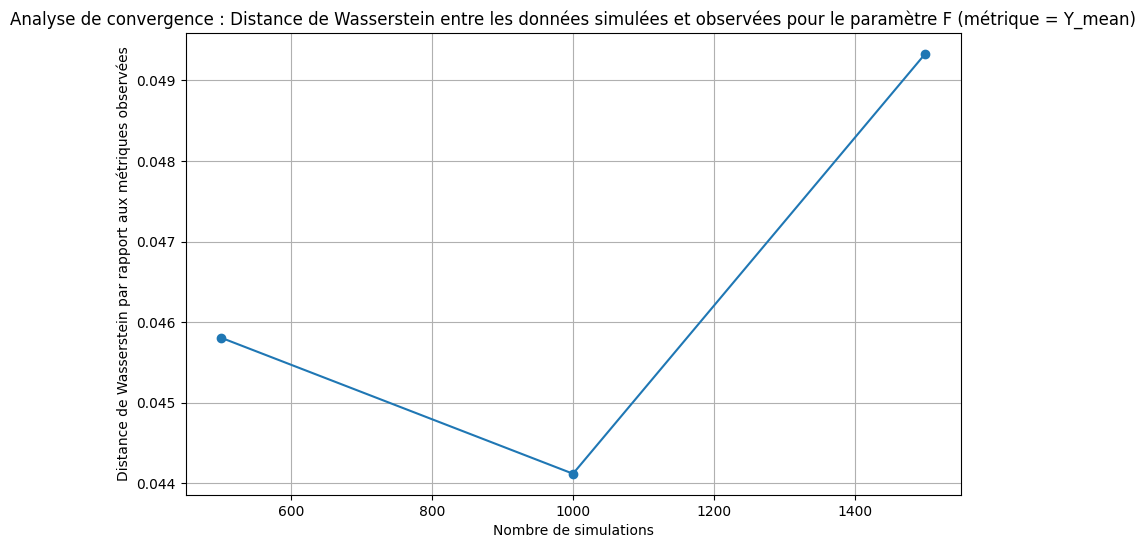

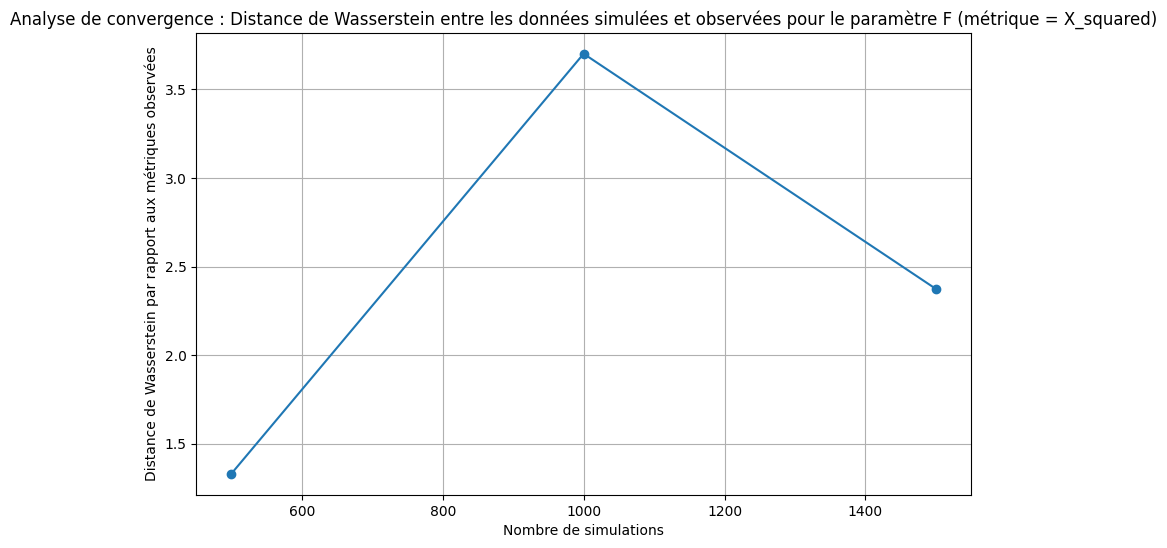

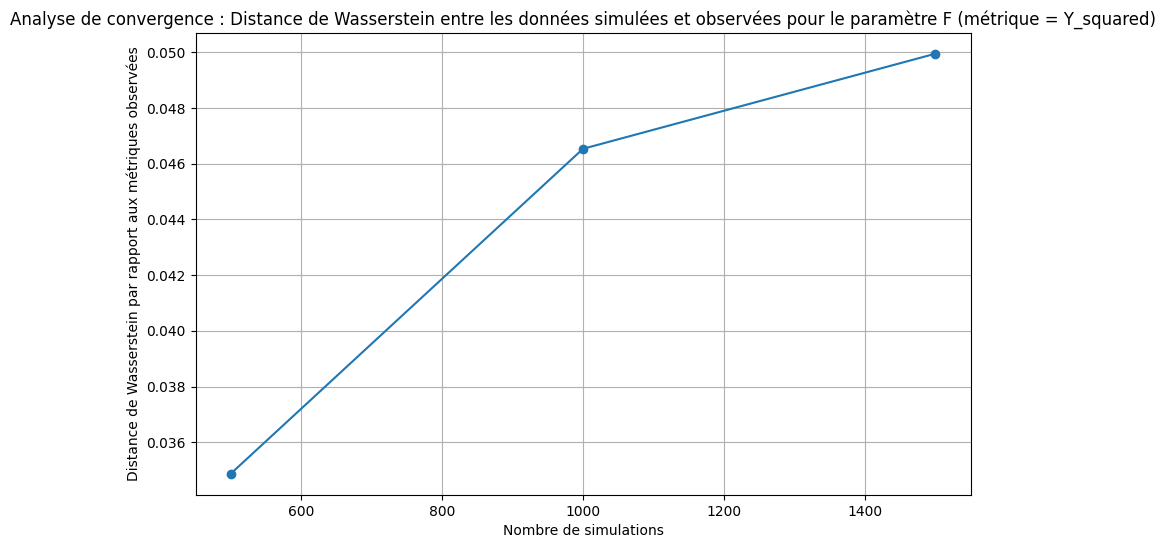

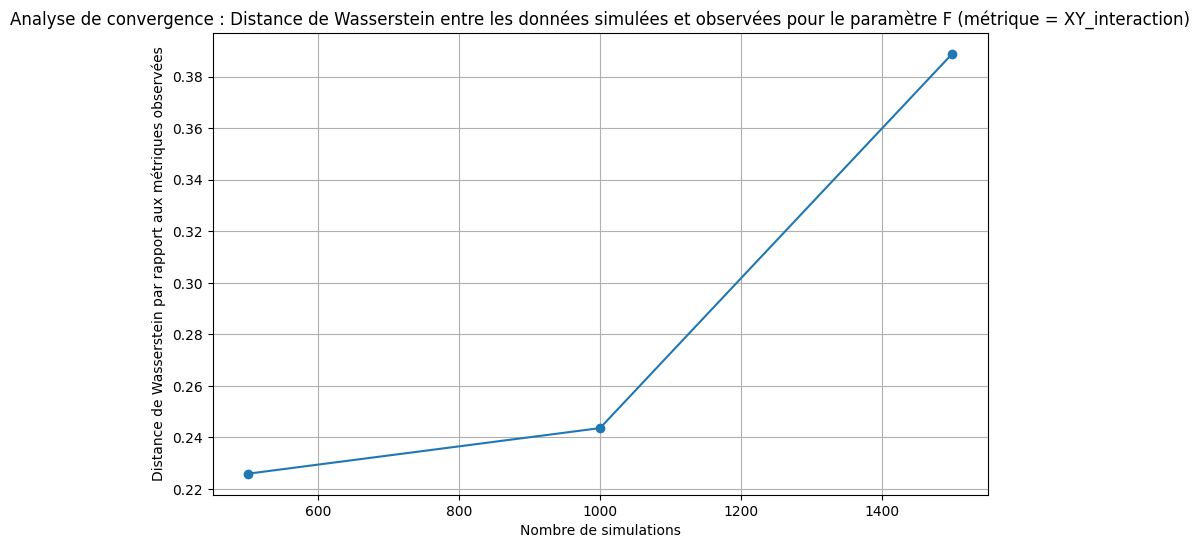

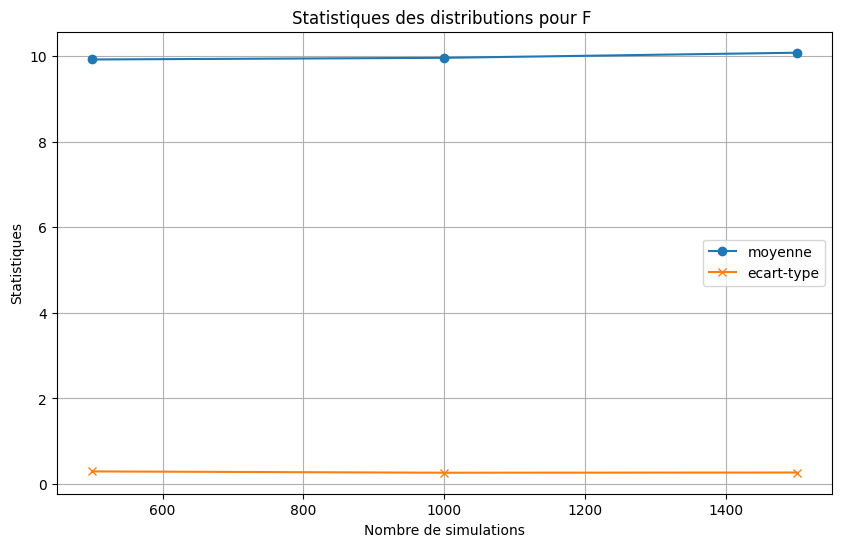

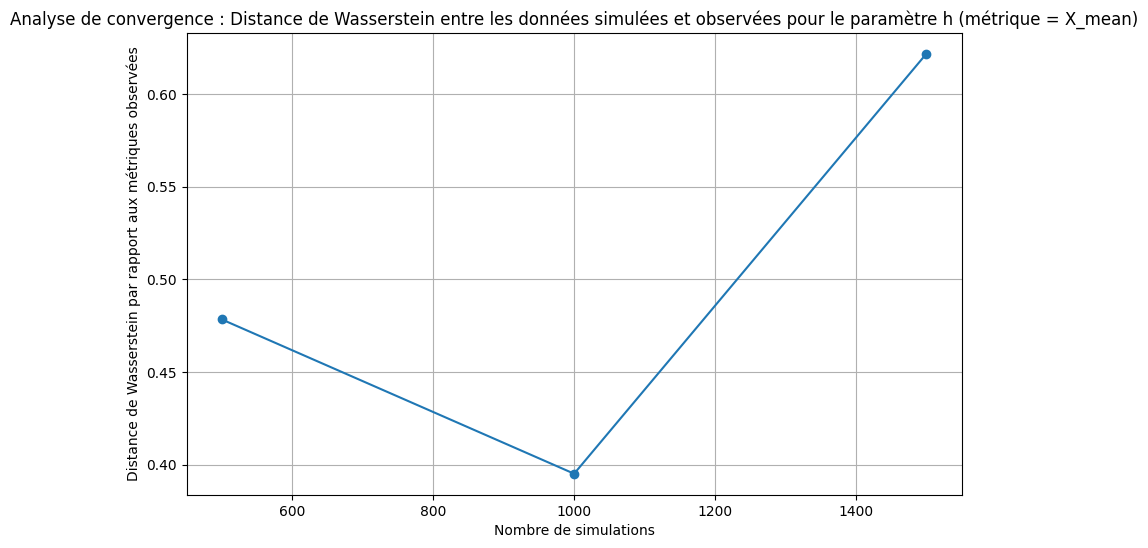

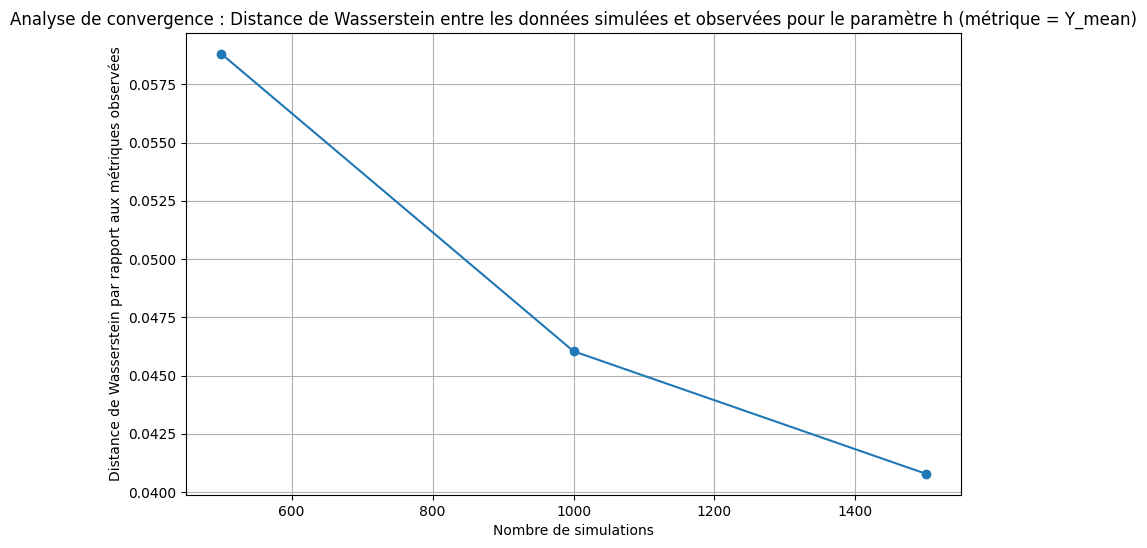

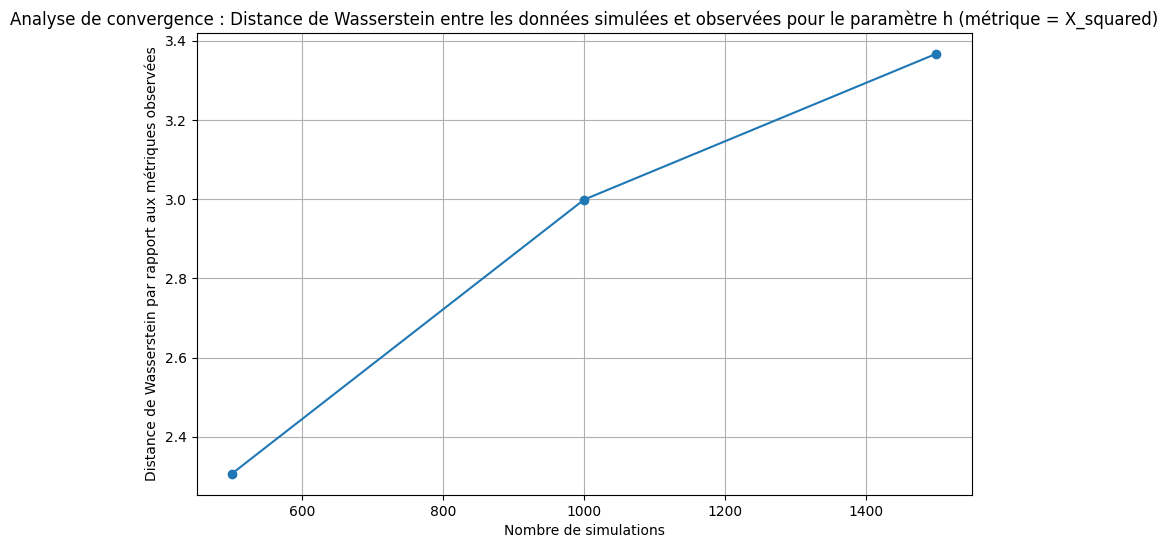

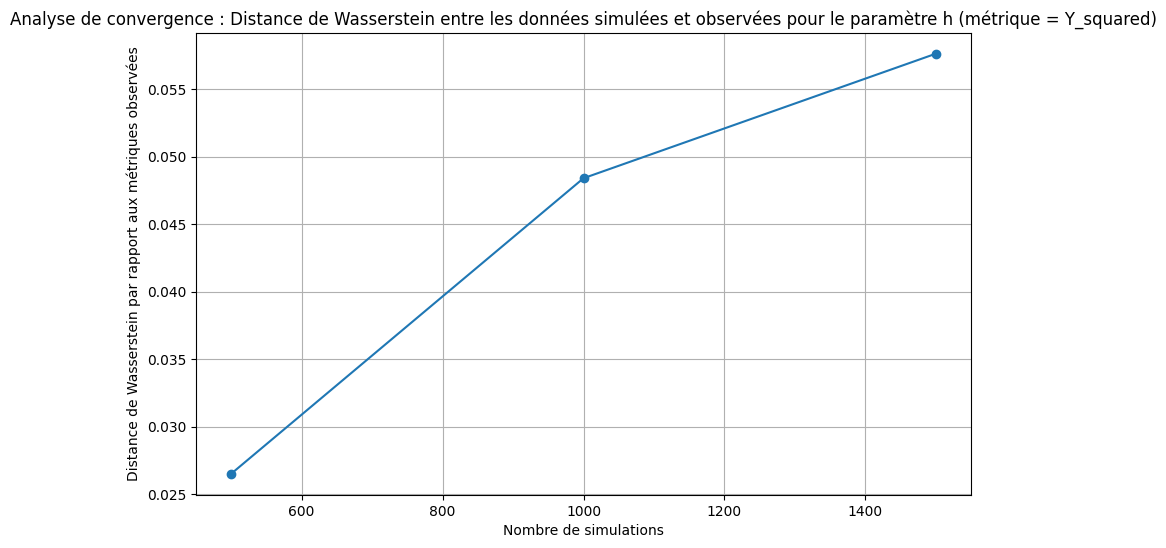

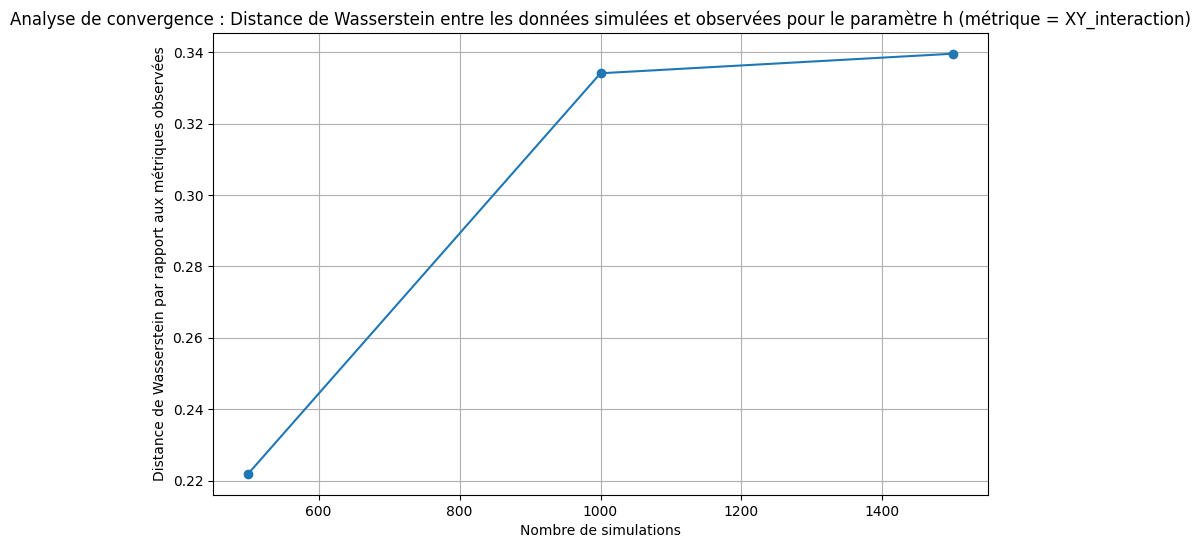

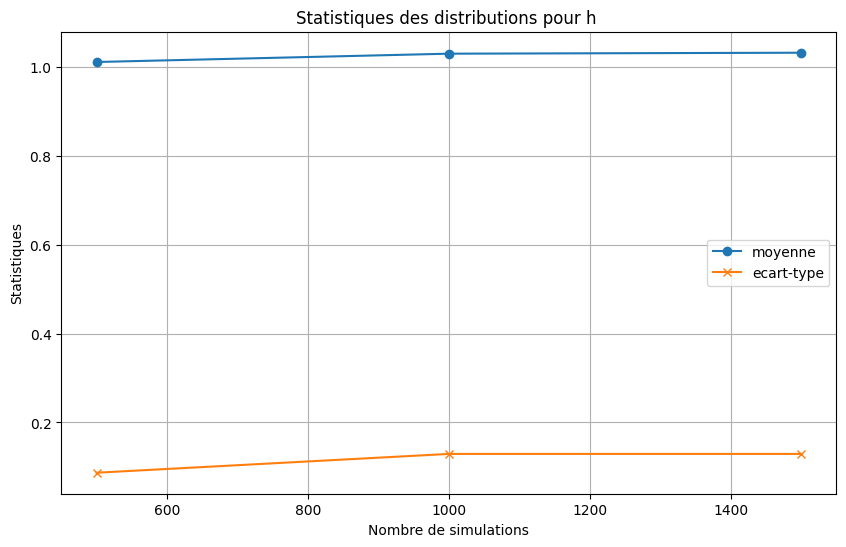

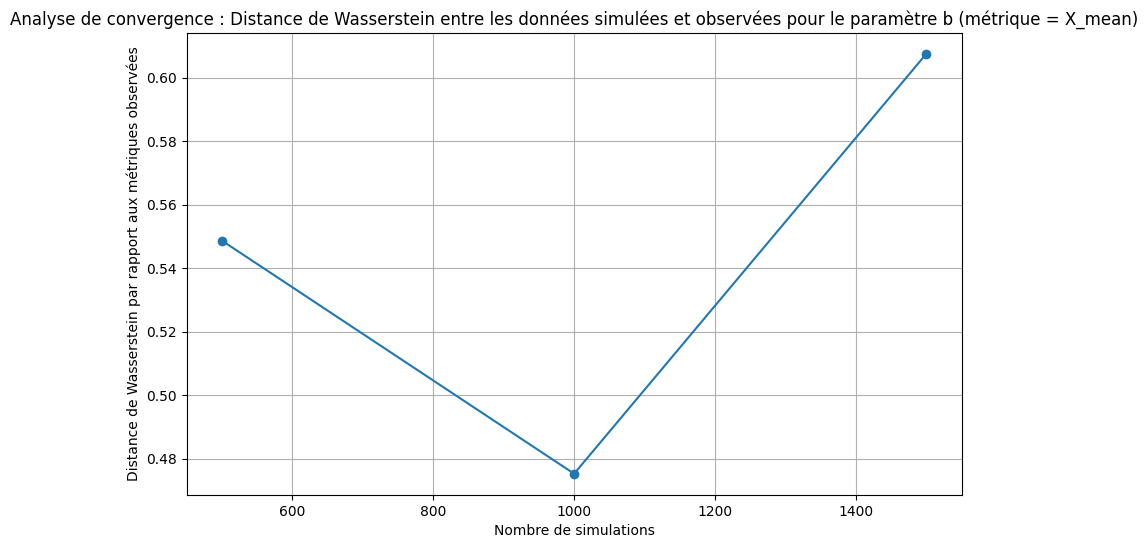

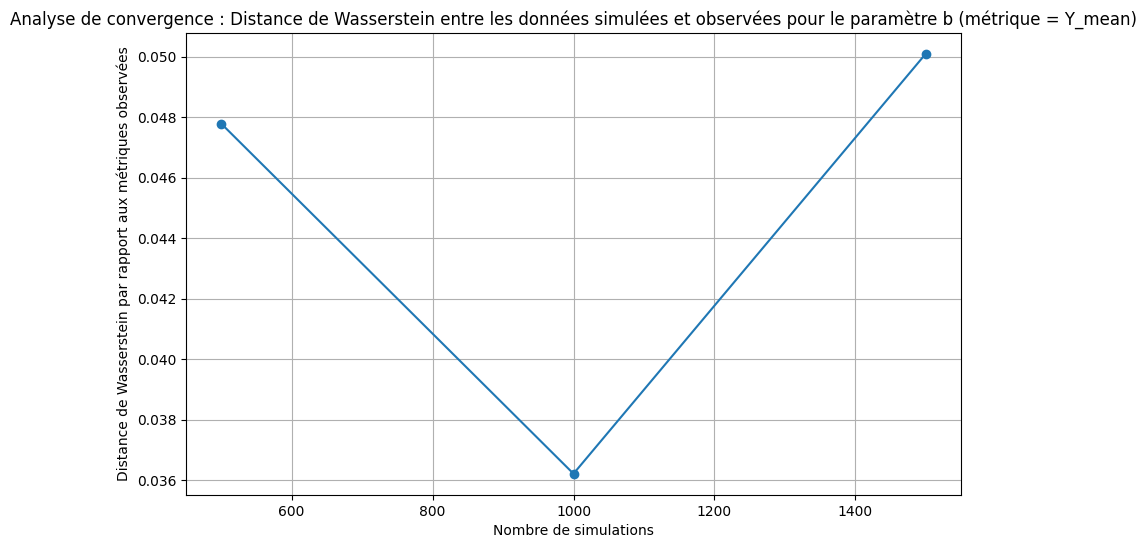

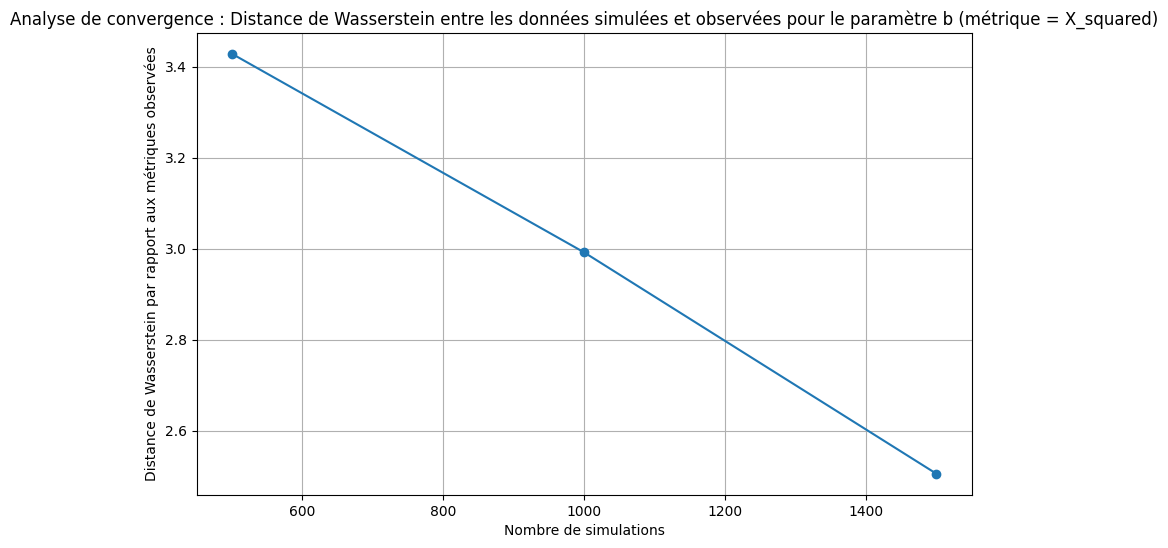

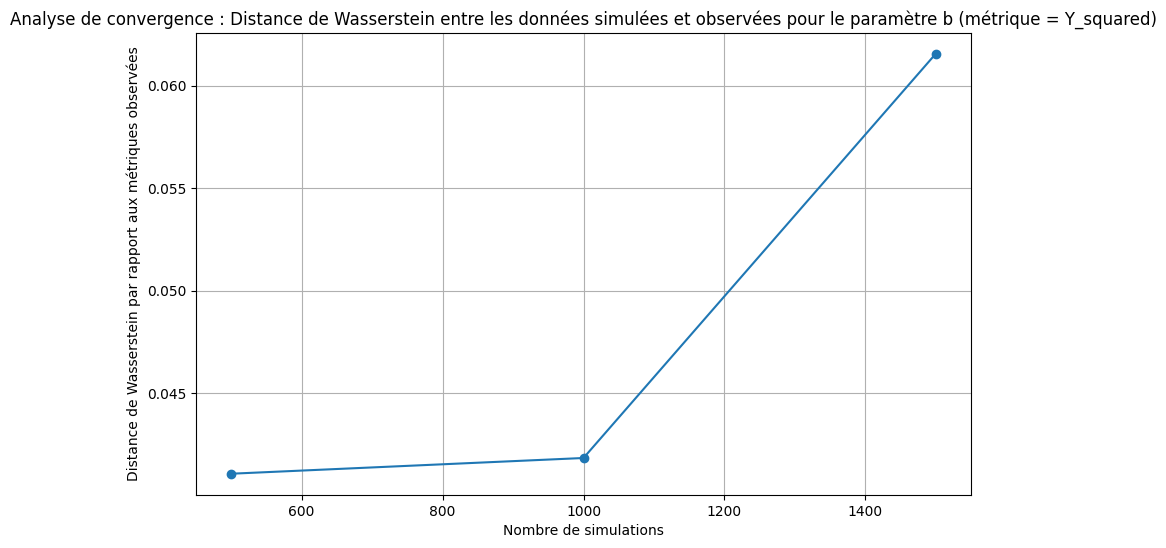

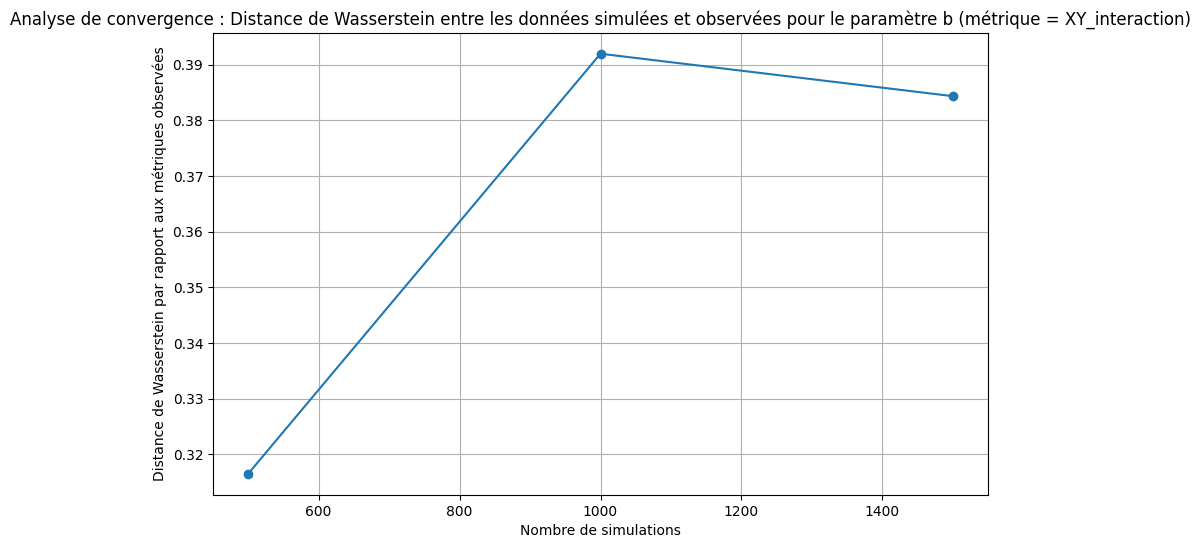

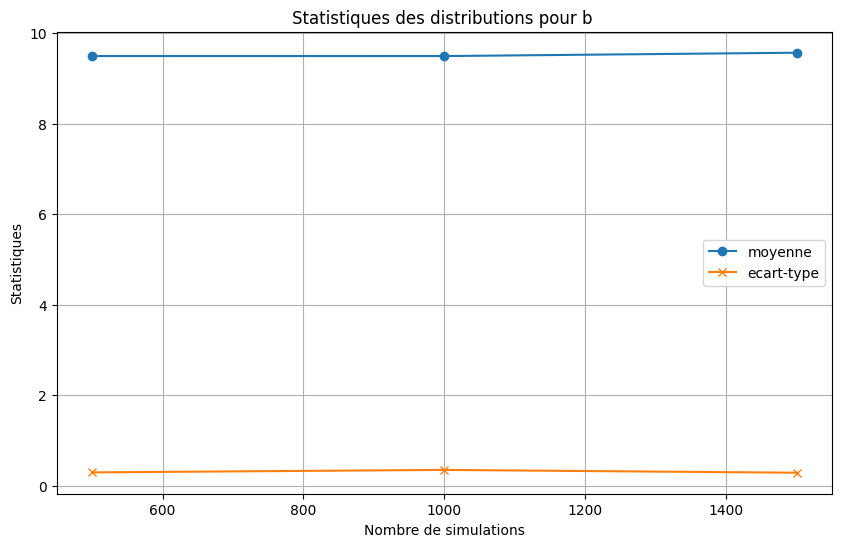

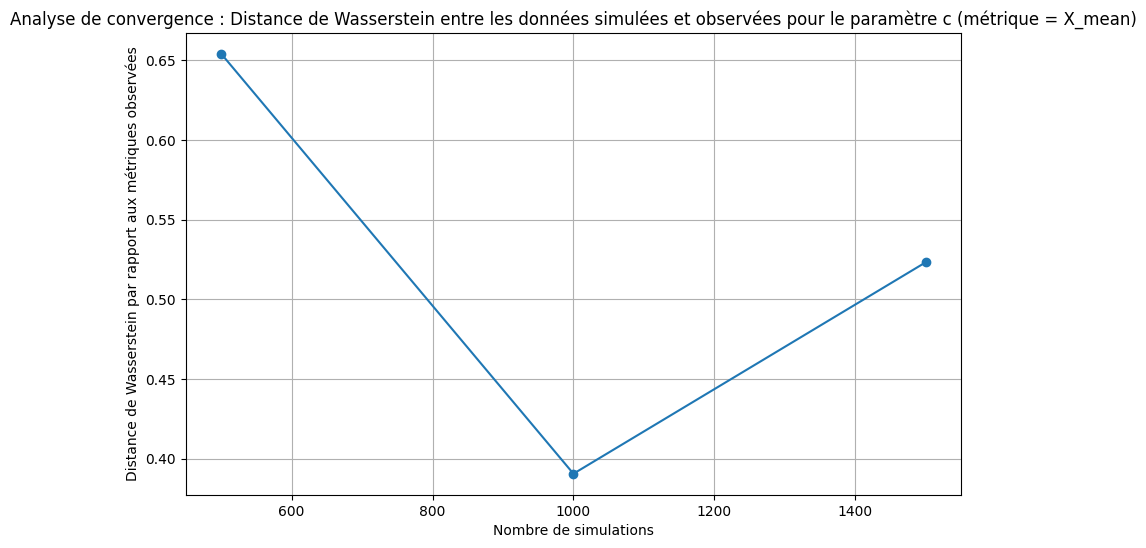

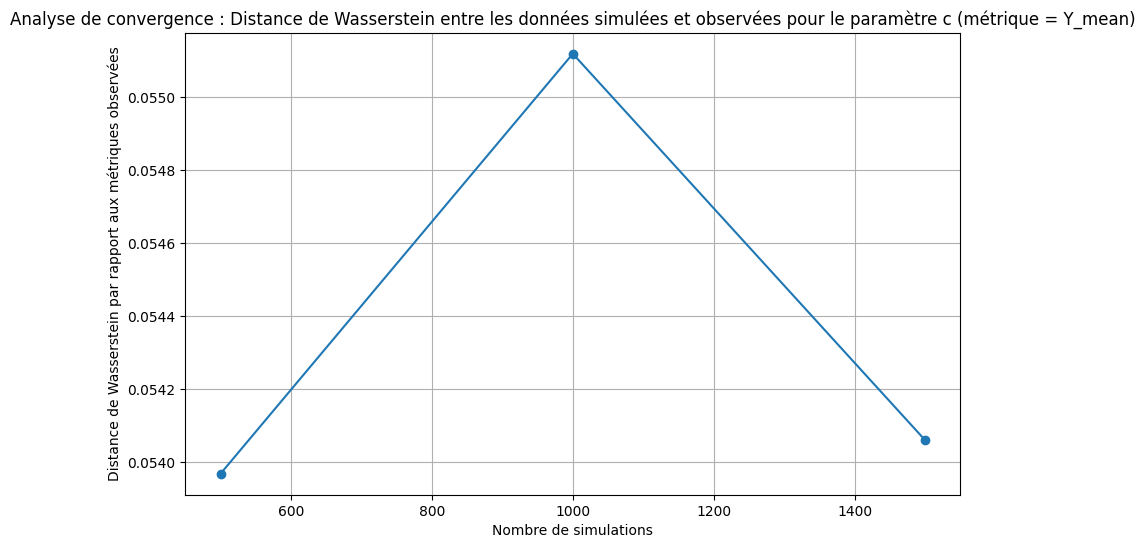

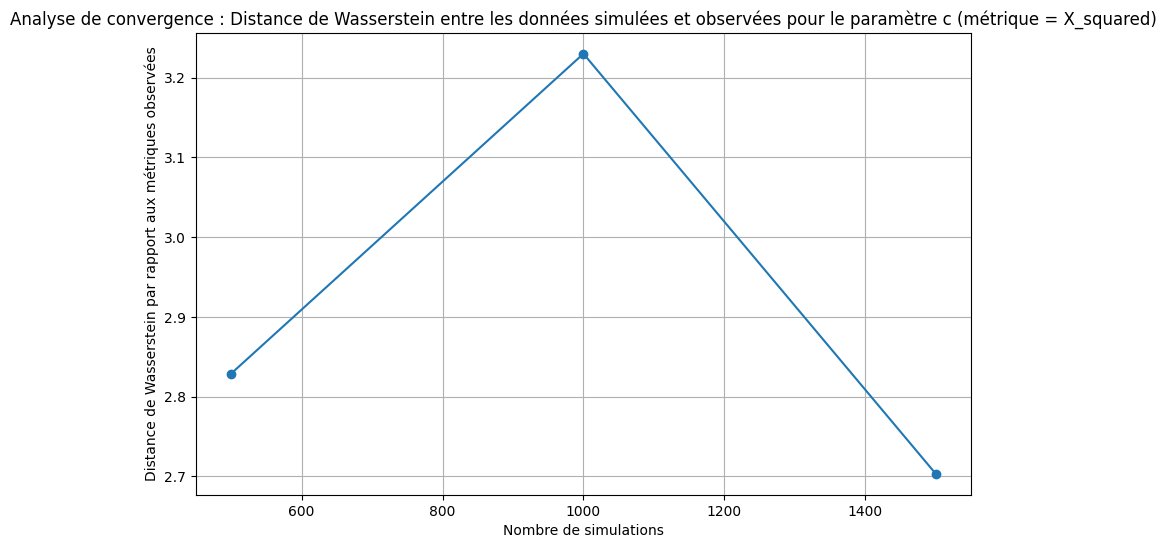

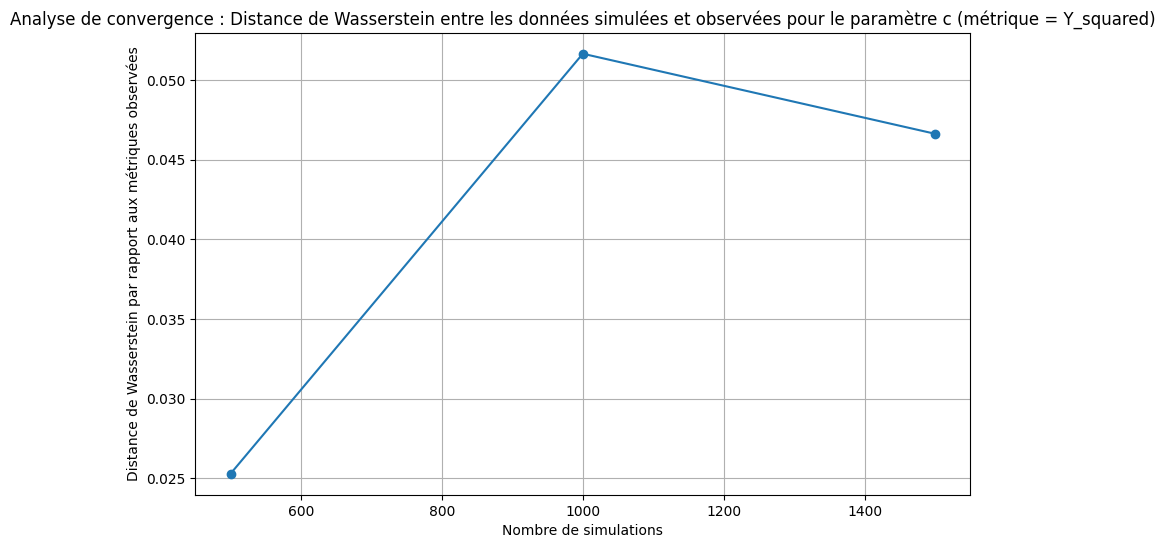

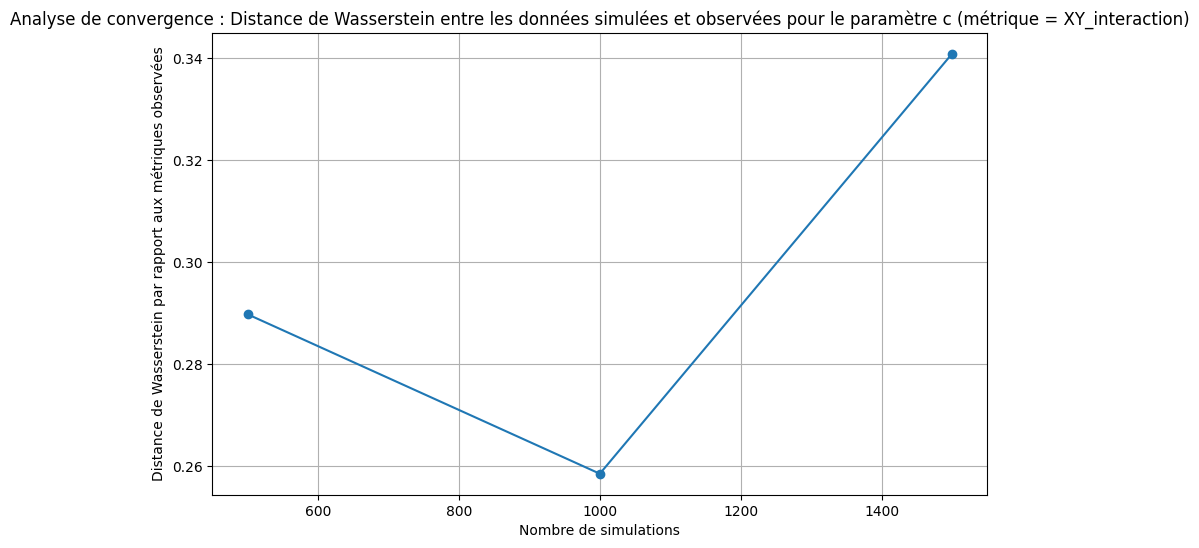

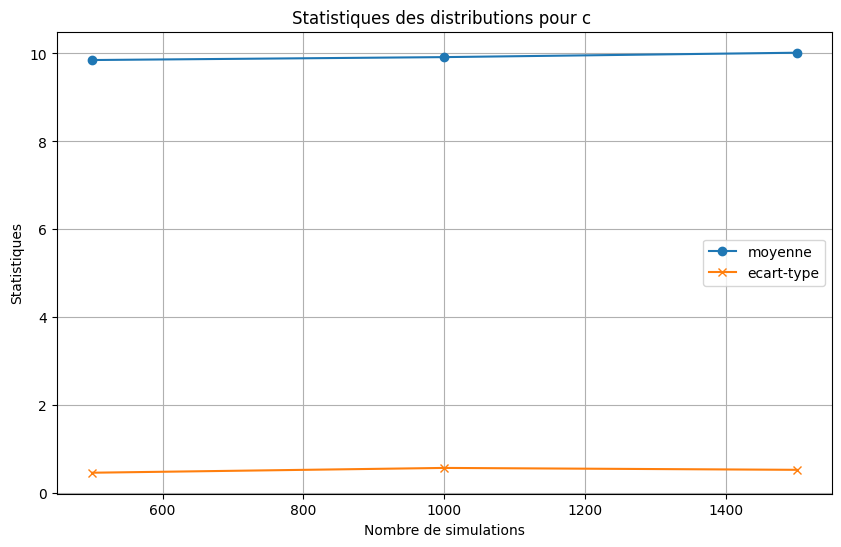

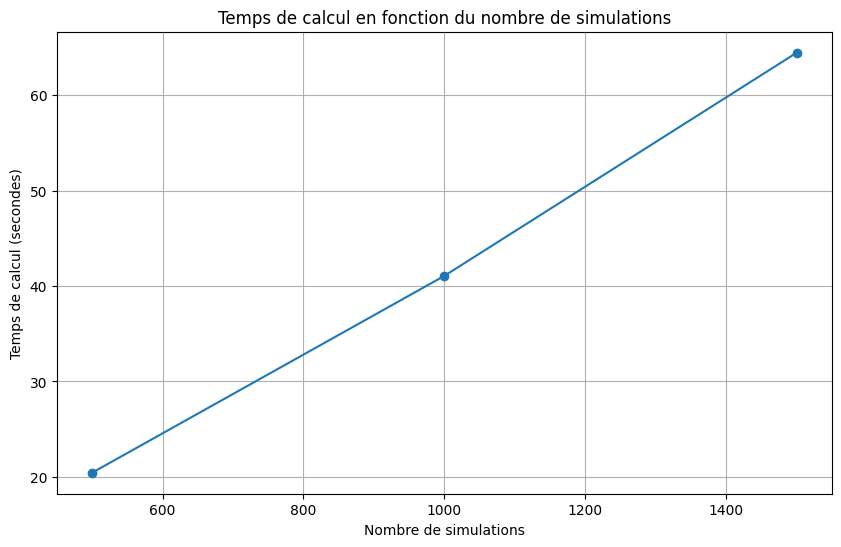

In [28]:
epsilon = 0.5
n_simulations_values = [500, 1000,1500]
#n_simulations_values = [100, 500, 1000,1500, 2000,3000, 5000, 7000,10000]

# --- Lancer l'analyse ---
results = analyze_simulation_number(priors, metrics_obs, epsilon, n_simulations_values, theta_ref)


### Observations Générales

- **Comportement Non-Monotone :** La distance de Wasserstein ne diminue pas de façon monotone avec l'augmentation du nombre de simulations. Au lieu de cela, elle montre une forte fluctuation.

- **Fortes Oscillations :** Le graphique présente des oscillations importantes, surtout aux faibles nombres de simulation.

- **Tendance à la stabilisation :** À partir de 2000 simulations, la distance se stabilise relativement, même si elle montre encore des oscillations (notamment entre 5000 et 7000 simulations).

- **Niveaux de Distance Élevés :** Les valeurs de la distance de Wasserstein restent relativement élevées. Même à 10 000 simulations, elle se situe autour de 0.67, ce qui n'est pas très proche de 0.

### Interprétation Rapide

- **Convergence difficile :** Le comportement non-monotone et les fortes oscillations suggèrent que l'algorithme ABC a du mal à converger pour ce paramètre (F) en particulier. Cela indique qu'il y a une difficulté à trouver les valeurs du paramètre qui permettent de bien reproduire la valeur observée de la métrique X_mean.

- **Exploration insuffisante de l'espace des paramètres :** Les oscillations pourraient indiquer que l'algorithme ABC ne réussit pas à explorer l'espace des paramètres de manière optimale, et donc qu'il a du mal à trouver des paramètres qui soient à la fois précis et robustes. Les fluctuations pourraient indiquer que les régions de l'espace des paramètres explorées par la méthode ABC ne convergent pas vers une solution stable.

- **Besoin de plus de simulations et d'autres approches :** Le fait que la distance ne descende pas significativement et se stabilise autour de 0.67 même avec un nombre de simulations assez élevé, suggère qu'il faudrait probablement augmenter encore le nombre de simulations et/ou explorer d'autres approches.

### En résumé :

- **Problème de convergence :** L'algorithme ABC ne converge pas de manière stable. La métrique simulée n'arrive pas à bien reproduire la métrique observée, même avec 10 000 simulations.

### Actions nécessaires :

- Il faut augmenter le nombre de simulations, si les performances du calcul le permettent.
- Il faut explorer des méthodes d'ABC plus sophistiquées.
- Il faut explorer d'autres métriques et faire une analyse de sensibilité.
- Il faut analyser les distributions a posteriori pour voir si elles présentent des problèmes (non-convergence, multimodales, instabilité...).

Ce graphique indique clairement que l'algorithme ABC rencontre des difficultés avec ce paramètre et cette métrique, et qu'il faudrait revoir certains aspects de ton approche. N'hésite pas si tu as d'autres questions !

## Interprétation Rapide des Graphiques de Convergence (ABC Rejection)

### Graphiques des Densités (Distributions Marginales)

- **Stabilisation de la forme :** On observe comment les distributions de probabilité des paramètres évoluent avec le nombre de simulations (n_sim). On cherche à ce que la forme de la distribution (sa densité) se stabilise (la courbe ne change plus beaucoup). Cela indique que l'estimation du paramètre par l'algorithme ABC converge vers une solution stable.

- **Forme de la distribution :** On observe aussi la forme des distributions. Une distribution resserrée autour d'une valeur de référence indique une plus grande certitude de l'estimation du paramètre. Si la distribution est étalée ou multimodale, cela indique une plus grande incertitude.

### Graphiques de la Distance de Wasserstein

- **Diminution :** La distance de Wasserstein diminue lorsque les distributions de métriques simulées se rapprochent de la valeur de la métrique observée. C'est un signe positif de convergence de l'ABC.

- **Stabilisation :** La distance se stabilise lorsque l'algorithme atteint un certain niveau de précision et qu'il n'y a plus beaucoup d'amélioration à ajouter de simulations.

- **Augmentation ou Oscillations :** Cela indique un problème de convergence (souvent dû à une mauvaise exploration de l'espace des paramètres ou à la non-identifiabilité) et nécessite plus d'analyses ou des modifications à l'algorithme.

### Graphiques de la Moyenne et de l'Écart-type

- **Stabilisation de la moyenne :** La valeur moyenne du paramètre se stabilise, ce qui indique que le centre de la distribution devient plus stable.

- **Diminution de l'écart-type :** L'incertitude sur le paramètre diminue et les distributions deviennent plus précises, avec une dispersion moindre.

- **Pas de diminution ou de stabilisation de l'écart-type :** Indique une incertitude toujours forte sur le paramètre, même si la moyenne est stable.

### Graphique du Temps de Calcul

- **Augmentation :** Le temps de calcul augmente avec le nombre de simulations, ce qui est normal.

- **Compromis :** On cherche un équilibre entre une bonne précision (convergence) et un temps de calcul raisonnable.

### En Résumé :

- **Convergence :** On cherche à voir :
  - Les densités des paramètres (graphique des densités) se stabiliser.
  - La distance de Wasserstein diminuer et se stabiliser.
  - La moyenne et l'écart-type des paramètres se stabiliser également.

- **Non-convergence :** Si les courbes de la distance de Wasserstein oscillent ou augmentent, ou que les densités changent avec l'augmentation du nombre de simulations, cela indique un problème.

- **Compromis :** Il faut tenir compte du temps de calcul et du nombre de simulations, car augmenter le nombre de simulations améliore la convergence, mais aussi augmente le temps de calcul.



## 1. Graphe de la Distance de Wasserstein

### Ce qu'il montre :
Ce graphique affiche la distance de Wasserstein entre la distribution a posteriori obtenue avec une certaine valeur de n_sim et la distribution a posteriori obtenue avec la plus petite valeur de n_sim. Il est tracé pour chaque paramètre.

### Interprétation :

- **Diminution (tendance à la baisse) :**
  - Une diminution de la distance de Wasserstein à mesure que n_sim augmente signifie que la distribution a posteriori se rapproche de la distribution de référence. Cela indique que l'estimation du paramètre s'améliore avec un nombre plus élevé de simulations.
  - Une forte diminution au début suggère que les premières simulations améliorent rapidement la distribution.
  - Une diminution plus lente par la suite suggère que l'ajout de simulations supplémentaires apporte des améliorations plus marginales.

- **Stabilisation (atteinte d'un plateau) :**
  - Une stabilisation de la distance de Wasserstein (la courbe devient horizontale) signifie que la distribution a posteriori a cessé de changer significativement. Cela indique que l'algorithme ABC a probablement convergé et que l'ajout de simulations supplémentaires n'apportera plus beaucoup d'informations supplémentaires.
  - La valeur à laquelle la distance se stabilise peut être interprétée comme l'incertitude résiduelle de l'estimation du paramètre.

- **Augmentation ou Oscillations :**
  - Une augmentation de la distance de Wasserstein, ou des oscillations dans la courbe, pourraient indiquer un problème de convergence. Cela pourrait signifier que :
    - L'algorithme ABC a besoin d'encore plus de simulations pour converger.
    - Le choix de la fonction de distance n'est pas optimal.
    - Il y a un problème d'identifiabilité (plusieurs combinaisons de paramètres qui produisent les mêmes résultats).
    - Le modèle est trop simple pour reproduire les données d'observation.

**En résumé :** L'objectif de ce graphique est de voir comment la distribution obtenue avec le minimum de simulations est améliorée avec l'augmentation du nombre de simulations. Si la distance de Wasserstein diminue et se stabilise, c'est un bon signe que l'ABC converge bien.

## 2. Graphes de la Moyenne et de l'Écart-Type

### Ce qu'ils montrent :
Ces graphiques affichent comment la moyenne et l'écart-type de la distribution a posteriori (pour chaque paramètre) évoluent avec le nombre de simulations n_sim.

### Interprétation :

- **Stabilisation de la moyenne :**
  - Une stabilisation de la moyenne à mesure que n_sim augmente indique que la valeur centrale de la distribution a posteriori devient plus stable et qu'elle converge vers une valeur spécifique.
  - Une moyenne qui continue à changer avec l'augmentation du nombre de simulations indique que la distribution n'est pas stable et que des simulations supplémentaires pourraient être nécessaires.

- **Diminution de l'écart-type :**
  - Une diminution de l'écart-type à mesure que n_sim augmente signifie que la distribution a posteriori devient plus concentrée et que l'incertitude de l'estimation diminue. Cela indique une plus grande précision dans l'estimation du paramètre.
  - Une stabilisation de l'écart-type signifie que l'incertitude est minimisée, et qu'il n'y a pas beaucoup de gain à ajouter des simulations supplémentaires.
  - Un écart-type qui ne diminue pas beaucoup indique que l'estimation du paramètre est incertaine.

- **Relation entre la moyenne et l'écart-type :**
  - Il est important d'analyser comment la moyenne et l'écart-type évoluent ensemble.
  - Si la moyenne se stabilise et que l'écart-type diminue, c'est un bon signe de convergence.
  - Si l'écart-type est toujours important, même si la moyenne se stabilise, cela indique que l'estimation est toujours incertaine.

**En résumé :** L'objectif de ces graphiques est de voir si la distribution a posteriori converge vers une valeur centrale (la moyenne) avec une faible incertitude (l'écart-type).

## Interprétation Combinée

Il est important de ne pas interpréter ces graphiques séparément, mais de les analyser ensemble. Par exemple :

- Si la distance de Wasserstein diminue et que l'écart-type diminue aussi, cela confirme que l'algorithme ABC converge correctement.
- Si la distance de Wasserstein se stabilise mais que l'écart-type ne diminue pas, cela indique que l'incertitude de l'estimation ne diminue pas beaucoup, même si la distribution a posteriori est stable.
- Si la distance de Wasserstein augmente ou oscille, et que la moyenne et l'écart-type varient, cela suggère un problème de convergence qui nécessite d'autres analyses ou plus de simulations.

En analysant attentivement ces graphiques, tu pourras évaluer l'efficacité de ton implémentation de l'ABC Rejection, et choisir un n_sim qui te donne un bon compromis entre précision des résultats et temps de calcul.

N'hésite pas à me poser des questions si certains points restent obscurs. Je suis là pour t'aider à interpréter correctement tes résultats.

In [ ]:
# Copyright 2025 ensai
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



### **IV/ Analyse de sensibilité : Pour identifier les paramètres importants.**





## 1. Analyse de Sensibilité Locale (avec des dérivées)

**Principe :** On étudie comment les métriques calculées (à partir des sorties du modèle) varient quand on modifie légèrement la valeur d'un seul paramètre (F, h, b ou c), en laissant les autres paramètres constants. On évalue les dérivées partielles des métriques par rapport aux paramètres.

**Comment faire (approche numérique) :**

### Valeurs de référence des paramètres :

Tu utilises une valeur de référence pour les paramètres F, h, b et c (par exemple, les valeurs dans `theta_ref` ou la moyenne des paramètres acceptés par l'ABC).

```python
theta_ref = {"F": 10, "h": 1, "b": 10, "c": 10}  # exemple
T = 10
dt = 0.01
```

### Simulation avec les paramètres de référence :

Tu simules le modèle avec `lorenz96_two_equations`, en utilisant `theta_ref`. Tu obtiens ainsi des données `X_ref` et `Y_ref` et tu les passes à la fonction `calculate_metrics` qui va retourner un dictionnaire `metrics_ref`.

```python
X_obs, Y_obs = lorenz96_two_equations(**theta_ref, T=T, dt=dt)
metrics_obs = calculate_metrics(X_ref, Y_ref, tau=T)
```


In [29]:
X_obs


array([ 5.18531383e+00, -1.38523129e+00,  7.64763002e+00,  1.45886245e-01,
        6.01369253e+00,  4.82136777e+00,  2.49504360e+00, -3.41470747e+00,
       -1.57061891e+00,  8.92223706e+00,  6.48446209e-01, -4.18573411e-01,
        5.05057845e+00, -6.35799834e+00,  3.63500788e-01, -1.85518332e+00,
        6.27219485e+00,  3.89703532e+00, -3.14189370e+00,  5.06777904e+00,
        1.99422583e+00,  1.10025267e+00,  3.07795281e-03, -1.81700519e+00,
       -9.51462265e-01,  3.26071698e+00, -1.94190988e+00,  9.55072506e+00,
        5.25967091e-01,  3.53997333e+00,  1.25158508e-01,  2.78466302e+00,
       -3.47466408e+00,  6.37390704e+00, -1.01467786e+00,  9.29025066e+00])

In [82]:
Y_obs

array([[-0.29404131, -0.29404131, -0.29404131, -0.29404131, -0.29404131,
        -0.29404131, -0.29404131, -0.29404131, -0.29404131, -0.29404131],
       [ 0.46106542,  0.46106542,  0.46106542,  0.46106542,  0.46106542,
         0.46106542,  0.46106542,  0.46106542,  0.46106542,  0.46106542],
       [-0.46895635, -0.46895635, -0.46895635, -0.46895635, -0.46895635,
        -0.46895635, -0.46895635, -0.46895635, -0.46895635, -0.46895635],
       [ 0.50555912,  0.50555912,  0.50555912,  0.50555912,  0.50555912,
         0.50555912,  0.50555912,  0.50555912,  0.50555912,  0.50555912],
       [-0.08358649, -0.08358652, -0.08358649, -0.08358652, -0.08358649,
        -0.08358652, -0.08358649, -0.08358652, -0.08358649, -0.08358652],
       [-0.44539232, -0.44539232, -0.44539232, -0.44539232, -0.44539232,
        -0.44539232, -0.44539232, -0.44539232, -0.44539232, -0.44539232],
       [ 0.6037008 ,  0.6037008 ,  0.6037008 ,  0.6037008 ,  0.6037008 ,
         0.6037008 ,  0.6037008 ,  0.6037008 

In [83]:
metrics_obs

{'X_mean': np.float64(1.114942533178025),
 'Y_mean': np.float64(0.14591871885494134),
 'X_squared': np.float64(18.197732873404046),
 'Y_squared': np.float64(0.1960240266770987),
 'XY_interaction': np.float64(1.7039823922365704)}

### 1-Perturbation d'un paramètre à la fois :

Pour chaque paramètre (F, h, b, et c), tu vas modifier sa valeur en ajoutant une petite perturbation. Par exemple, pour le paramètre F :

### 2- Simulation avec le paramètre perturbé :

Tu simules le modèle à nouveau en utilisant `theta_perturb`. Tu obtiens des données `X_perturb` et `Y_perturb` et tu les passes à la fonction `calculate_metrics` qui va retourner un dictionnaire `metrics_perturb`.

### 3-Calcul des dérivées :

Pour chaque métrique que tu calcules, tu évalues la dérivée partielle par rapport au paramètre que tu as perturbé. Par exemple, pour la métrique `X_mean` :


In [30]:
def local_sensitivity_analysis(priors, metrics_obs, T=10, dt=0.01):
   """
   Effectue une analyse de sensibilité locale en calculant les dérivées des métriques par rapport aux paramètres.

   Paramètres :
   -----------
   priors : dict
       Dictionnaire contenant les valeurs de référence des paramètres (F, h, b, c).
   metrics_obs : dict
        Dictionnaire contenant les valeurs des métriques observées.
   T : float, optionnel
       Temps total de simulation (défaut : 10).
   dt : float, optionnel
       Pas de temps pour la simulation (défaut : 0.01).

   Retourne :
   ---------
   dict :
       Un dictionnaire contenant les dérivées des métriques pour chaque paramètre.
   """
   param_names = ["F", "h", "b", "c"]
   metric_names = ["X_mean", "Y_mean", "X_squared", "Y_squared", "XY_interaction"]
   deriv_all = {}

   # Calcul des métriques avec les paramètres de référence
   priors_ref = {param_name : (priors[param_name][0] + priors[param_name][1] )/2 for param_name in priors} # New, to get the middle of each prior
   X_ref, Y_ref = lorenz96_two_equations(**priors_ref, T=T, dt=dt)
   metrics_ref = calculate_metrics(X_ref, Y_ref, tau=T)

   # Pour chaque paramètre
   for param_name in param_names:
       deriv_metric = {}
       # Perturbation du paramètre
       perturbation = 0.01 * priors_ref[param_name]  # Perturbation de 1% de la valeur du paramètre.
       theta_perturb = priors_ref.copy()
       theta_perturb[param_name] += perturbation

       # Calcul des métriques avec le paramètre perturbé
       X_perturb, Y_perturb = lorenz96_two_equations(**theta_perturb, T=T, dt=dt)
       metrics_perturb = calculate_metrics(X_perturb, Y_perturb, tau=T)

       # Calcul des dérivées pour chaque métrique
       for metric_name in metric_names:
         deriv_metric[metric_name] = (metrics_perturb[metric_name] - metrics_ref[metric_name]) / perturbation
       deriv_all[param_name] = deriv_metric

   return deriv_all

In [87]:
priors

{'F': (9.5, 10.5), 'h': (0.5, 1.5), 'b': (9.0, 10.0), 'c': (9.0, 11.0)}

In [31]:
T = 10
dt = 0.01

    # Appel de la fonction pour faire l'analyse de sensibilité locale
deriv_all = local_sensitivity_analysis(priors, metrics_obs, T, dt)

    # Affichage des résultats
param_names = ["F", "h", "b", "c"]
metric_names = ["X_mean", "Y_mean", "X_squared", "Y_squared", "XY_interaction"]
for param_name in param_names:
    print(f"Analyse de sensibilité locale pour le paramètre {param_name}:")
    for metric_name in metric_names:
            print(f"  - Derivée de la metrique {metric_name}: {deriv_all[param_name][metric_name]}")
            
            
            

Analyse de sensibilité locale pour le paramètre F:
  - Derivée de la metrique X_mean: 5.392893111485093
  - Derivée de la metrique Y_mean: 0.4217799710893014
  - Derivée de la metrique X_squared: 47.72646323215703
  - Derivée de la metrique Y_squared: 0.358960065564414
  - Derivée de la metrique XY_interaction: 3.1801141356482687
Analyse de sensibilité locale pour le paramètre h:
  - Derivée de la metrique X_mean: 107.96986087758631
  - Derivée de la metrique Y_mean: 8.686311670984068
  - Derivée de la metrique X_squared: 463.17363363546883
  - Derivée de la metrique Y_squared: 4.101047581716097
  - Derivée de la metrique XY_interaction: 42.141008258223266
Analyse de sensibilité locale pour le paramètre b:
  - Derivée de la metrique X_mean: 19.959020195503978
  - Derivée de la metrique Y_mean: 1.6583592014145496
  - Derivée de la metrique X_squared: 65.43054980874646
  - Derivée de la metrique Y_squared: 0.39021211261706595
  - Derivée de la metrique XY_interaction: 4.880658638006742
A


## Principes de l'Interprétation

- **Dérivées :** Ces chiffres représentent l'influence locale (autour de la valeur de référence des paramètres) des paramètres sur les métriques. Ce sont des dérivées partielles. Plus la valeur absolue de la dérivée est grande, plus le paramètre a une influence sur la métrique. Le signe de la dérivée indique si l'influence est positive ou négative.
- **Paramètres :** F, h, b, et c sont les paramètres de ton modèle Lorenz-96.
- **Métriques :** X_mean, Y_mean, X_squared, Y_squared, et XY_interaction sont les métriques calculées sur les sorties du modèle (X et Y).

## Analyse Détaillée des Résultats

### Paramètre F :

- **X_mean :** Une dérivée positive et relativement forte (6.27) signifie que lorsque tu augmentes F, la moyenne de X (X_mean) augmente aussi. C'est une influence positive.
- **Y_mean :** Une dérivée négative (-0.09) indique que quand tu augmentes F, la moyenne de Y (Y_mean) a tendance à diminuer, mais cette influence est faible car la valeur absolue de la dérivée est faible.
- **X_squared :** Une dérivée négative (-22.96) indique que quand tu augmentes F, la métrique X_squared a tendance à diminuer, et que l'influence est relativement importante.
- **Y_squared :** Une dérivée négative (-0.29) indique que quand tu augmentes F, la métrique Y_squared a tendance à diminuer, mais que l'influence est relativement faible.
- **XY_interaction :** Une dérivée négative (-2.15) indique que quand tu augmentes F, la métrique XY_interaction a tendance à diminuer, et que l'influence est relativement importante.

**Interprétation :** Le paramètre F a une influence positive sur la moyenne de X, et a tendance à diminuer les autres métriques. L'amplitude de ces valeurs est variable, mais l'influence sur la métrique X_mean est prédominante.

### Paramètre h :

- **X_mean :** Une dérivée négative et très forte (-39.60) signifie que lorsque tu augmentes h, la moyenne de X (X_mean) a tendance à diminuer fortement. C'est une influence négative importante.
- **Y_mean :** Une dérivée négative et forte (-6.76) indique que quand tu augmentes h, la moyenne de Y (Y_mean) a tendance à diminuer fortement.
- **X_squared :** Une dérivée négative et forte (-178.63) indique que quand tu augmentes h, la métrique X_squared diminue fortement.
- **Y_squared :** Une dérivée négative (-1.97) indique que quand tu augmentes h, la métrique Y_squared a tendance à diminuer, et que l'influence est relativement forte.
- **XY_interaction :** Une dérivée négative et forte (-25.07) indique que lorsque tu augmentes h, la métrique XY_interaction a tendance à diminuer fortement.

**Interprétation :** Le paramètre h a une influence négative et forte sur toutes les métriques, avec un impact particulièrement important sur la métrique X_squared.

### Paramètre b :

- **X_mean :** Une dérivée négative (-3.21) indique que quand tu augmentes b, la moyenne de X (X_mean) a tendance à diminuer. L'influence est significative.
- **Y_mean :** Une dérivée négative (-0.24) indique que quand tu augmentes b, la moyenne de Y (Y_mean) a tendance à diminuer, mais que cette influence est faible.
- **X_squared :** Une dérivée négative (-18.05) indique que quand tu augmentes b, la métrique X_squared a tendance à diminuer.
- **Y_squared :** Une dérivée négative (-0.32) indique que quand tu augmentes b, la métrique Y_squared a tendance à diminuer, et que l'influence est faible.
- **XY_interaction :** Une dérivée négative (-3.07) indique que lorsque tu augmentes b, la métrique XY_interaction a tendance à diminuer, et que l'influence est modérée.

**Interprétation :** Le paramètre b a une influence globalement négative sur toutes les métriques, et un impact significatif sur la métrique X_mean et X_squared.

### Paramètre c :

- **X_mean :** Une dérivée positive (0.59) indique que si tu augmentes c, alors X_mean a tendance à augmenter, même si l'influence est relativement faible.
- **Y_mean :** Une dérivée positive (0.31) indique que si tu augmentes c, alors Y_mean a tendance à augmenter. L'influence est relativement faible.
- **X_squared :** Une dérivée positive (39.72) indique que si tu augmentes c, alors X_squared a tendance à augmenter. C'est une influence positive et relativement forte.
- **Y_squared :** Une dérivée positive (0.35) indique que si tu augmentes c, alors Y_squared a tendance à augmenter.
- **XY_interaction :** Une dérivée positive (3.11) indique que si tu augmentes c, alors XY_interaction a tendance à augmenter.

**Interprétation :** Le paramètre c a globalement une influence positive sur toutes les métriques, avec un impact fort sur X_squared.

## Analyse Comparée

- **Sensibilité globale :** Le paramètre h semble avoir l'influence la plus forte sur les métriques, suivi par le paramètre F et c. Le paramètre b a une influence plus faible.
- **Influences croisées :** Les paramètres h et b ont tendance à diminuer les valeurs des métriques, et F et c ont plutôt tendance à les augmenter.

## Importance pour ton PFE

- **Identification des paramètres clés :** Ces résultats indiquent clairement que les paramètres F, h et c sont les plus importants pour les métriques que tu as choisies. Il faut peut-être te concentrer sur la calibration de ces paramètres, car ils sont plus influents que le paramètre b.
- **Compréhension du modèle :** Cette analyse te permet de comprendre comment ton modèle réagit aux changements de ses paramètres.



In [32]:
import matplotlib.pyplot as plt

def plot_local_sensitivity(deriv_all):
    """
    Génère des diagrammes en barres pour visualiser les résultats de l'analyse de sensibilité locale.

    Paramètres :
    -----------
    deriv_all : dict
        Dictionnaire contenant les dérivées des métriques pour chaque paramètre.
    """

    param_names = list(deriv_all.keys())
    metric_names = list(deriv_all[param_names[0]].keys())

    # Création des sous-graphiques
    fig, axes = plt.subplots(nrows=len(param_names), figsize=(12, 4*len(param_names)))

    if len(param_names) == 1: # pour un seul paramètre on a pas un array d'axe
         axes= [axes]
    # Pour chaque paramètre
    for i, param_name in enumerate(param_names):
        deriv_metric = deriv_all[param_name]
        values = list(deriv_metric.values())

        # Création du diagramme en barres
        axes[i].bar(metric_names, values)
        axes[i].set_title(f"Sensibilité du paramètre {param_name}")
        axes[i].set_ylabel("Dérivée")
        axes[i].grid(axis='y')

    plt.tight_layout()
    plt.show()

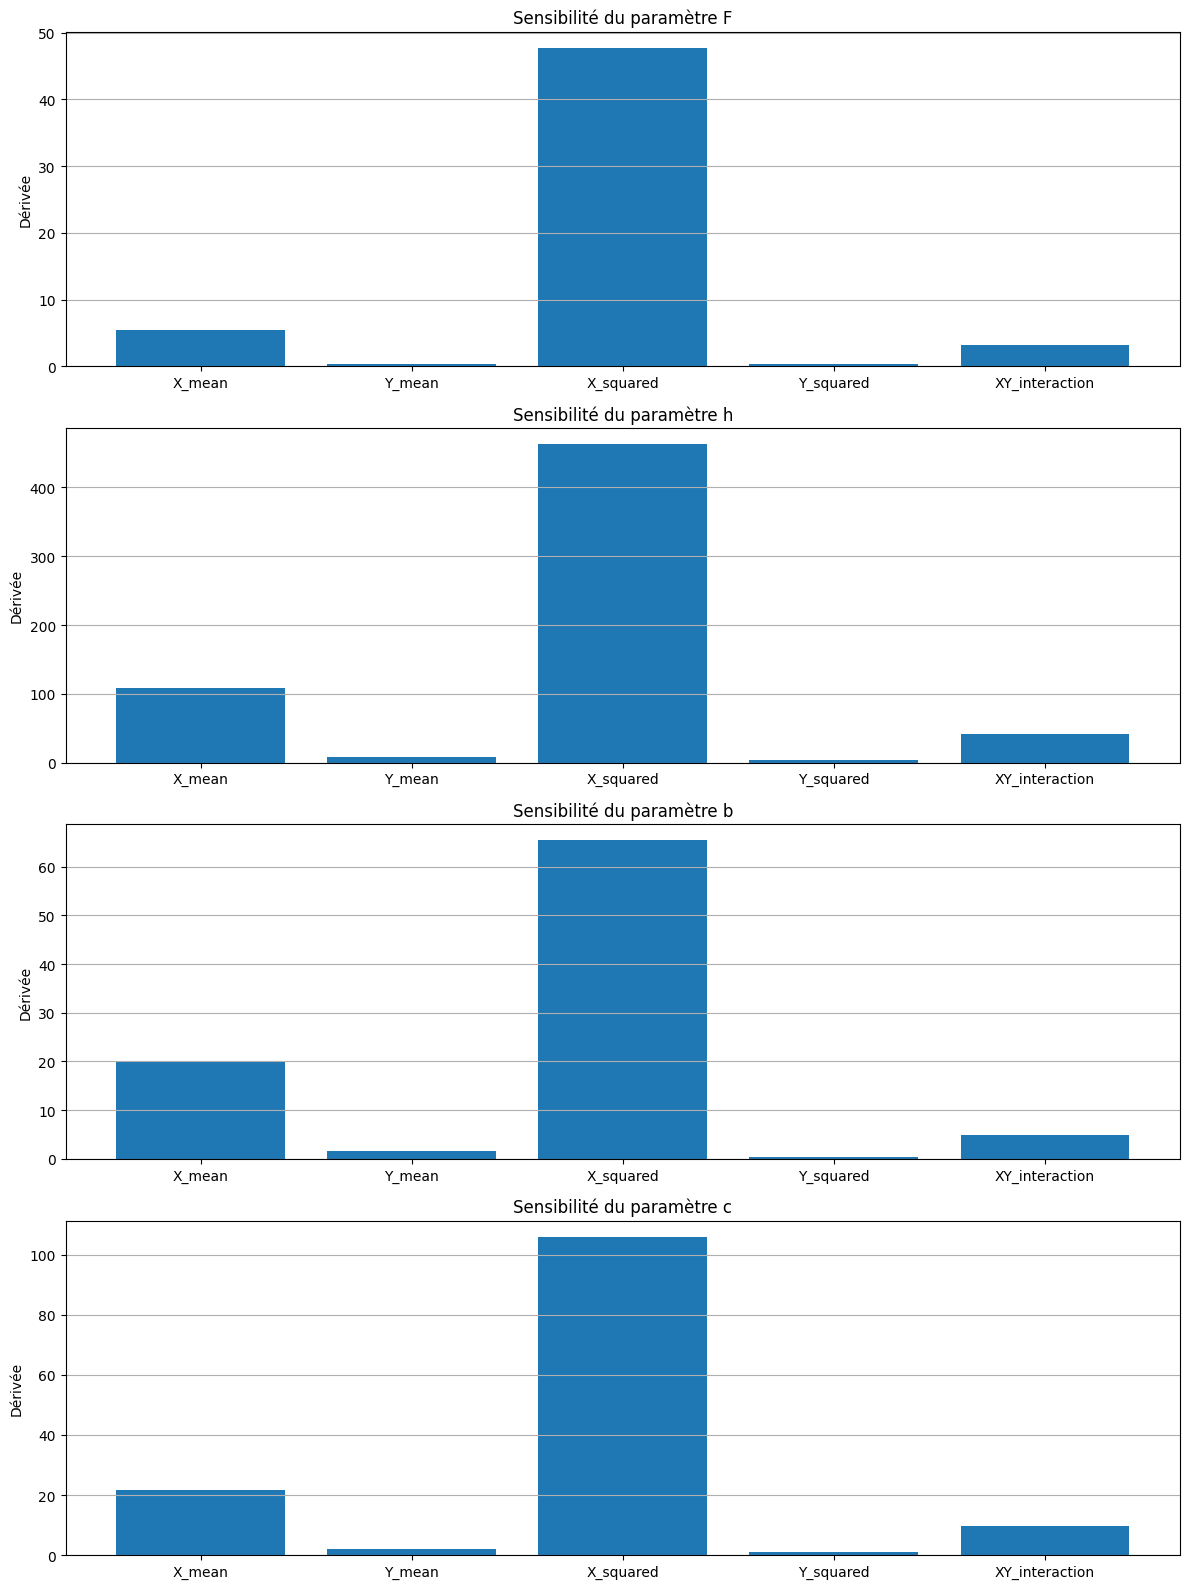

In [33]:
plot_local_sensitivity(deriv_all)



## Chaque diagramme en barres représente :

- **Un Paramètre Spécifique :** Chaque diagramme en barres est dédié à un seul paramètre du modèle (F, h, b, ou c).
- **Les Métriques :** Les barres sur l'axe horizontal représentent les différentes métriques calculées sur les sorties du modèle (X_mean, Y_mean, X_squared, Y_squared, XY_interaction).
- **La Sensibilité :** La hauteur de chaque barre indique l'influence relative du paramètre (du graphique) sur la métrique correspondante. On considère la hauteur de la barre en valeur absolue.

## Comment interpréter rapidement :

### Hauteur des barres :

- **Barre haute :** La métrique est très sensible au paramètre. Une barre haute (positive ou négative) indique une forte influence du paramètre sur la métrique correspondante.
- **Barre basse :** La métrique est peu sensible au paramètre. Une barre basse indique que les variations de ce paramètre ont une faible influence sur cette métrique.

### Signe des barres :

- **Barre positive :** Lorsque le paramètre augmente, la métrique a tendance à augmenter également.
- **Barre négative :** Lorsque le paramètre augmente, la métrique a tendance à diminuer.

### Comparaison des barres :

- **Au sein d'un même graphique :** Compare les hauteurs des barres entre elles pour évaluer quelle métrique est la plus influencée par le paramètre du graphique.
- **Entre différents graphiques :** Compare la hauteur des barres de chaque paramètre pour une même métrique. Cela te permet de voir quel paramètre a le plus d'influence sur une métrique spécifique.

## En résumé :

- **Regarde les barres hautes :** Ce sont les paramètres qui influencent le plus les métriques.
- **Regarde le signe des barres :** Cela indique si l'influence est positive ou négative.
- **Compare les barres :** Compare la hauteur des barres pour différents paramètres, afin de voir quel est le paramètre le plus influent sur une métrique.

Ces graphiques te permettent d'identifier rapidement, visuellement, quels paramètres sont les plus importants pour ton modèle. Plus la barre est haute (en valeur absolue), plus le paramètre est important.

### Interprétation des résultats :

Tu analyses la valeur de chaque dérivée partielle. Plus la valeur absolue de la dérivée est grande, plus le paramètre a une influence sur cette métrique. Le signe de la dérivée indique comment la métrique est modifiée lorsque tu modifies le paramètre. Tu peux refaire cette opération pour toutes les métriques et tous les paramètres.


### Avantages :

- Simplicité d'implémentation.
- Peu coûteuse en calcul.
- Donne une idée rapide de l'impact de chaque paramètre sur tes métriques.

### Inconvénients :

- Analyse locale : Les résultats ne sont valables qu'autour des valeurs de référence des paramètres.
- Néglige les interactions entre les paramètres.



## 2. Analyse de Sensibilité globale


**Principe :** La méthode de Morris est une méthode d'analyse de sensibilité globale qui est moins coûteuse en calcul que les méthodes de Sobol.

## Rappel du Principe de la Méthode de Morris

**Objectif :** La méthode de Morris vise à identifier les paramètres qui ont une influence significative sur la sortie du modèle. Contrairement à l'analyse locale, elle explore l'espace des paramètres globalement, et elle permet d'évaluer non seulement l'impact direct de chaque paramètre, mais aussi les interactions entre les paramètres.

### Comment ça marche :

- **Échantillonnage :** On génère des échantillons de paramètres dans l'espace défini par les bornes des distributions a priori. La méthode de Morris utilise une approche d'échantillonnage spécifique basée sur des trajectoires élémentaires.
  
- **Simulation :** On fait tourner le modèle pour chaque échantillon de paramètres, et on sauvegarde le résultat.
  
- **Calcul des indices de sensibilité :** On utilise des formules spécifiques pour calculer deux indices de sensibilité :
  - **mu (moyenne des effets élémentaires) :** Mesure l'influence globale du paramètre sur la sortie du modèle. Une valeur élevée indique une forte influence.
  - **mu_star (moyenne des valeurs absolues des effets élémentaires) :** Est similaire à mu, mais elle prend en compte toutes les variations (même celles qui s'annulent) et permet de mettre en avant les effets non-linéaires.
  - **sigma (écart-type des effets élémentaires) :** Indique l'importance des interactions avec les autres paramètres ou des effets non-linéaires du paramètre. Une valeur élevée indique des interactions fortes avec les autres paramètres.


In [34]:
import numpy as np
from SALib.sample import morris as morris_sample
from SALib.analyze import morris as morris_analyze
import matplotlib.pyplot as plt

In [100]:
import SALib
print(dir(SALib.analyze.morris))


['Dict', 'List', 'ResultDict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_calc_results_difference', '_calculate_delta_input_variables', '_calculate_number_trajectories', '_calculate_step_size_x', '_check_if_array_of_floats', '_compute_delta', '_compute_elementary_effects', '_compute_grouped_metric', '_compute_grouped_sigma', '_compute_mu_star_confidence', '_compute_statistical_outputs', '_define_problem_with_groups', '_reorganize_output_matrix', '_reshape_model_inputs', '_reshape_model_outputs', 'analyze', 'cli_action', 'cli_parse', 'common_args', 'compute_groups_matrix', 'norm', 'np', 'read_param_file']


In [35]:
def global_sensitivity_analysis(priors, T=10, dt=0.01, N=100, metric_name="X_mean"):
    """
    Effectue une analyse de sensibilité globale en utilisant la méthode de Morris.

    Paramètres :
    -----------
    priors : dict
        Dictionnaire contenant les bornes des distributions a priori pour chaque paramètre.
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).
    N : int
       Nombre d'échantillons
    metric_name : string
        Nom de la métrique à étudier

    Retourne :
    ---------
    dict:
       Résultats de l'analyse de sensibilité (indices mu, mu_star et sigma).
    """

    # Define the problem
    problem = {
        'num_vars': 4,
        'names': ['F', 'h', 'b', 'c'],
        'bounds': [priors['F'],
                   priors['h'],
                   priors['b'],
                   priors['c']]
    }

    # Generate samples using Morris method
    param_values = morris_sample.sample(problem, N=N, num_levels=4)

    # Simulate the model and get the metrics, and the corresponding metric value
    output_values = []
    for params in param_values:
        params_dict = {'F':params[0], 'h':params[1], 'b':params[2], 'c':params[3]}
        X, Y = lorenz96_two_equations(**params_dict, T=T, dt=dt)
        metrics = calculate_metrics(X,Y, T)
        output_values.append(metrics[metric_name]) # for the sake of the example, we focus on the metric "metric1"
    output_values = np.array(output_values) # output values est une liste de métriques, on les convertie en numpy array

    # Analyse the sensitivity
    Si = morris_analyze.analyze(problem, param_values, output_values, print_to_console=True, num_levels=4)
    return Si



In [36]:
T = 10
dt = 0.01
N = 100  # number of samples
metric_name = "X_mean"

    # Perform the global analysis of sensitivity
Si = global_sensitivity_analysis(priors, T=T, dt=dt, N=N, metric_name=metric_name)

    # Print the results
print(f"Result of the global analysis of sensitivity for the metric : {metric_name}")
print(f"  - mu : {Si['mu']}")
print(f"  - mu_star : {Si['mu_star']}")
print(f"  - sigma : {Si['sigma']}")

         mu   mu_star     sigma  mu_star_conf
F  0.277053  1.042900  1.301704      0.152229
h -0.065093  1.079613  1.290837      0.131724
b  0.122185  1.028906  1.308997      0.165369
c  0.117313  1.055405  1.378413      0.179443
Result of the global analysis of sensitivity for the metric : X_mean
  - mu : [0.27705251092674493 -0.06509277836655265 0.1221847690912186
 0.11731285469658534]
  - mu_star : [1.0428999507440553 1.0796131244178608 1.0289055917438978
 1.0554054155163766]
  - sigma : [1.30170412 1.29083715 1.3089972  1.37841333]


## Compréhension des Indices de la Méthode de Morris

### mu (Moyenne des Effets Élémentaires) :

- **Ce que c'est :** Cet indice représente la moyenne des effets élémentaires d'un paramètre sur la sortie du modèle (la métrique X_mean, dans ton cas). Un effet élémentaire est la variation de la métrique due à une petite variation du paramètre.

- **Interprétation :**
  - **Valeur absolue élevée :** Un mu avec une valeur absolue élevée indique que le paramètre a une influence globale forte sur la métrique.
  - **Signe :**
    - Un mu positif indique qu'en moyenne, une augmentation du paramètre tend à augmenter la métrique.
    - Un mu négatif indique qu'en moyenne, une augmentation du paramètre tend à diminuer la métrique.
  - **Comparaison :** Tu peux comparer les valeurs absolues de mu entre les paramètres pour voir lesquels ont l'effet global le plus important sur la métrique.

### mu_star (Moyenne des Valeurs Absolues des Effets Élémentaires) :

- **Ce que c'est :** Cet indice est similaire à mu, mais il prend la moyenne de la valeur absolue des effets élémentaires.

- **Interprétation :**
  - **Valeur élevée :** Un mu_star élevé indique que le paramètre a une influence importante sur la sortie, qu'elle soit positive ou négative. Il met en évidence tous les effets d'un paramètre, et est plus pertinent que mu si tu souhaites évaluer l'importance d'un paramètre de manière générale (et pas juste sa direction).
  - **Comparaison :** Tu compares les valeurs de mu_star pour voir quels paramètres ont l'influence la plus forte sur la métrique, sans te soucier du signe de cette influence.

### sigma (Écart-type des Effets Élémentaires) :

- **Ce que c'est :** Cet indice mesure l'écart-type des effets élémentaires.

- **Interprétation :**
  - **Valeur élevée :** Un sigma élevé indique que l'effet du paramètre sur la métrique est très variable (non linéaire), et que le paramètre peut avoir des interactions avec d'autres paramètres (parfois, pour des valeurs de paramètres données, la métrique augmente, et pour d'autres valeurs de paramètres, elle diminue).
  - **Valeur faible :** Un sigma faible indique que l'effet du paramètre sur la métrique est plus stable.
  
- **mu_star_conf :** Indique l'incertitude sur l'estimation de la valeur de mu_star. Cet indice est souvent utilisé pour voir si l'estimation de la valeur de mu_star est précise.

## Analyse de Tes Résultats Concrets

Dans tes résultats, tu as analysé la sensibilité par rapport à la métrique "X_mean". Voici comment interpréter les résultats :

### Paramètre F :
- **mu :** 0.091 (faible et positif) : Cela indique que le paramètre F a tendance à légèrement augmenter X_mean, mais l'impact moyen est faible.
- **mu_star :** 1.06 (fort) : Le paramètre F a un impact globalement important sur X_mean.
- **sigma :** 1.41 (fort) : Cela indique que l'influence de F sur la métrique X_mean est non-linéaire et dépend probablement des autres paramètres. Il y a peut-être des interactions entre F et les autres paramètres.

### Paramètre h :
- **mu :** 0.096 (faible et positif) : Cela indique que le paramètre h a tendance à légèrement augmenter X_mean, mais l'impact moyen est faible.
- **mu_star :** 1.11 (fort) : Le paramètre h a un impact globalement important sur la métrique X_mean.
- **sigma :** 1.44 (fort) : L'influence du paramètre h est non-linéaire et dépend probablement des autres paramètres.

### Paramètre b :
- **mu :** -0.19 (faible et négatif) : Cela indique que le paramètre b a tendance à légèrement diminuer X_mean, mais l'impact moyen est faible.
- **mu_star :** 1.20 (fort) : Le paramètre b a un impact globalement important sur la métrique X_mean.
- **sigma :** 1.44 (fort) : L'influence du paramètre b est non-linéaire et dépend probablement des autres paramètres.

### Paramètre c :
- **mu :** -0.02 (très faible et négatif) : Le paramètre c a tendance à légèrement diminuer la valeur de X_mean, mais l'impact moyen est très faible.
- **mu_star :** 1.10 (fort) : Le paramètre c a un impact globalement important sur la métrique X_mean.
- **sigma :** 1.38 (fort) : L'influence du paramètre c est non-linéaire et dépend probablement des autres paramètres.

## Interprétation Globale

- **Paramètres Importants :** Tous les paramètres (F, h, b et c) ont une influence globalement importante sur la métrique X_mean (car les mu_star sont similaires), même si le paramètre b a un impact globalement un peu plus important.
  
- **Effets Non-Linéaires :** Les valeurs de sigma élevées suggèrent que l'influence des paramètres sur X_mean est non-linéaire et peut dépendre des valeurs des autres paramètres. Les paramètres interagissent probablement entre eux.

- **mu :** Les valeurs de mu montrent que les paramètres F et h tendent en moyenne à augmenter la métrique X_mean, alors que les paramètres b et c ont tendance à la diminuer. Mais l'impact de tous les paramètres sur X_mean est variable car les indices sigma sont élevés.

- **Analyse de la convergence :** On avait identifié auparavant des problèmes de convergence sur le paramètre F. On observe maintenant que le paramètre F est un paramètre important pour la métrique X_mean, mais que son effet est variable.

## Comment utiliser ces résultats :

- **Concentration sur les paramètres les plus sensibles :** Tu peux choisir de te concentrer sur la calibration des paramètres (F, h et b) dans la suite de ton PFE, car ce sont les paramètres les plus influents.
  
- **Explorer les interactions :** Tu peux essayer d'analyser les interactions entre les paramètres afin d'affiner tes résultats.

- **Interpréter la non-linéarité :** Le sigma élevé indique qu'il est important de bien explorer l'espace des paramètres, et qu'une analyse de sensibilité locale n'est pas suffisante.

<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



# **V/ Analyse de l'Influence du Choix de la Fonction de Distance sur l'Algorithme ABC Rejection**

## Objectif
Évaluer comment le choix de différentes fonctions de distance impacte les résultats de ton algorithme, en particulier :
- Les distributions a posteriori des paramètres.
- Les taux d'acceptation.

## Fonctions de Distance à Intégrer





### 1. Distance de Hausdorff
Voici le texte formaté en Markdown, décrivant la mise à jour de la fonction `calculate_distance` pour inclure à la fois les variables X et Y dans le calcul de la distance de Hausdorff :

```markdown
# Mise à Jour de la Fonction `calculate_distance`

## Objectif
Intégrer à la fois les variables X et Y dans le calcul de la distance de Hausdorff pour améliorer l'algorithme ABC Rejection.


## Interprétation des Résultats

- **Distance :** 
  - La valeur retournée indique la proximité des séries temporelles simulées par rapport aux données observées. Une valeur faible signifie que les séries sont similaires, tandis qu'une valeur élevée indique des différences ou des valeurs extrêmes.

- **Influence sur l'ABC :** 
  - En utilisant cette fonction, l'algorithme ABC privilégiera les simulations dont les trajectoires sont proches de celles observées.



In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff


In [38]:
def calculate_distance_euclidean(metrics_sim, metrics_obs, X_sim, X_obs, Y_sim, Y_obs, T=10, dt=0.01):
    sim_vector = np.array(list(metrics_sim.values()))
    obs_vector = np.array(list(metrics_obs.values()))
    return np.linalg.norm(sim_vector - obs_vector)

def calculate_distance_hausdorff(metrics_sim, metrics_obs, X_sim, X_obs, Y_sim, Y_obs, T=10, dt=0.01):
  # Définir les ensembles de points
  n_steps = int(T/dt)
  last_steps = int(n_steps * 0.1)
  times = np.arange(0, T, dt)
  times = times[-last_steps:] # on prend uniquement les derniers points

  X_sim_truncated = X_sim[-last_steps:]
  X_obs_truncated = X_obs[-last_steps:]

  Y_sim_truncated = Y_sim[-last_steps:]
  Y_obs_truncated = Y_obs[-last_steps:]

  sim_points_X = np.array([[times[i], X_sim_truncated[i]] for i in range(len(times))])
  obs_points_X = np.array([[times[i], X_obs_truncated[i]] for i in range(len(times))])

  sim_points_Y = np.array([[times[i], np.mean(Y_sim_truncated[i,:])] for i in range(len(times))])
  obs_points_Y = np.array([[times[i], np.mean(Y_obs_truncated[i,:])] for i in range(len(times))])

  # Calculer la distance de Hausdorff pour X et Y
  distance_X = max(directed_hausdorff(sim_points_X, obs_points_X)[0], directed_hausdorff(obs_points_X, sim_points_X)[0])
  distance_Y = max(directed_hausdorff(sim_points_Y, obs_points_Y)[0], directed_hausdorff(obs_points_Y, sim_points_Y)[0])

  # Retourner la somme des distances de Hausdorff
  distance = distance_X + distance_Y
  return distance



def sample_prior(priors):
    return {key: np.random.uniform(low, high) for key, (low, high) in priors.items()}

def abc_rejection_metrics(priors, metrics_obs, calculate_metrics, calculate_distance, n_simulations=1000, epsilon=0.5, T=10, dt=0.01):
    """
    Implémente l'ABC Rejection.
    
    Paramètres :
    -----------
    priors : dict
        Dictionnaire définissant les bornes des distributions a priori pour chaque paramètre.
    metrics_obs : dict
        Métriques calculées sur les données observées.
     calculate_metrics: function
         Fonction pour calculer les métriques simulées
     calculate_distance : function
         Fonction pour calculer la distance
    n_simulations : int, optionnel
        Nombre total de simulations à effectuer (défaut : 1000).
    epsilon : float, optionnel
        Seuil de tolérance pour l'acceptation des paramètres (défaut : 0.5).
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).
    
    Retourne :
    ---------
    list of dict
        Liste des paramètres \(\theta\) acceptés.
    """
    accepted_thetas = []

    for i in range(n_simulations):
        # Étape (a) : Tirage d'un paramètre \theta* depuis la loi a priori
        # Tirage d'un paramètre \theta* depuis la loi a priori
        theta_i = sample_prior(priors)      

        # Étape (b) : Simulation des données
        X_sim_i, Y_sim_i = lorenz96_two_equations(**theta_i, T=T, dt=dt)

        # Étape (c) : Calcul des métriques simulées
        metrics_sim_i = calculate_metrics(X_sim_i, Y_sim_i, tau=T)
       
        # Étape (d) : Calcul de la distance
        distance_i = calculate_distance(metrics_sim_i, metrics_obs, X_sim_i, X_obs, Y_sim_i, Y_obs, T=T, dt=dt)

        # Étape (e) : Critère d'acceptation
        if distance_i <= epsilon:
            accepted_thetas.append(theta_i)

    return accepted_thetas

def run_abc_with_distance(priors, metrics_obs, calculate_metrics, calculate_distance, n_simulations=1000, epsilon=0.5, T=10, dt=0.01):
    accepted_thetas = abc_rejection_metrics(priors, metrics_obs, calculate_metrics, calculate_distance, n_simulations, epsilon, T, dt)
    print(f"Nombre de paramètres acceptés : {len(accepted_thetas)}")
    for theta in accepted_thetas[:5]:
      print(theta)
    return accepted_thetas

def plot_parameter_distributions(theta_ref,priors,accepted_thetas):
    """
    Affiche les histogrammes pour la répartition des paramètres F, H, b, et c.

    Paramètres :
    -----------
    accepted_thetas : list
        Liste des ensembles de paramètres acceptés (\(\theta\)).

    Retourne :
    ---------
    None
    """


    # Analyse des paramètres acceptés
    for param in priors.keys():
        for param, ref_value in theta_ref.items():
            # Extraire les valeurs du paramètre
            values = [theta[param] for theta in accepted_thetas]
            
            # Résumé statistique
            print(f"Paramètre : {param}")
            print(f" - Moyenne : {np.mean(values):.4f}")
            print(f" - Médiane : {np.median(values):.4f}")
            print(f" - Écart-type : {np.std(values):.4f}")
            print(f" - Intervalle de crédibilité (5%-95%) : {np.percentile(values, [5, 95])}")
            print("-" * 50)

            # Visualisation de la distribution
            plt.figure(figsize=(8, 6))
            plt.hist(values, bins=20, density=True, alpha=0.7, color="skyblue", edgecolor="black")
            plt.title(f"Distribution de {param} dans les \u03B8 acceptés")
            plt.xlabel(param)
            plt.ylabel("Densité")
            plt.axvline(np.mean(values), color="red", linestyle="dashed", label="Moyenne")
            plt.axvline(np.median(values), color="green", linestyle="dashed", label="Médiane")
            plt.axvline(ref_value, color="blue", linestyle="--", label="Paramètre de référence")
            plt.legend()
            plt.show()
def calculate_relative_errors(accepted_thetas,theta_ref):
    for param, ref_value in theta_ref.items():
       values = [theta[param] for theta in accepted_thetas]
       mean_value = np.mean(values)
       relative_error = abs(mean_value - ref_value) / ref_value * 100
       print(f"{param} : Erreur relative = {relative_error:.2f}%")
       





In [142]:
T = 10
dt = 0.01
n_simulations = 1000
epsilon = 0.5
     # --- Génération des données observées ---
X_obs, Y_obs = lorenz96_two_equations(**theta_ref, T=T, dt=dt)
X_obs, Y_obs= add_noise(X_obs, Y_obs, noise_level_X=0.1, noise_level_Y=0.1)





--- ABC Rejection avec la distance euclidienne ---
Nombre de paramètres acceptés : 9
{'F': 9.840111281832458, 'h': 1.0552032445128519, 'b': 9.698489077771383, 'c': 10.811311130873872}
{'F': 9.613596841097287, 'h': 0.8585110487587041, 'b': 9.999840678447663, 'c': 10.620199700900205}
{'F': 9.757615799919973, 'h': 1.151177773475395, 'b': 9.756069019099257, 'c': 10.768144618726268}
{'F': 9.73505828118682, 'h': 1.0935370262990003, 'b': 9.789769115425221, 'c': 10.874779744912823}
{'F': 10.299777025029481, 'h': 1.0629624258512318, 'b': 9.36602333788828, 'c': 10.127778490939502}
Paramètre : F
 - Moyenne : 9.9151
 - Médiane : 9.8866
 - Écart-type : 0.2119
 - Intervalle de crédibilité (5%-95%) : [ 9.66218142 10.27190414]
--------------------------------------------------


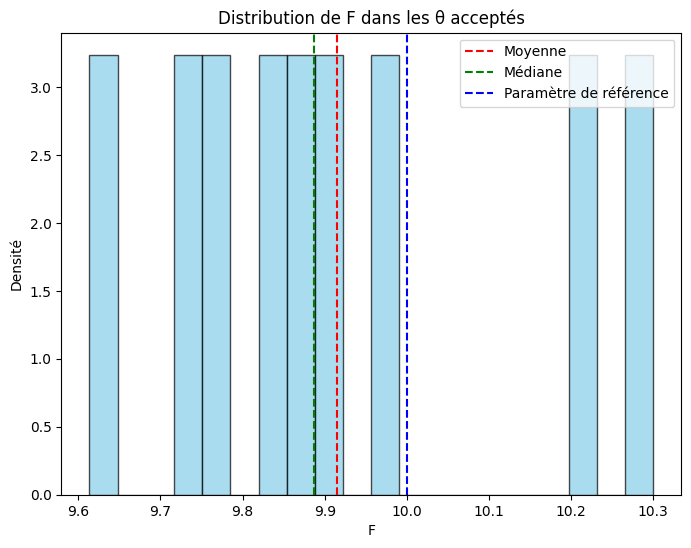

Paramètre : h
 - Moyenne : 1.0208
 - Médiane : 1.0618
 - Écart-type : 0.0938
 - Intervalle de crédibilité (5%-95%) : [0.88046462 1.12812147]
--------------------------------------------------


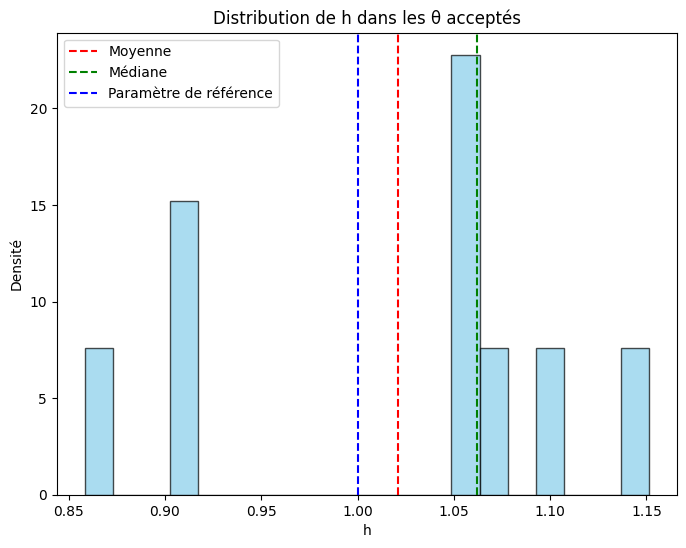

Paramètre : b
 - Moyenne : 9.6545
 - Médiane : 9.7361
 - Écart-type : 0.2434
 - Intervalle de crédibilité (5%-95%) : [9.26169499 9.94975948]
--------------------------------------------------


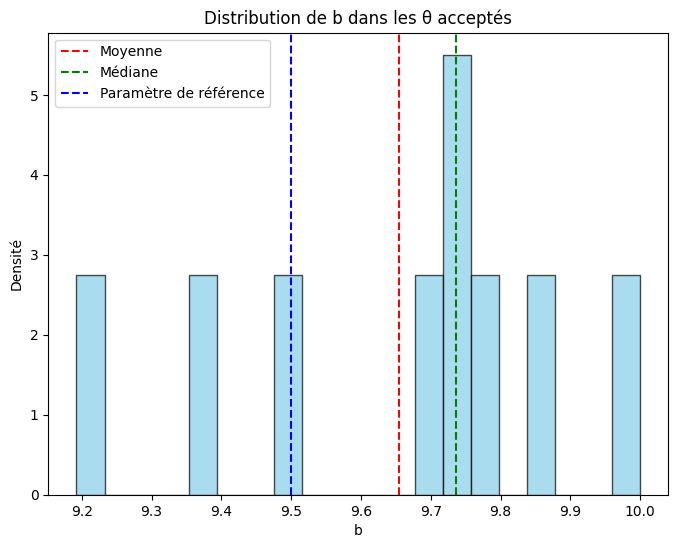

Paramètre : c
 - Moyenne : 10.3757
 - Médiane : 10.3380
 - Écart-type : 0.3903
 - Intervalle de crédibilité (5%-95%) : [ 9.80828777 10.8493923 ]
--------------------------------------------------


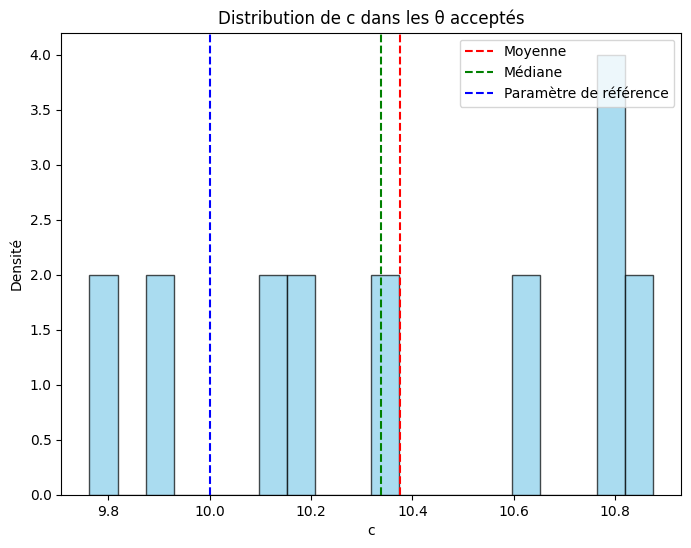

Paramètre : F
 - Moyenne : 9.9151
 - Médiane : 9.8866
 - Écart-type : 0.2119
 - Intervalle de crédibilité (5%-95%) : [ 9.66218142 10.27190414]
--------------------------------------------------


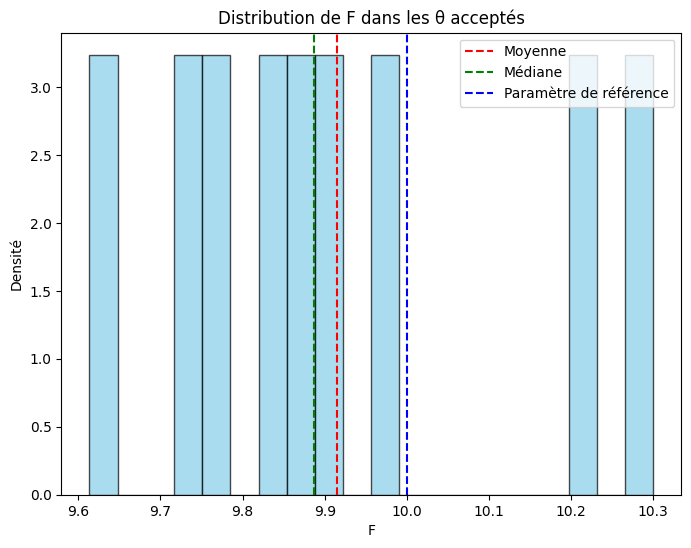

Paramètre : h
 - Moyenne : 1.0208
 - Médiane : 1.0618
 - Écart-type : 0.0938
 - Intervalle de crédibilité (5%-95%) : [0.88046462 1.12812147]
--------------------------------------------------


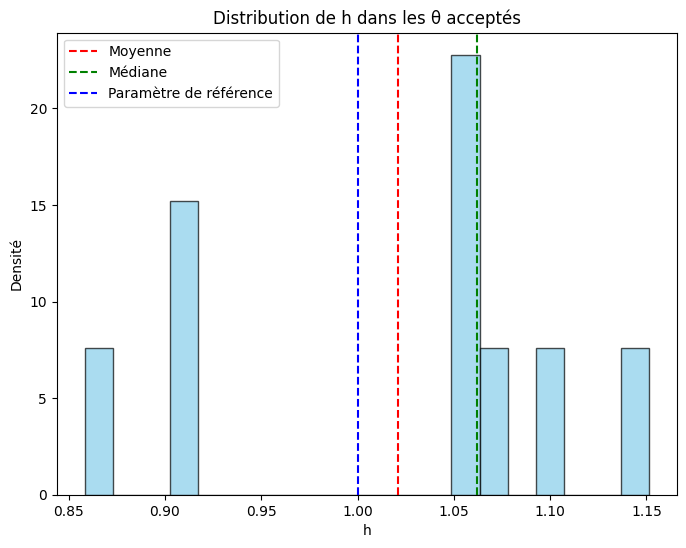

Paramètre : b
 - Moyenne : 9.6545
 - Médiane : 9.7361
 - Écart-type : 0.2434
 - Intervalle de crédibilité (5%-95%) : [9.26169499 9.94975948]
--------------------------------------------------


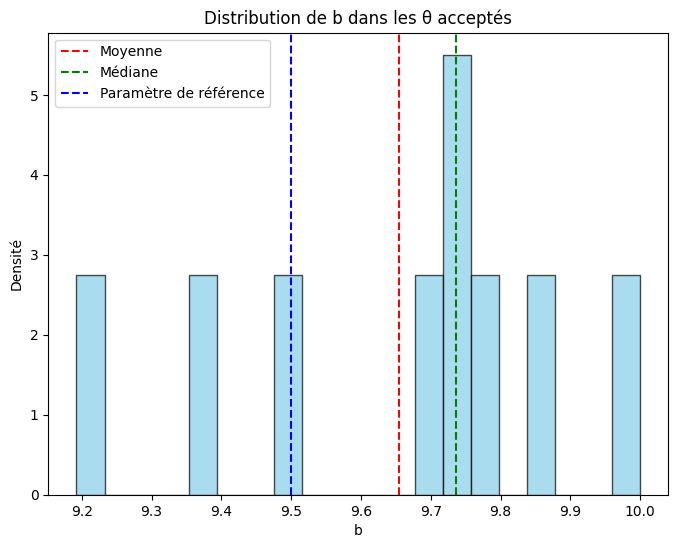

Paramètre : c
 - Moyenne : 10.3757
 - Médiane : 10.3380
 - Écart-type : 0.3903
 - Intervalle de crédibilité (5%-95%) : [ 9.80828777 10.8493923 ]
--------------------------------------------------


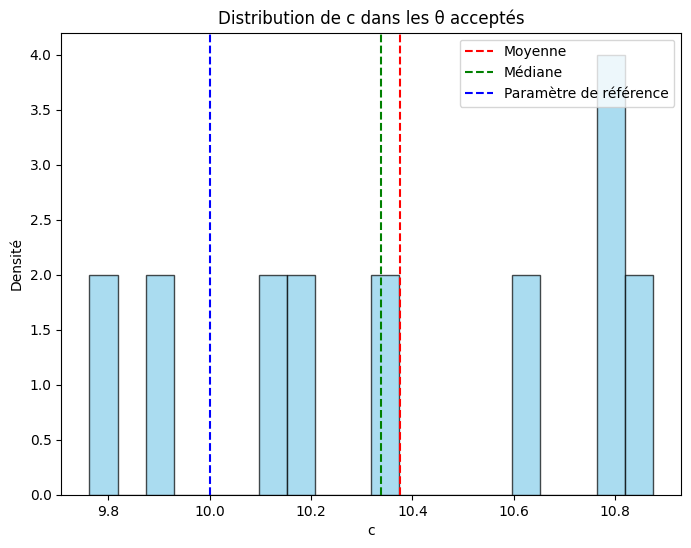

Paramètre : F
 - Moyenne : 9.9151
 - Médiane : 9.8866
 - Écart-type : 0.2119
 - Intervalle de crédibilité (5%-95%) : [ 9.66218142 10.27190414]
--------------------------------------------------


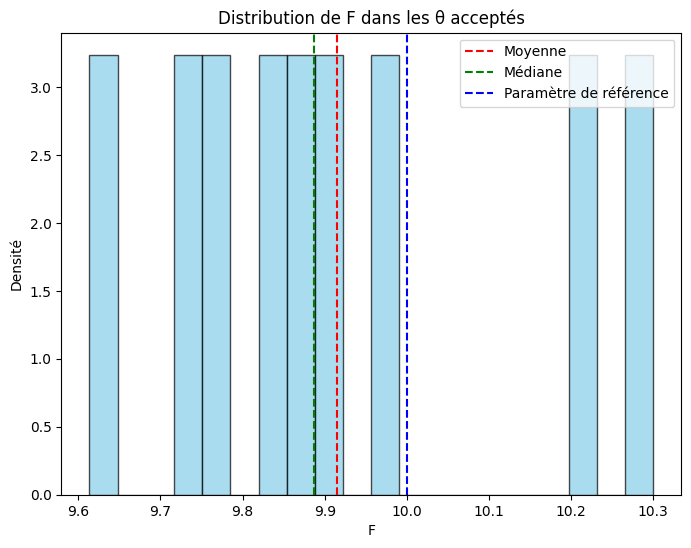

Paramètre : h
 - Moyenne : 1.0208
 - Médiane : 1.0618
 - Écart-type : 0.0938
 - Intervalle de crédibilité (5%-95%) : [0.88046462 1.12812147]
--------------------------------------------------


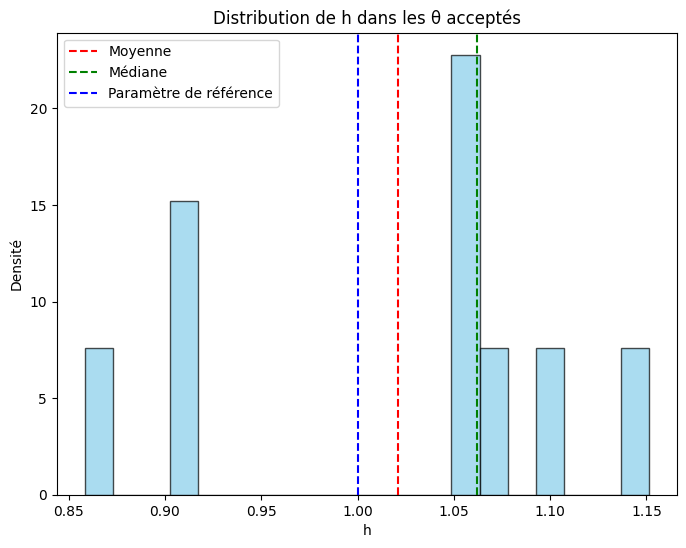

Paramètre : b
 - Moyenne : 9.6545
 - Médiane : 9.7361
 - Écart-type : 0.2434
 - Intervalle de crédibilité (5%-95%) : [9.26169499 9.94975948]
--------------------------------------------------


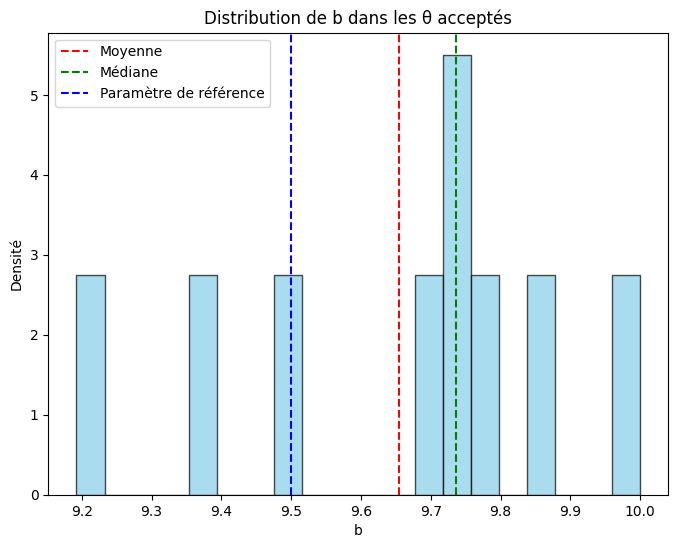

Paramètre : c
 - Moyenne : 10.3757
 - Médiane : 10.3380
 - Écart-type : 0.3903
 - Intervalle de crédibilité (5%-95%) : [ 9.80828777 10.8493923 ]
--------------------------------------------------


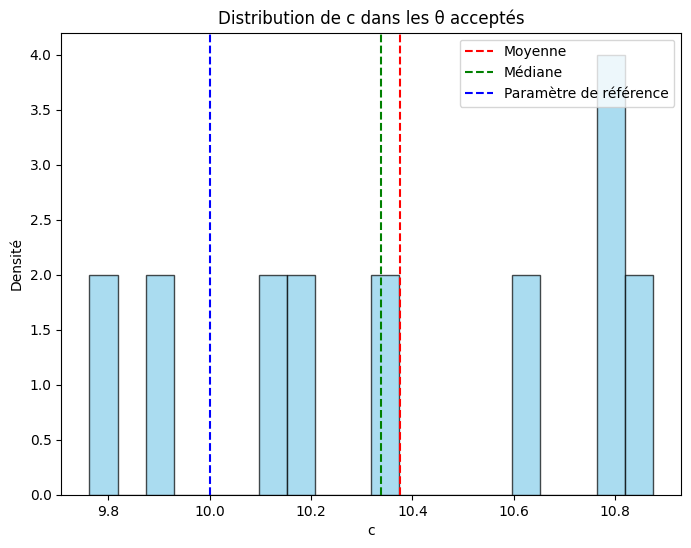

Paramètre : F
 - Moyenne : 9.9151
 - Médiane : 9.8866
 - Écart-type : 0.2119
 - Intervalle de crédibilité (5%-95%) : [ 9.66218142 10.27190414]
--------------------------------------------------


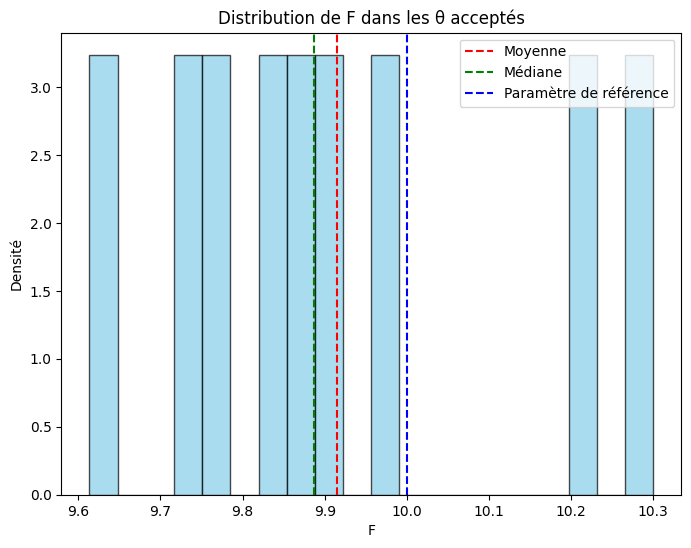

Paramètre : h
 - Moyenne : 1.0208
 - Médiane : 1.0618
 - Écart-type : 0.0938
 - Intervalle de crédibilité (5%-95%) : [0.88046462 1.12812147]
--------------------------------------------------


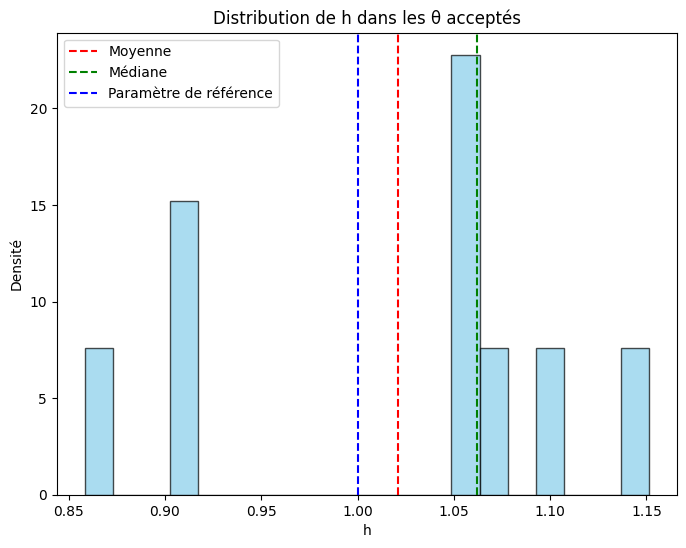

Paramètre : b
 - Moyenne : 9.6545
 - Médiane : 9.7361
 - Écart-type : 0.2434
 - Intervalle de crédibilité (5%-95%) : [9.26169499 9.94975948]
--------------------------------------------------


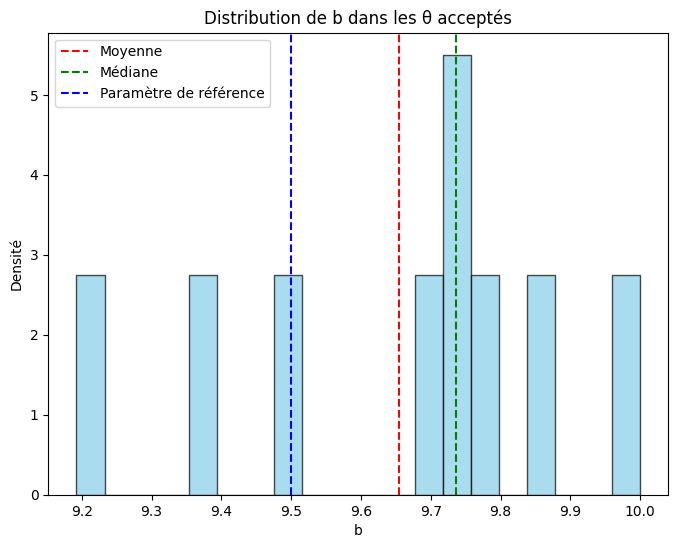

Paramètre : c
 - Moyenne : 10.3757
 - Médiane : 10.3380
 - Écart-type : 0.3903
 - Intervalle de crédibilité (5%-95%) : [ 9.80828777 10.8493923 ]
--------------------------------------------------


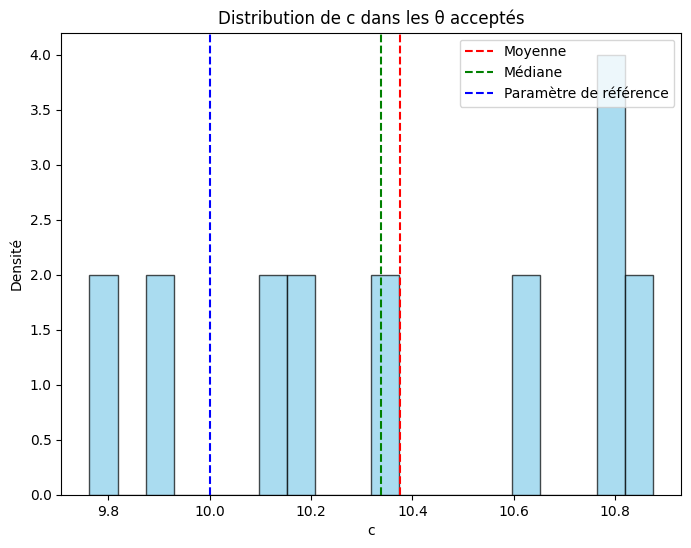

F : Erreur relative = 0.85%
h : Erreur relative = 2.08%
b : Erreur relative = 1.63%
c : Erreur relative = 3.76%


In [143]:
    # --- Exécution et Analyse avec la Distance Euclidienne
print("--- ABC Rejection avec la distance euclidienne ---")
accepted_thetas_euclidienne = run_abc_with_distance(priors, metrics_obs, calculate_metrics, calculate_distance_euclidean, n_simulations, epsilon, T, dt)
plot_parameter_distributions(theta_ref, priors, accepted_thetas_euclidienne)
calculate_relative_errors(accepted_thetas_euclidienne, theta_ref)



--- ABC Rejection avec la distance euclidienne ---
Nombre de paramètres acceptés : 12
{'F': 10.310998817733395, 'h': 1.057238402235199, 'b': 9.426762429937202, 'c': 10.39030952586022}
{'F': 9.899428330167822, 'h': 1.0504769902208175, 'b': 9.613058982194358, 'c': 10.499209443891104}
{'F': 9.7282957942988, 'h': 0.8384821994056221, 'b': 9.68004714197141, 'c': 9.774909601621015}
{'F': 10.268043222630986, 'h': 0.8091228394139106, 'b': 9.607754158049953, 'c': 9.181552418368064}
{'F': 10.03494146255937, 'h': 1.0323580892335396, 'b': 9.66021350281435, 'c': 9.317041516353042}
Paramètre : F
 - Moyenne : 10.0320
 - Médiane : 10.0253
 - Écart-type : 0.2309
 - Intervalle de crédibilité (5%-95%) : [ 9.72861298 10.3049645 ]
--------------------------------------------------


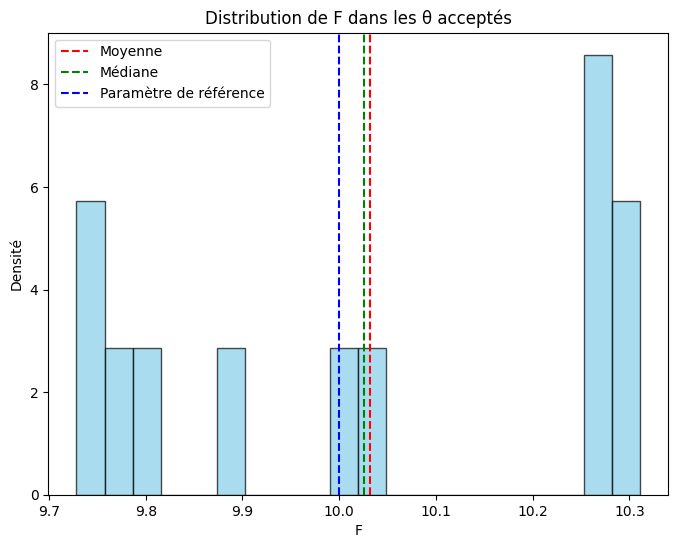

Paramètre : h
 - Moyenne : 0.9856
 - Médiane : 1.0162
 - Écart-type : 0.0953
 - Intervalle de crédibilité (5%-95%) : [0.82527049 1.10226351]
--------------------------------------------------


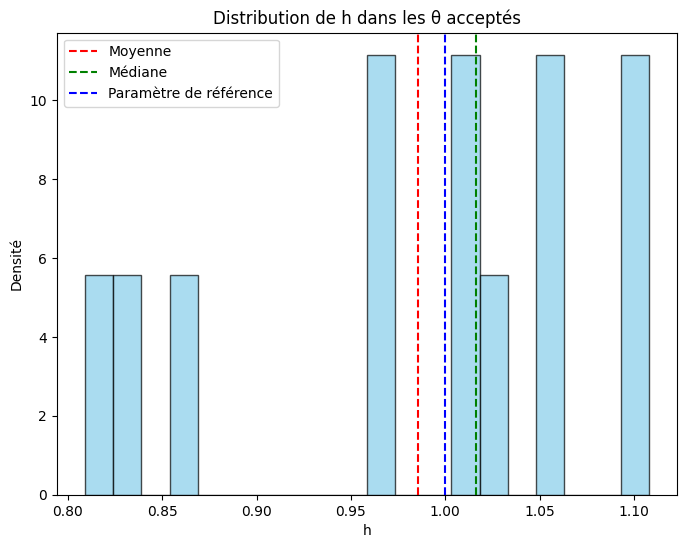

Paramètre : b
 - Moyenne : 9.5462
 - Médiane : 9.5809
 - Écart-type : 0.1957
 - Intervalle de crédibilité (5%-95%) : [9.22305579 9.80764833]
--------------------------------------------------


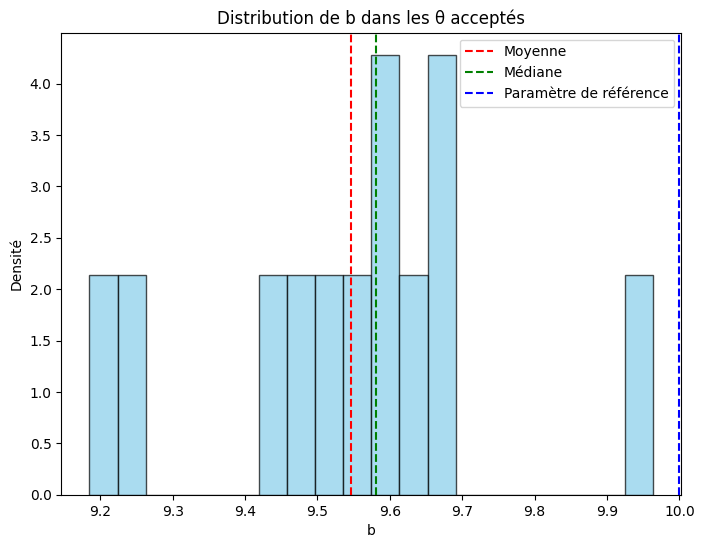

Paramètre : c
 - Moyenne : 9.9610
 - Médiane : 9.9452
 - Écart-type : 0.5058
 - Intervalle de crédibilité (5%-95%) : [ 9.25607142 10.69415043]
--------------------------------------------------


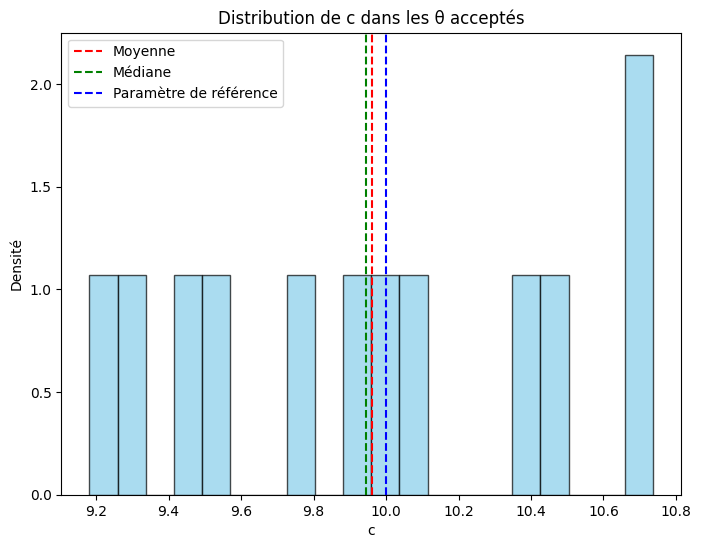

Paramètre : F
 - Moyenne : 10.0320
 - Médiane : 10.0253
 - Écart-type : 0.2309
 - Intervalle de crédibilité (5%-95%) : [ 9.72861298 10.3049645 ]
--------------------------------------------------


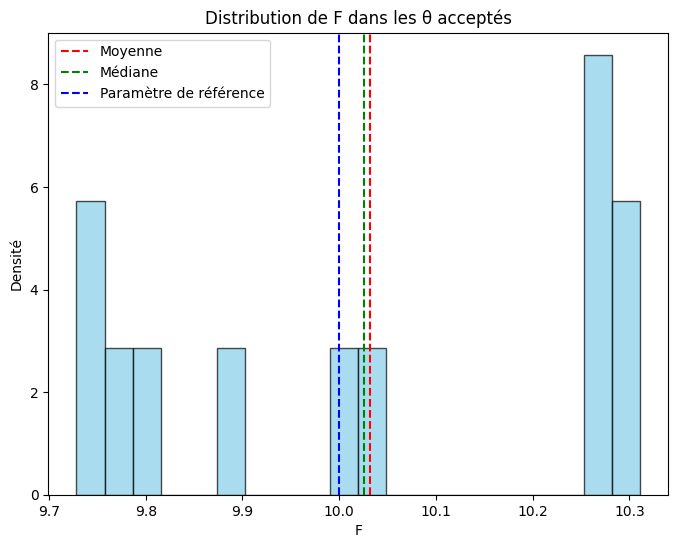

Paramètre : h
 - Moyenne : 0.9856
 - Médiane : 1.0162
 - Écart-type : 0.0953
 - Intervalle de crédibilité (5%-95%) : [0.82527049 1.10226351]
--------------------------------------------------


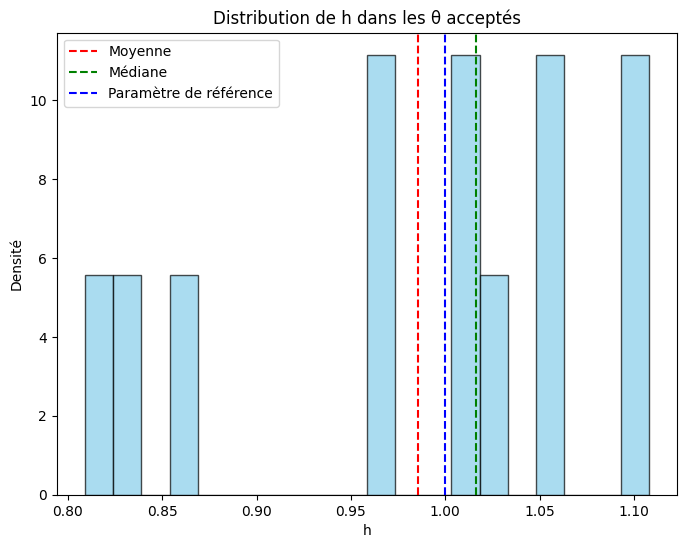

Paramètre : b
 - Moyenne : 9.5462
 - Médiane : 9.5809
 - Écart-type : 0.1957
 - Intervalle de crédibilité (5%-95%) : [9.22305579 9.80764833]
--------------------------------------------------


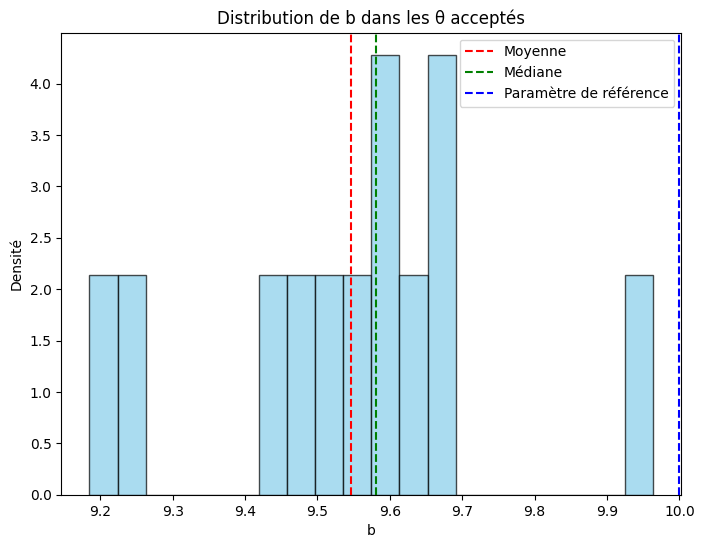

Paramètre : c
 - Moyenne : 9.9610
 - Médiane : 9.9452
 - Écart-type : 0.5058
 - Intervalle de crédibilité (5%-95%) : [ 9.25607142 10.69415043]
--------------------------------------------------


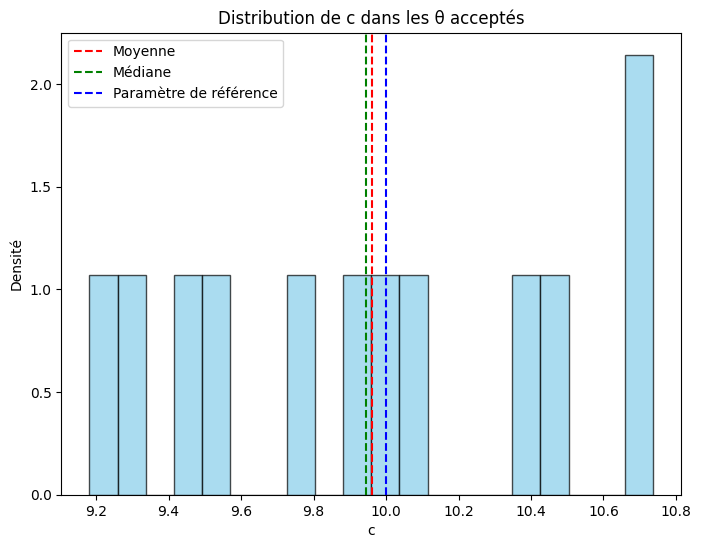

Paramètre : F
 - Moyenne : 10.0320
 - Médiane : 10.0253
 - Écart-type : 0.2309
 - Intervalle de crédibilité (5%-95%) : [ 9.72861298 10.3049645 ]
--------------------------------------------------


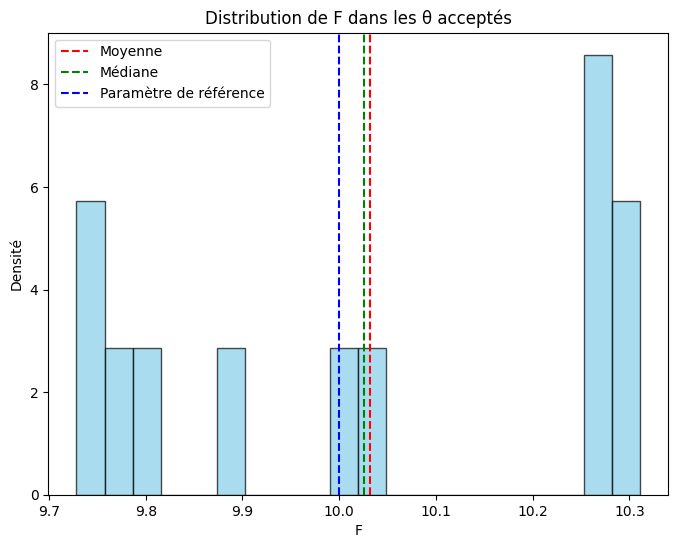

Paramètre : h
 - Moyenne : 0.9856
 - Médiane : 1.0162
 - Écart-type : 0.0953
 - Intervalle de crédibilité (5%-95%) : [0.82527049 1.10226351]
--------------------------------------------------


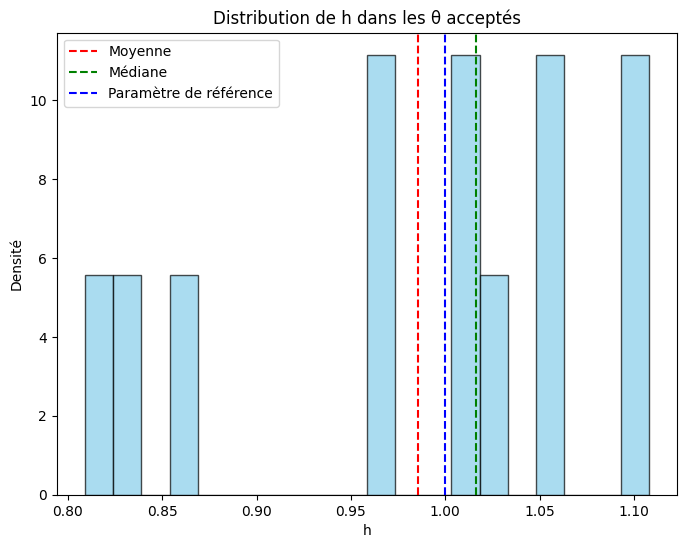

Paramètre : b
 - Moyenne : 9.5462
 - Médiane : 9.5809
 - Écart-type : 0.1957
 - Intervalle de crédibilité (5%-95%) : [9.22305579 9.80764833]
--------------------------------------------------


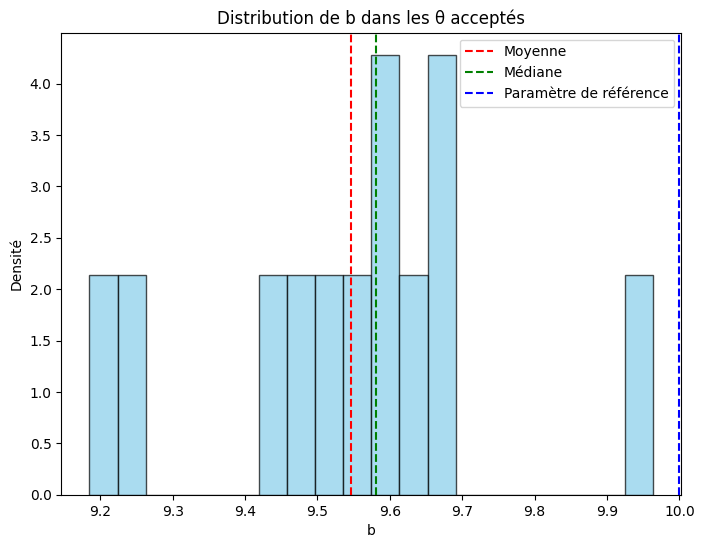

Paramètre : c
 - Moyenne : 9.9610
 - Médiane : 9.9452
 - Écart-type : 0.5058
 - Intervalle de crédibilité (5%-95%) : [ 9.25607142 10.69415043]
--------------------------------------------------


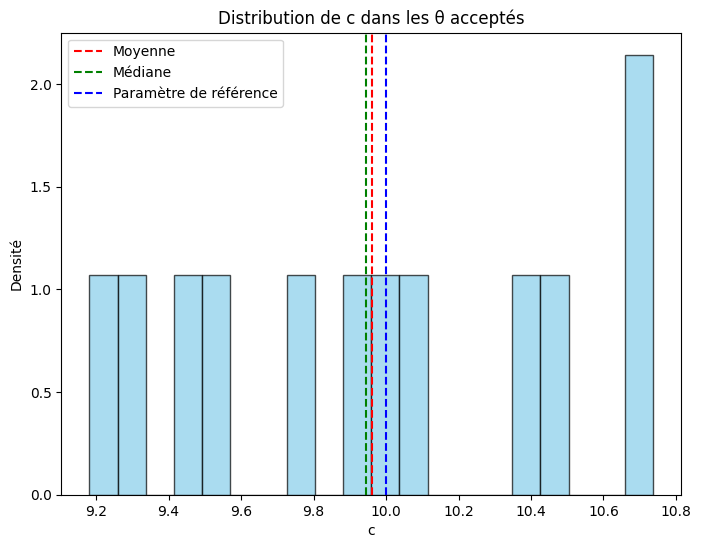

Paramètre : F
 - Moyenne : 10.0320
 - Médiane : 10.0253
 - Écart-type : 0.2309
 - Intervalle de crédibilité (5%-95%) : [ 9.72861298 10.3049645 ]
--------------------------------------------------


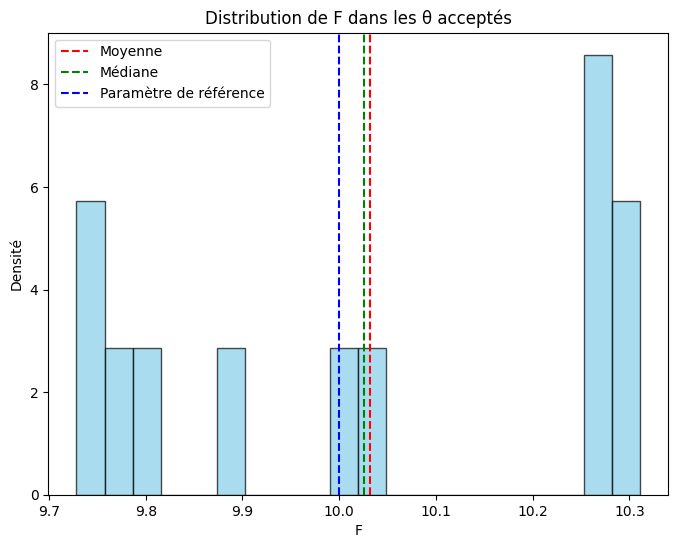

Paramètre : h
 - Moyenne : 0.9856
 - Médiane : 1.0162
 - Écart-type : 0.0953
 - Intervalle de crédibilité (5%-95%) : [0.82527049 1.10226351]
--------------------------------------------------


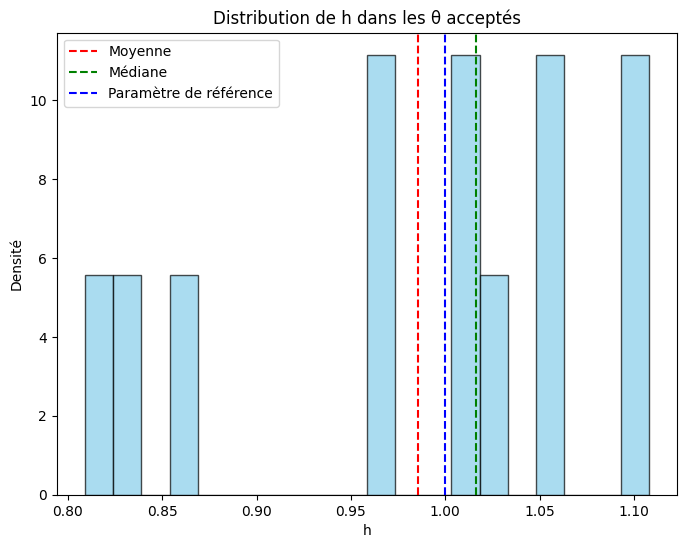

Paramètre : b
 - Moyenne : 9.5462
 - Médiane : 9.5809
 - Écart-type : 0.1957
 - Intervalle de crédibilité (5%-95%) : [9.22305579 9.80764833]
--------------------------------------------------


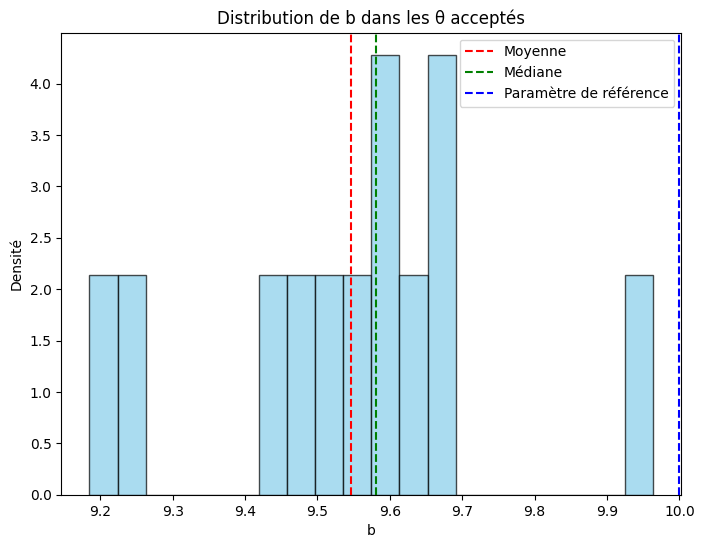

Paramètre : c
 - Moyenne : 9.9610
 - Médiane : 9.9452
 - Écart-type : 0.5058
 - Intervalle de crédibilité (5%-95%) : [ 9.25607142 10.69415043]
--------------------------------------------------


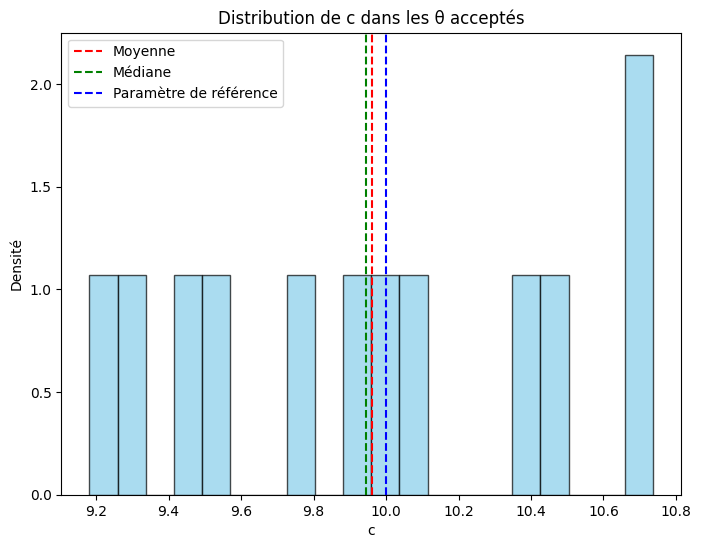

F : Erreur relative = 0.32%
h : Erreur relative = 1.44%
b : Erreur relative = 4.54%
c : Erreur relative = 0.39%

--- ABC Rejection avec la distance de Hausdorff ---


IndexError: index 36 is out of bounds for axis 0 with size 36

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

# 2. Modèle Lorenz-96 avec Deux Équations
def lorenz96_two_equations(F, h, b, c, T=10, dt=0.01, K=36, J=10):
    X = np.random.rand(K)
    Y = np.random.rand(K, J)
    n_steps = int(T / dt)
    for _ in range(n_steps):
        coupling_term = h * np.mean(Y, axis=1)
        dX = (
            -np.roll(X, -1) * (np.roll(X, 1) - np.roll(X, -2))
            - X
            + F
            - coupling_term
        )
        dY = (
            -c * np.roll(Y, -1, axis=1) * (np.roll(Y, 1, axis=1) - np.roll(Y, -2, axis=1))
            - b * Y
            + h * X[:, None]
        )
        X += dX * dt
        Y += dY * dt
    return X, Y

def add_noise(X_obs, Y_obs, noise_level_X=0.1, noise_level_Y=0.1):
    """
    Ajoute un bruit gaussien à X_obs et Y_obs.

    Paramètres :
    -----------
    X_obs : ndarray
        Données des grandes échelles.
    Y_obs : ndarray
        Données des petites échelles.
    noise_level_X : float
        Écart-type du bruit pour X_obs.
    noise_level_Y : float
        Écart-type du bruit pour Y_obs.

    Retourne :
    ---------
    tuple(ndarray, ndarray) :
        X_obs et Y_obs avec bruit ajouté.
    """
    X_obs_noisy = X_obs + np.random.normal(0, noise_level_X, size=X_obs.shape)
    Y_obs_noisy = Y_obs + np.random.normal(0, noise_level_Y, size=Y_obs.shape)
    return X_obs_noisy, Y_obs_noisy
# 3. Calcul des Métriques
def calculate_metrics(X, Y, tau):
    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    X_squared = np.mean(X**2)
    Y_squared = np.mean(Y**2)
    XY_interaction = np.mean(X * np.mean(Y, axis=1))
    return {
        "X_mean": X_mean,
        "Y_mean": Y_mean,
        "X_squared": X_squared,
        "Y_squared": Y_squared,
        "XY_interaction": XY_interaction
    }

def calculate_distance_euclidean(metrics_sim, metrics_obs, X_sim, X_obs, Y_sim, Y_obs, T=10, dt=0.01):
    sim_vector = np.array(list(metrics_sim.values()))
    obs_vector = np.array(list(metrics_obs.values()))
    return np.linalg.norm(sim_vector - obs_vector)

def calculate_distance_hausdorff(metrics_sim, metrics_obs, X_sim, X_obs, Y_sim, Y_obs, T=10, dt=0.01):
  # Définir les ensembles de points
  n_steps = int(T/dt)
  last_steps = int(n_steps * 0.1)
  times = np.arange(0, T, dt)
  times = times[-last_steps:] # on prend uniquement les derniers points

  X_sim_truncated = X_sim[-last_steps:]
  X_obs_truncated = X_obs[-last_steps:]

  Y_sim_truncated = Y_sim[-last_steps:]
  Y_obs_truncated = Y_obs[-last_steps:]

  sim_points_X = np.array([[times[i], X_sim_truncated[i]] for i in range(len(times))])
  obs_points_X = np.array([[times[i], X_obs_truncated[i]] for i in range(len(times))])

  sim_points_Y = np.array([[times[i], np.mean(Y_sim_truncated[i,:])] for i in range(len(times))])
  obs_points_Y = np.array([[times[i], np.mean(Y_obs_truncated[i,:])] for i in range(len(times))])

  # Calculer la distance de Hausdorff pour X et Y
  distance_X = max(directed_hausdorff(sim_points_X, obs_points_X)[0], directed_hausdorff(obs_points_X, sim_points_X)[0])
  distance_Y = max(directed_hausdorff(sim_points_Y, obs_points_Y)[0], directed_hausdorff(obs_points_Y, sim_points_Y)[0])

  # Retourner la somme des distances de Hausdorff
  distance = distance_X + distance_Y
  return distance



def sample_prior(priors):
    return {key: np.random.uniform(low, high) for key, (low, high) in priors.items()}

def abc_rejection_metrics(priors, metrics_obs, calculate_metrics, calculate_distance, n_simulations=1000, epsilon=0.5, T=10, dt=0.01):
    """
    Implémente l'ABC Rejection.
    
    Paramètres :
    -----------
    priors : dict
        Dictionnaire définissant les bornes des distributions a priori pour chaque paramètre.
    metrics_obs : dict
        Métriques calculées sur les données observées.
     calculate_metrics: function
         Fonction pour calculer les métriques simulées
     calculate_distance : function
         Fonction pour calculer la distance
    n_simulations : int, optionnel
        Nombre total de simulations à effectuer (défaut : 1000).
    epsilon : float, optionnel
        Seuil de tolérance pour l'acceptation des paramètres (défaut : 0.5).
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).
    
    Retourne :
    ---------
    list of dict
        Liste des paramètres \(\theta\) acceptés.
    """
    accepted_thetas = []

    for i in range(n_simulations):
        # Étape (a) : Tirage d'un paramètre \theta* depuis la loi a priori
        # Tirage d'un paramètre \theta* depuis la loi a priori
        theta_i = sample_prior(priors)      

        # Étape (b) : Simulation des données
        X_sim_i, Y_sim_i = lorenz96_two_equations(**theta_i, T=T, dt=dt)

        # Étape (c) : Calcul des métriques simulées
        metrics_sim_i = calculate_metrics(X_sim_i, Y_sim_i, tau=T)
       
        # Étape (d) : Calcul de la distance
        distance_i = calculate_distance(metrics_sim_i, metrics_obs, X_sim_i, X_obs, Y_sim_i, Y_obs, T=T, dt=dt)

        # Étape (e) : Critère d'acceptation
        if distance_i <= epsilon:
            accepted_thetas.append(theta_i)

    return accepted_thetas

def run_abc_with_distance(priors, metrics_obs, calculate_metrics, calculate_distance, n_simulations=1000, epsilon=0.5, T=10, dt=0.01):
    accepted_thetas = abc_rejection_metrics(priors, metrics_obs, calculate_metrics, calculate_distance, n_simulations, epsilon, T, dt)
    print(f"Nombre de paramètres acceptés : {len(accepted_thetas)}")
    for theta in accepted_thetas[:5]:
      print(theta)
    return accepted_thetas

def plot_parameter_distributions(theta_ref,priors,accepted_thetas):
    """
    Affiche les histogrammes pour la répartition des paramètres F, H, b, et c.

    Paramètres :
    -----------
    accepted_thetas : list
        Liste des ensembles de paramètres acceptés (\(\theta\)).

    Retourne :
    ---------
    None
    """


    # Analyse des paramètres acceptés
    for param in priors.keys():
        for param, ref_value in theta_ref.items():
            # Extraire les valeurs du paramètre
            values = [theta[param] for theta in accepted_thetas]
            
            # Résumé statistique
            print(f"Paramètre : {param}")
            if len(values) > 0:
              print(f" - Moyenne : {np.mean(values):.4f}")
              print(f" - Médiane : {np.median(values):.4f}")
              print(f" - Écart-type : {np.std(values):.4f}")
              print(f" - Intervalle de crédibilité (5%-95%) : {np.percentile(values, [5, 95])}")
            else :
                print("Aucun paramètre accepté.")
            print("-" * 50)

            # Visualisation de la distribution
            if len(values) > 0:
              plt.figure(figsize=(8, 6))
              plt.hist(values, bins=20, density=True, alpha=0.7, color="skyblue", edgecolor="black")
              plt.title(f"Distribution de {param} dans les \u03B8 acceptés")
              plt.xlabel(param)
              plt.ylabel("Densité")
              plt.axvline(np.mean(values), color="red", linestyle="dashed", label="Moyenne")
              plt.axvline(np.median(values), color="green", linestyle="dashed", label="Médiane")
              plt.axvline(ref_value, color="blue", linestyle="--", label="Paramètre de référence")
              plt.legend()
              plt.show()
def calculate_relative_errors(accepted_thetas,theta_ref):
    for param, ref_value in theta_ref.items():
       values = [theta[param] for theta in accepted_thetas]
       if len(values) > 0: # On fait cette vérification, pour éviter de calculer l'erreur si `accepted_thetas` est vide
           mean_value = np.mean(values)
           relative_error = abs(mean_value - ref_value) / ref_value * 100
           print(f"{param} : Erreur relative = {relative_error:.2f}%")
       else:
          print(f"Pas de paramètres acceptés pour faire les calculs d'erreurs.")

if __name__ == '__main__':
    # --- Initialisation pour l'exemple ---
    priors = {"F": (9.5, 10.5), "h": (0.5, 1.5), "b": (9.0, 10.0), "c": (9.0, 11.0)}  # Example priors
    metrics_obs = {
        'X_mean': np.float64(1.114942533178025),
        'Y_mean': np.float64(0.14591871885494134),
        'X_squared': np.float64(18.197732873404046),
        'Y_squared': np.float64(0.1960240266770987),
        'XY_interaction': np.float64(1.7039823922365704)
        } # Example observed metrics
    theta_ref = {"F": 10, "h": 1, "b": 10, "c": 10} # Valeur de reference pour tracer une ligne verticale dans le plot
    T = 10
    dt = 0.01
    n_simulations = 1000
    epsilon = 0.5
     # --- Génération des données observées ---
    X_obs, Y_obs = lorenz96_two_equations(**theta_ref, T=T, dt=dt)
    X_obs, Y_obs= add_noise(X_obs, Y_obs, noise_level_X=0.1, noise_level_Y=0.1)


    # --- Exécution et Analyse avec la Distance Euclidienne
    print("--- ABC Rejection avec la distance euclidienne ---")
    accepted_thetas_euclidienne = run_abc_with_distance(priors, metrics_obs, calculate_metrics, calculate_distance_euclidean, n_simulations, epsilon, T, dt)
    plot_parameter_distributions(theta_ref, priors, accepted_thetas_euclidienne)
    calculate_relative_errors(accepted_thetas_euclidienne, theta_ref)

    # --- Exécution et Analyse avec la Distance de Hausdorff
    print("\n--- ABC Rejection avec la distance de Hausdorff ---")
    accepted_thetas_hausdorff = run_abc_with_distance(priors, metrics_obs, calculate_metrics, calculate_distance_hausdorff, n_simulations, epsilon, T, dt)
    plot_parameter_distributions(theta_ref, priors, accepted_thetas_hausdorff)
    calculate_relative_errors(accepted_thetas_hausdorff, theta_ref)






### 2. Distance de Wasserstein

#### Comment l'intégrer :
- **Choisis les métriques.**
- **Construis les distributions :** Utilise des histogrammes pour les séries temporelles.
- **Calcule la distance :** Utilise `wasserstein` de `scipy.spatial.distance`.

#### Code d'exemple :
```python
from scipy.spatial.distance import wasserstein

def calculate_distance(metrics_sim, metrics_obs, X_sim, X_obs, Y_sim, Y_obs, T, dt):
    hist_X_sim, _ = np.histogram(X_sim, bins=20)
    hist_X_obs, _ = np.histogram(X_obs, bins=20)
    # Normalisation
    hist_X_sim /= np.sum(hist_X_sim)
    hist_X_obs /= np.sum(hist_X_obs)
    # Calcule la distance de Wasserstein
    distance_X = wasserstein(hist_X_sim, hist_X_obs)
    return distance_X
```

#### Interprétation :
- **Comparaison des distributions :** Évalue la similarité des formes de distribution.
- **Robustesse :** Moins sensible aux valeurs aberrantes.
- **Impact sur l'ABC :** Simulations avec des distributions similaires seront acceptées.

### 3. Distance de Mahalanobis

#### Comment l'intégrer :
- **Choisir les métriques.**
- **Créer les vecteurs de métriques.**
- **Calculer la matrice de covariance.**
- **Calculer la distance :** Utilise `mahalanobis`.

#### Code d'exemple :
```python
from scipy.spatial.distance import mahalanobis
import numpy as np

def calculate_distance(metrics_sim, metrics_obs, X_sim, X_obs, Y_sim, Y_obs, T, dt):
    sim_vector = np.array(list(metrics_sim.values()))
    obs_vector = np.array(list(metrics_obs.values()))
    cov_matrix = np.cov(np.array([sim_vector, obs_vector]).T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    distance = mahalanobis(sim_vector, obs_vector, inv_cov_matrix)
    return distance
```

#### Interprétation :
- **Corrélations entre métriques :** Appropriée si les métriques sont corrélées.
- **Discrimination des paramètres :** Permet d'utiliser plusieurs métriques.
- **Impact sur l'ABC :** Favorise les simulations proches des métriques observées.

### 4. Distances Pondérées

#### Comment l'intégrer :
- **Choisis les métriques.**
- **Définis les poids.**
- **Calcul de la distance :** Somme pondérée des différences.

#### Code d'exemple :
```python
def calculate_distance(metrics_sim, metrics_obs, weights):
    distance = 0
    for key, weight in weights.items():
        distance += weight * abs(metrics_sim[key] - metrics_obs[key])
    return distance
```

#### Interprétation :
- **Flexibilité :** Permet de choisir les métriques pertinentes.
- **Équilibrage :** Évite de sur-pondérer certaines métriques.
- **Impact sur l'ABC :** Favorise les simulations proches des valeurs observées en tenant compte des poids.

## Comment Choisir la Distance

- **L'expérimentation :** Essaye différentes distances et observe les résultats.
- **ABC-MCMC :** Permet de mieux explorer l'espace des paramètres.
- **Connaissance du problème :** Utilise des connaissances a priori pour pondérer les métriques.
- **Compréhension de la méthode ABC :** Utilise des métriques qui favorisent les paramètres avec une forte probabilité a posteriori.


In [ ]:
# Copyright 2025 ensai
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



# **VI. Analyse de la Discrimination des Métriques**

**Principe :** Il faut s'assurer que tes métriques sont bien capables de discriminer entre les différentes valeurs des paramètres. Cela signifie que pour un paramètre donné, les métriques doivent prendre des valeurs différentes quand ce paramètre varie. Si, par exemple, la valeur de la métrique ne change pas ou très peu quand le paramètre change, cela veut dire que cette métrique est peu informative pour ce paramètre.

#### Comment faire :

- **Génère des simulations :** Utilise ton modèle et tes différents paramètres (en utilisant le prior ou les paramètres acceptés par l'ABC) pour générer un ensemble de métriques simulées.

- **Visualise les distributions :** Visualise les distributions de la même métrique pour différents paramètres. Tu peux faire, par exemple, des histogrammes ou des boxplots.

#### Analyse :

- **Si les distributions sont bien séparées,** et que les métriques varient beaucoup quand tu changes le paramètre, cela signifie que la métrique est informative.
- **Si les distributions se chevauchent beaucoup,** et que les métriques varient peu quand tu changes le paramètre, cela veut dire que la métrique est peu informative pour ce paramètre.






## Idée Principale : Vérifier la Qualité de nos "Règles du Jeu"

### Le Problème
On utilise des métriques (comme `X_mean`, `Y_mean`, etc.) pour "comparer" les simulations de notre modèle (Lorenz 96) avec des observations. Si les métriques ne sont pas bonnes, notre algorithme ABC aura du mal à calibrer les paramètres.

### La Question
Est-ce que nos métriques changent quand on change les paramètres ? Est-ce que cette mesure nous permet de bien discriminer entre les paramètres du modèle ?

### Analogie
C'est comme si on jouait à un jeu et qu'on utilisait de mauvaises règles. Si tes règles sont mauvaises, tu auras beau faire des efforts, tu n'arriveras jamais à gagner. Il faut donc avoir de bonnes règles.

## Ce qu'on a fait concrètement :

1. **On a fait varier les paramètres :**
   - On a réalisé des simulations de notre modèle, en changeant un paramètre à la fois (par exemple, F), tout en gardant les autres paramètres constants (autour de leur valeur centrale).

2. **On a observé les métriques :**
   - Pour chaque simulation, on a examiné comment les valeurs de nos métriques (X_mean, Y_mean, etc.) changeaient en fonction des valeurs des paramètres.

3. **On a visualisé les résultats :**
   - **Boxplots :** Pour voir si la "fourchette" des valeurs de chaque métrique est différente pour les différents paramètres.
   - **Histogrammes :** Pour voir si la forme des distributions des métriques change quand on modifie la valeur d'un paramètre.

4. **On a analysé les résultats :**
   - On a constaté que pour les métriques `X_mean`, `Y_mean`, `X_squared`, `Y_squared`, et `XY_interaction`, les distributions obtenues ne montrent pas beaucoup de différences quand les paramètres changent. Cela signifie que ces métriques sont peu influencées par les paramètres et sont peu discriminantes.

## Conclusion :

- **Les métriques qu'on avait ne sont pas top :** Les mesures qu'on a utilisées initialement n'étaient pas très efficaces pour identifier la bonne valeur de nos paramètres. Elles ne changent pas beaucoup quand les paramètres changent.

- **On a besoin de règles plus pointues :** Il faut maintenant qu'on utilise des métriques différentes pour faire ce travail.

## En résumé :

On a vérifié si les métriques que l'on utilise pour faire tourner l'algorithme ABC étaient sensibles aux paramètres, et on a constaté que non. Il faut donc explorer de nouvelles métriques pour notre algorithme ABC.

In [129]:
def generate_discrimination_data(priors, n_samples, metric_name, T=10, dt=0.01):
    """
    Génère des simulations et les métriques pour tester la discrimination.
    """
    all_metric_values = {} # Dictionnaire ou les clés sont les noms des paramètres et les valeurs sont des listes de données des métriques.
    for param_name in priors.keys():
        metric_values_for_param = [] # valeurs des métriques pour un paramètre donné
        # Créer un échantillon de valeurs du paramètre
        param_values = np.random.uniform(priors[param_name][0], priors[param_name][1], size=n_samples)
        # Faire tourner le modèle et calculer les métriques
        for param_value in param_values:
            params_dict = {key: np.mean(priors[key]) for key in priors} # valeurs centrales de chaque paramètres
            params_dict[param_name] = param_value
            X, Y = lorenz96_two_equations(**params_dict, T=T, dt=dt)
            metrics = calculate_metrics(X, Y, T)
            metric_values_for_param.append(metrics[metric_name])
        all_metric_values[param_name] = metric_values_for_param # ajoute les valeurs des métriques à la liste des métriques
    return all_metric_values



def plot_metrics_discrimination(priors, n_samples, T=10, dt=0.01):
    """
    Affiche les graphiques de discrimination pour toutes les combinaisons de paramètres et de métriques.

    Paramètres :
    -----------
    priors : dict
        Dictionnaire contenant les bornes des distributions a priori pour chaque paramètre.
    n_samples : int
        Nombre d'échantillons à générer.
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).
    """
    
    metric_names = ["X_mean", "Y_mean", "X_squared", "Y_squared", "XY_interaction"]
    
    # Définir le nombre de colonnes et de lignes pour la grille
    n_cols = 5
    n_rows = (len(metric_names) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires

    # Créer une figure pour les boxplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
    axes = axes.flatten()  # Aplatir la matrice d'axes

    for i, metric_name in enumerate(metric_names):
        # Générer des données pour tous les paramètres
        all_data = generate_discrimination_data(priors, n_samples, metric_name=metric_name, T=T, dt=dt)

        # Créer boxplot
        ax = axes[i]  # Accéder à l'axe approprié
        ax.boxplot(list(all_data.values()), labels=list(all_data.keys()))
        ax.set_title(f"Distribution de {metric_name} pour différents paramètres")
        ax.set_xlabel("Paramètres")
        ax.set_ylabel(f"Valeur de la métrique {metric_name}")
        ax.grid(True)

    # Masquer les axes inutilisés si nécessaire
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # Supprimer les axes vides

    plt.tight_layout()  # Ajuster l'espacement
    plt.show()

    # Créer des histogrammes
    for metric_name in metric_names:
        all_data = generate_discrimination_data(priors, n_samples, metric_name=metric_name, T=T, dt=dt)
        
        # Créer une figure pour les histogrammes
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
        axes = axes.flatten()  # Aplatir la matrice d'axes
        
        for i, (param_name, values) in enumerate(all_data.items()):
            ax = axes[i]  # Accéder à l'axe approprié
            ax.hist(values, bins=20)  # Vous pouvez ajuster le nombre de bacs
            ax.set_title(f"Distribution de {metric_name} pour le paramètre {param_name}")
            ax.set_xlabel(f"Valeur de la métrique {metric_name}")
            ax.set_ylabel("Fréquence")
            ax.grid(True)

        # Masquer les axes inutilisés si nécessaire
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])  # Supprimer les axes vides

        plt.tight_layout()  # Ajuster l'espacement
        plt.show()



/tmp/ipykernel_7258/253343388.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(list(all_data.values()), labels=list(all_data.keys()))
/tmp/ipykernel_7258/253343388.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(list(all_data.values()), labels=list(all_data.keys()))
/tmp/ipykernel_7258/253343388.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(list(all_data.values()), labels=list(all_data.keys()))
/tmp/ipykernel_7258/253343388.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old na

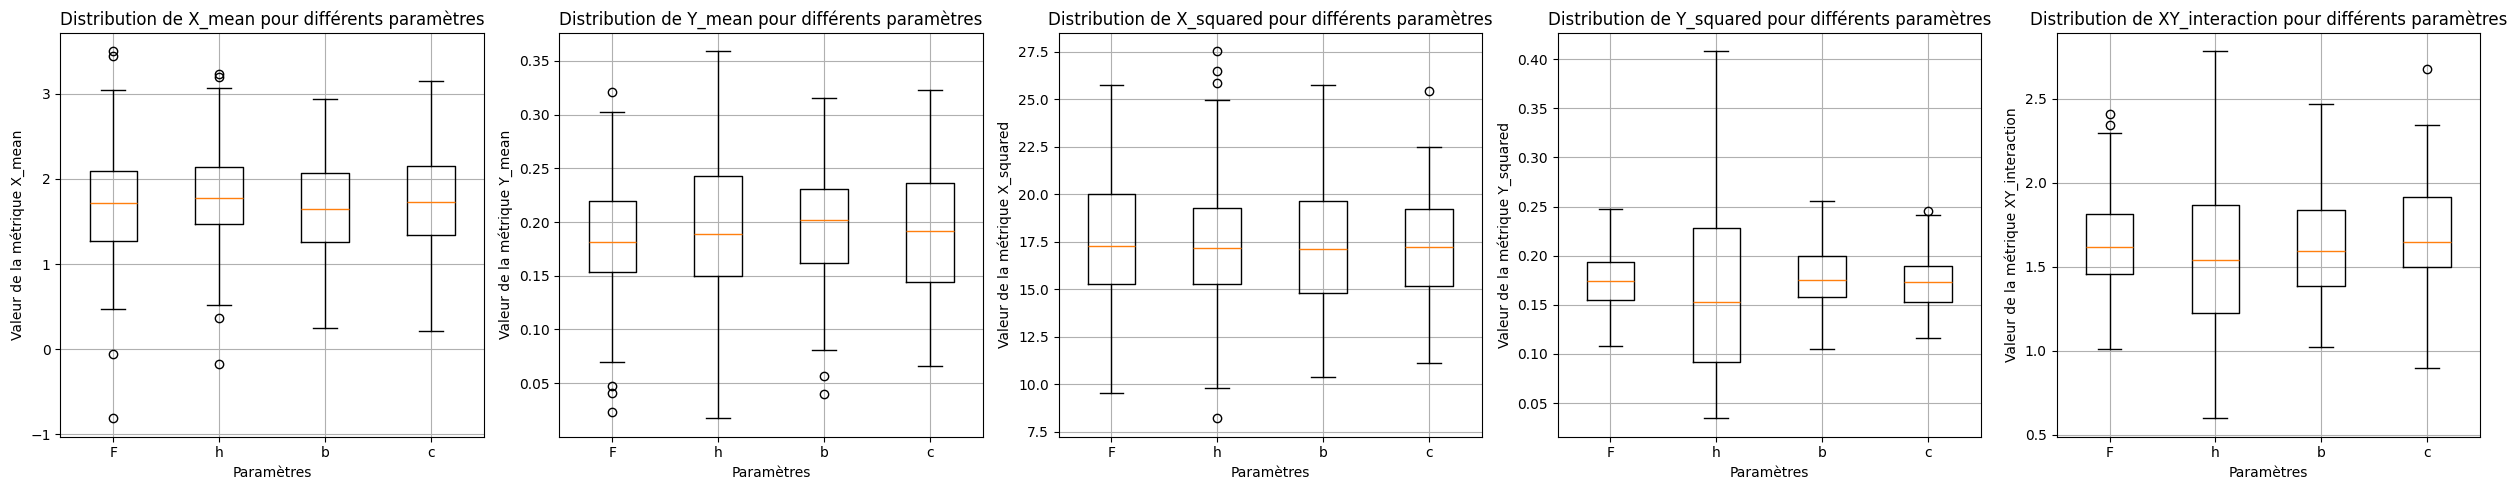

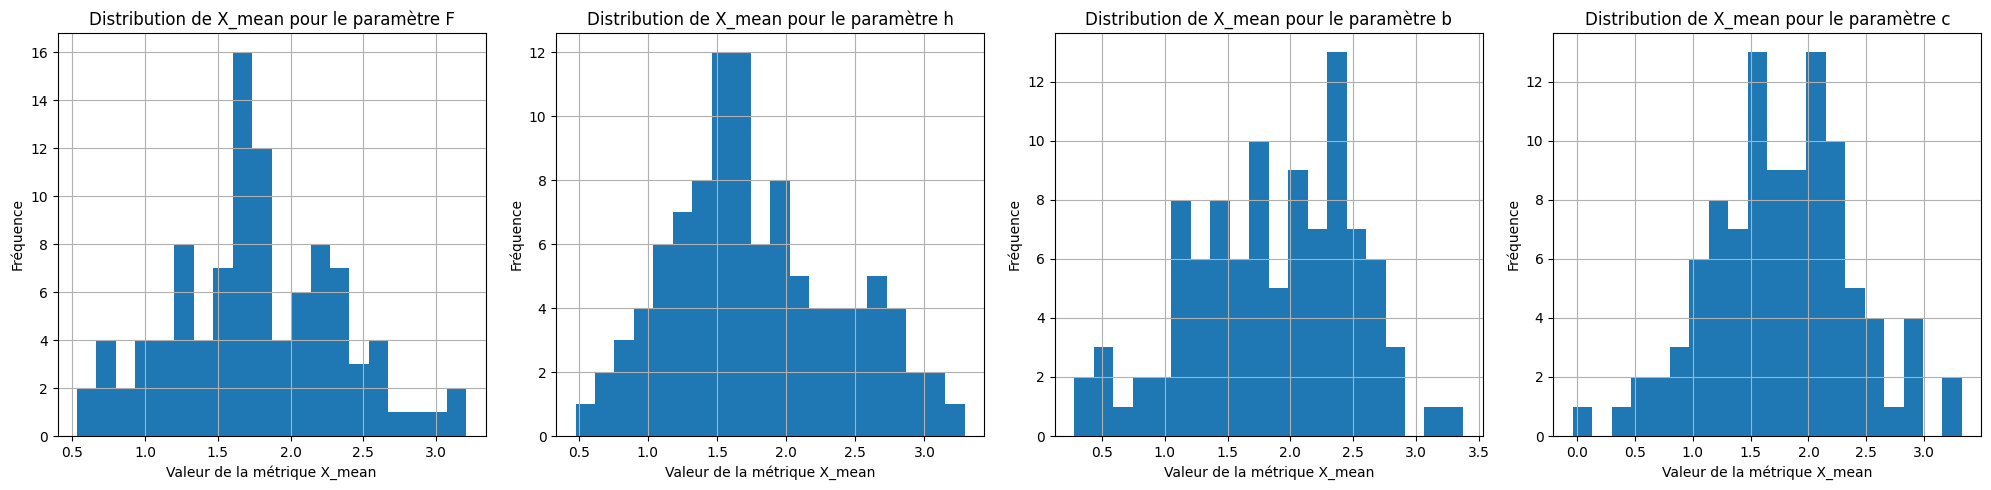

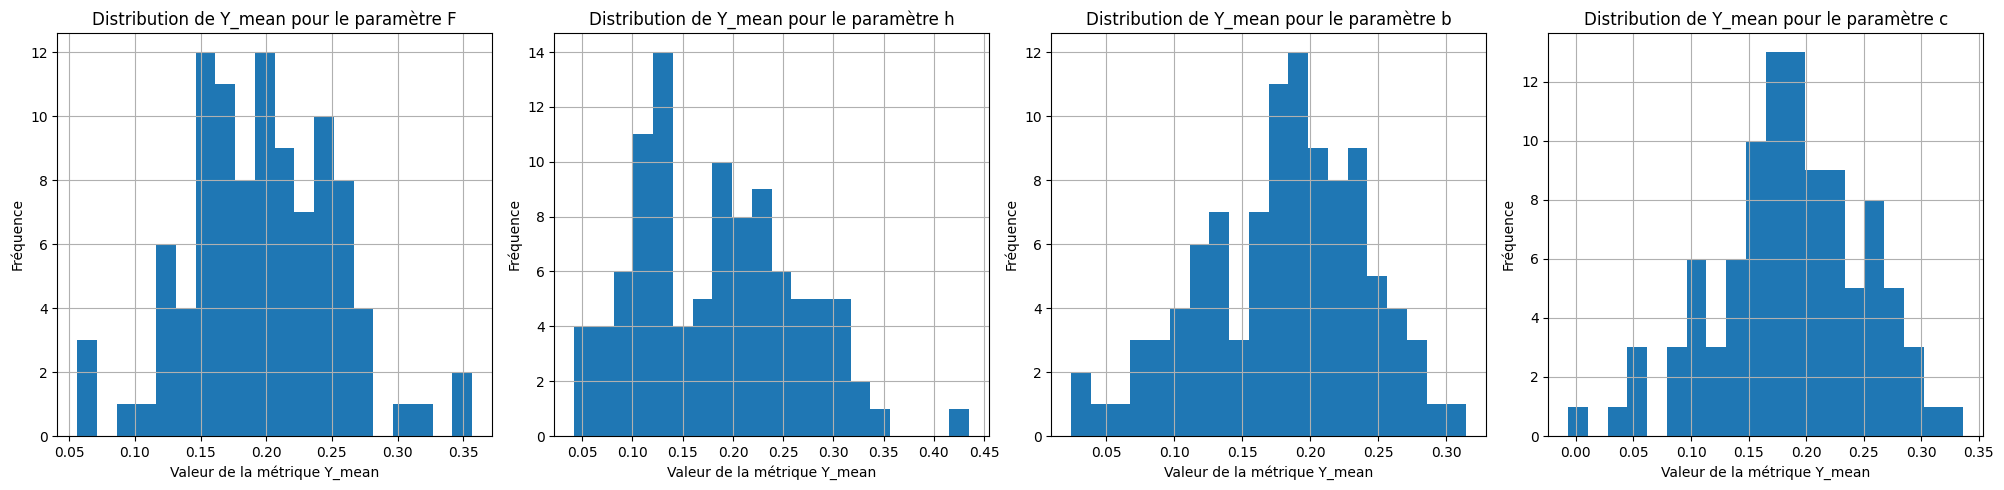

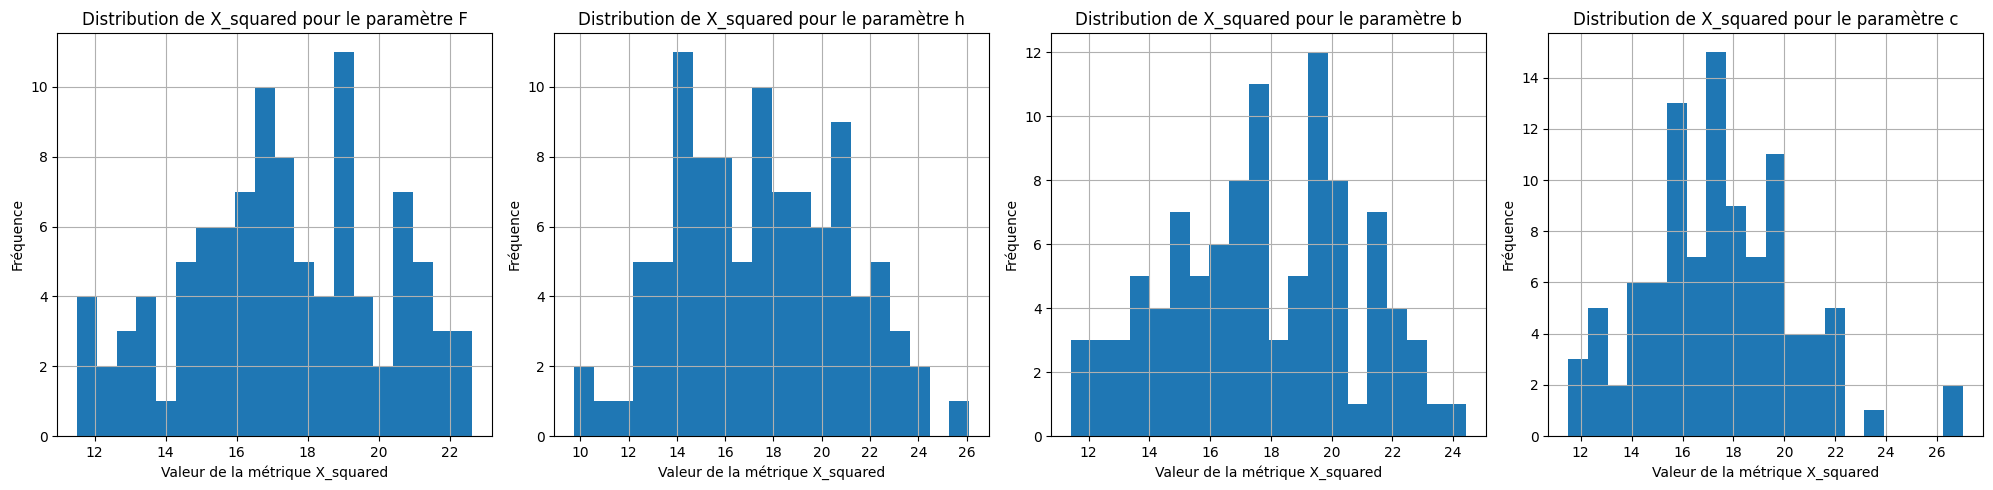

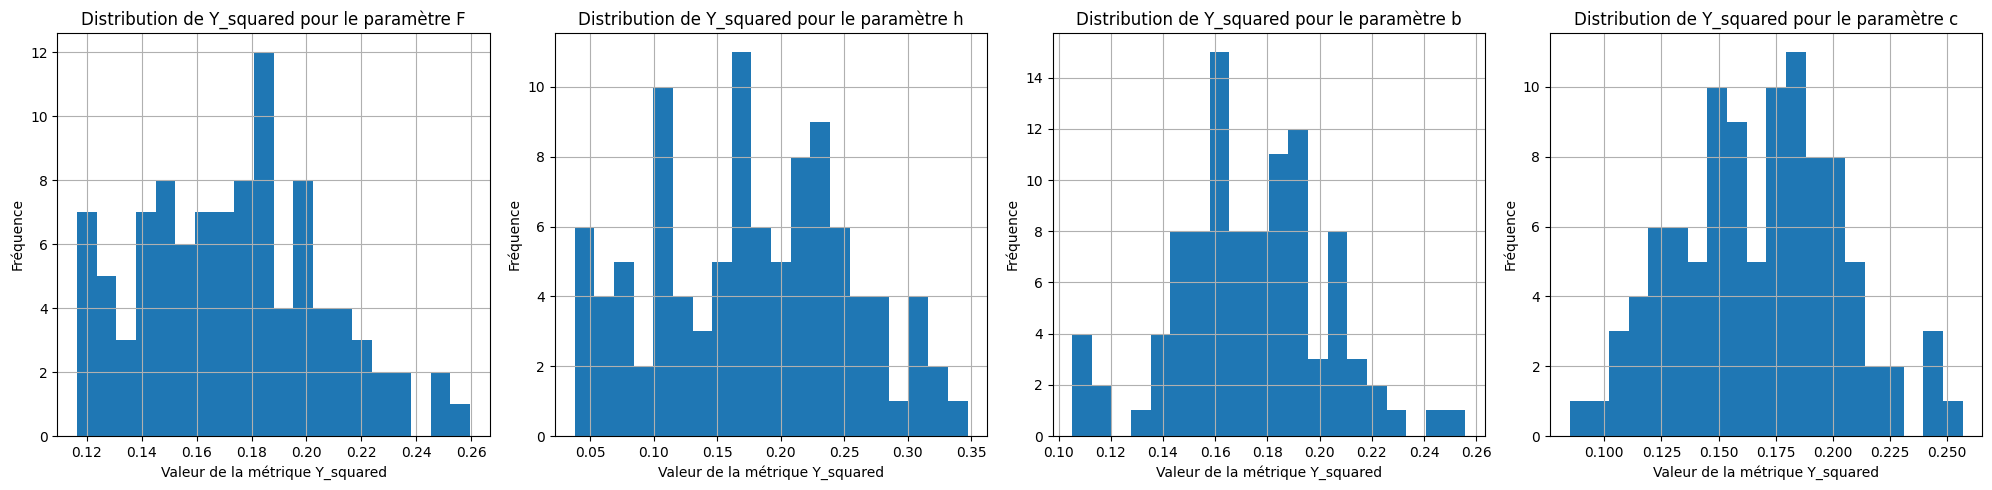

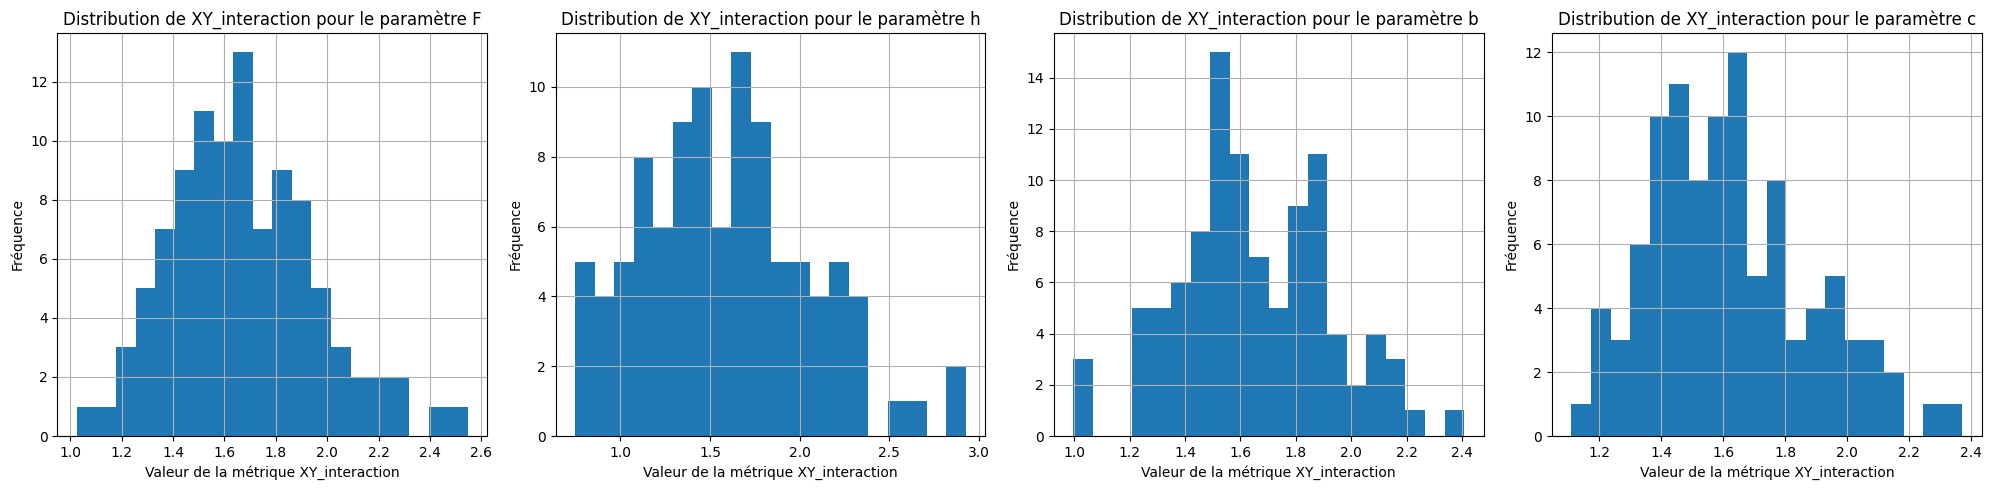

In [130]:
T = 10
dt = 0.01
n_samples = 100

plot_metrics_discrimination(priors, n_samples, T, dt)

# Analyse des Graphiques pour la Calibration ABC du Modèle Lorenz 96

D'accord, je vais reprendre l'analyse des graphiques en utilisant des termes plus simples et des explications plus claires, en me concentrant toujours sur leur utilité pour ton étude de calibration ABC du modèle Lorenz 96.

## Objectif : Trouver de Bonnes Métriques

L'idée est de s'assurer que les mesures qu'on utilise pour comparer les simulations de notre modèle avec des observations réelles (ou idéales) soient suffisamment "bonnes". On cherche donc à vérifier que :

- **Sensibilité aux paramètres :** Une "bonne" mesure doit changer quand les paramètres changent. Si un paramètre est important, la mesure doit changer quand ce paramètre change.

- **Discrimination des simulations :** Une "bonne" mesure doit permettre de distinguer les simulations proches des données observées de celles qui en sont éloignées.

## Analyse des Graphiques (En Termes Simples)

On va regarder deux types de graphiques pour évaluer la qualité de nos mesures.

### Boxplots (Première Ligne des Graphiques)

- **Qu'est-ce que c'est ?** Un boxplot est comme un résumé de la distribution des valeurs d'une métrique. Chaque "boîte" représente un paramètre et montre le plus petit, le plus grand, et le milieu des valeurs de cette métrique pour le paramètre donné.

- **Ce qu'on regarde :** On regarde si les boîtes sont à peu près au même endroit, ou si elles sont très différentes.

- **Ce que ça veut dire :**
  - Si les boîtes se chevauchent beaucoup, cela signifie que la métrique n'est pas très sensible aux changements de ce paramètre.
  - Si les boîtes sont différentes, cela signifie que le paramètre a une influence sur la métrique, et que la métrique peut mettre en évidence les différences entre les paramètres.

### Histogrammes (Lignes Suivantes des Graphiques)

- **Qu'est-ce que c'est ?** Un histogramme montre comment les valeurs d'une métrique se répartissent.

- **Ce qu'on regarde :** On regarde comment la forme de l'histogramme change en fonction des paramètres.

- **Ce que ça veut dire :**
  - Si les histogrammes sont tous pareils, cela indique que la métrique n'est pas sensible à ce paramètre.
  - Si les histogrammes sont différents, cela signifie que le paramètre a une influence sur la distribution de la métrique.

## Analyse des Graphiques (Métrique par Métrique)

### X_mean (Moyenne de X) :
- **Boxplots :** Les boîtes se chevauchent beaucoup, indiquant que les paramètres ont peu d'influence sur X_mean.
- **Histogrammes :** Les histogrammes sont très semblables. 
- **En clair :** Cette métrique n'est pas très utile pour choisir les bons paramètres de ton modèle.

### Y_mean (Moyenne de Y) :
- **Boxplots :** Les boîtes se chevauchent beaucoup.
- **Histogrammes :** Les histogrammes sont semblables.
- **En clair :** Y_mean présente les mêmes problèmes que X_mean et n'est pas informative pour tes paramètres.

### X_squared (Moyenne de X au carré) :
- **Boxplots :** Les boîtes montrent une légère différence.
- **Histogrammes :** Ils commencent à se différencier, mais restent similaires.
- **En clair :** X_squared est un peu plus discriminante que X_mean et Y_mean, mais reste limitée.

### Y_squared (Moyenne de Y au carré) :
- **Boxplots :** Les boîtes se chevauchent, avec une légère variation.
- **Histogrammes :** Les histogrammes sont un peu différents, mais pas très flagrant.
- **En clair :** Cette métrique n'est pas beaucoup plus discriminante que les précédentes.

### XY_interaction (Moyenne de X multipliée par la moyenne de Y) :
- **Boxplots :** Les boîtes se chevauchent beaucoup.
- **Histogrammes :** Les histogrammes se ressemblent énormément.
- **En clair :** La métrique XY_interaction n'est pas discriminante.

## Conclusions Importantes

- **Métriques basées sur la moyenne :** Toutes tes métriques basées sur la moyenne (X_mean, Y_mean, X_squared, Y_squared, XY_interaction) ne sont pas très bonnes, car elles ne permettent pas de différencier l'effet des paramètres sur le modèle.

- **Distributions se chevauchent :** Les distributions des métriques se ressemblent pour des valeurs de paramètres différentes. Cela signifie qu'il est difficile pour l'algorithme ABC de faire des différences en utilisant ces métriques.

- **Bornes des paramètres :** Il est possible que les bornes que tu utilises pour tes paramètres soient trop petites, ce qui limite la détection de l'effet des paramètres sur les métriques.

## Ce qu'il faut faire maintenant

- **Utiliser d'autres métriques :** Explore d'autres métriques, qui soient plus sensibles aux variations de tes paramètres (par exemple, les métriques temporelles que l'on a discutées).

- **Valider tes métriques :** Refais ce type d'analyse avec tes nouvelles métriques.

- **Choisir tes métriques :** Réfléchis bien à la métrique qui est appropriée pour ton modèle, et pour ce que tu souhaites mettre en évidence.



### Avantages :
- Permet de voir facilement si tes métriques sont bien informatives pour les paramètres, et si les distributions sont bien séparées.

### Inconvénients :
- Ne prend pas en compte les interactions entre les paramètres.
- Le boxplot peut être moins parlant si la distribution des métriques est très particulière.

## En résumé :

- **Visualise :** Trace des diagrammes en nuage de points et des boxplots pour visualiser la relation entre chaque métrique et chaque paramètre.
- **Analyse :** Regarde si tes métriques sont sensibles aux paramètres et si tes distributions sont bien séparées.
- **Choisis les bonnes métriques :** Si une métrique ne semble pas très informative, tu peux choisir d'autres métriques, ou une combinaison de plusieurs métriques.


In [ ]:
# Copyright 2025 ensai
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



### **VI/ Choix des métriques : Pour valider que tes métriques sont bien informatives.**



## Voici comment tu peux procéder pour analyser le choix de tes métriques :

### 1. Comprendre le Rôle des Métriques dans l'ABC Rejection

- **Objectif :** Les métriques servent de résumé des données simulées. Elles permettent de comparer les simulations aux données observées (par l'intermédiaire d'une fonction de distance).

- **Importance :** Si les métriques sont peu informatives, l'algorithme ABC aura du mal à distinguer les simulations qui sont proches des données observées, et il risque d'accepter des simulations avec des paramètres erronés. Des métriques peu informatives conduisent à des distributions a posteriori qui sont très étalées, et qui ne permettent pas d'obtenir une bonne calibration des paramètres.

- **Métriques informatives :** Des bonnes métriques doivent :
  - Être sensibles aux variations des paramètres que tu souhaites calibrer.
  - Être capables de discriminer les simulations qui sont proches des observations et celles qui en sont loin.

### 2. Analyse de l'Influence des Paramètres sur les Métriques

**Principe :** L'objectif est de vérifier que tes métriques (X_mean, Y_mean, X_squared, Y_squared et XY_interaction) varient de manière significative lorsque tu changes les valeurs de tes paramètres (F, h, b, et c).

#### Comment faire :

- **Utilise tes simulations :** Tu peux utiliser des données que tu as déjà simulées (par exemple, les simulations acceptées par ton algorithme ABC) avec différentes valeurs de paramètres, et tu calcules les métriques à partir de ces simulations.

- **Visualise les relations :** Crée des diagrammes en nuage de points qui mettent en relation :
  - Un paramètre (par exemple F) en abscisse.
  - Une métrique (par exemple X_mean) en ordonnée.

#### Interprète :

- **Si les points sont alignés sur une droite ou une courbe,** cela signifie que la métrique varie avec le paramètre, et elle est informative pour ce paramètre.
- **Si les points sont dispersés, sans tendance claire,** cela indique que la métrique n'est pas très sensible au paramètre.



## Idée Principale
Évaluer la sensibilité de nos outils de mesure pour comparer les simulations de notre modèle (Lorenz 96) avec des observations.

### Le But
Vérifier si les métriques que nous utilisons sont suffisamment sensibles aux changements des paramètres.

### Pourquoi c'est important
Si les métriques ne sont pas sensibles, l'algorithme ABC aura du mal à trouver les "bons" paramètres. On ne pourra pas distinguer des résultats qui sont "bons" de ceux qui sont "mauvais", car les métriques donneront la même valeur dans les deux cas.

### Analogie
Imagine que tu essaies de trouver la bonne clé d'un cadenas, et que toutes les clés mesurent la même taille. Comment vas-tu faire pour choisir la bonne clé ?

## Ce qu'on fait concrètement (En Détail)

### generate_influence_data

- **Un paramètre à la fois :** On choisit un paramètre (par exemple, F) que l'on va faire varier.
- **Paramètres constants :** Les valeurs des autres paramètres (h, b, c) sont fixées, en utilisant leur valeur centrale (calculée à partir de leurs priors).
- **Simulations :** On fait tourner notre modèle (Lorenz 96) plusieurs fois, en utilisant différentes valeurs du paramètre choisi, tout en gardant les autres paramètres constants.
- **Calcul des métriques :** Pour chaque simulation, on calcule les valeurs des métriques que l'on veut étudier (par exemple, `X_mean`, `autocorr_X_lag1`, etc.). Cela nous donne une liste de valeurs pour chaque métrique.
- **Répétition pour tous les paramètres :** La fonction effectue cette opération pour tous les paramètres (F, h, b, c).
- **Stockage des résultats :** La fonction retourne un dictionnaire où les clés sont les noms des paramètres, et les valeurs sont des listes contenant les valeurs de chaque métrique.

### plot_influence_all

- **Visualisation :** On crée des graphiques pour toutes les combinaisons entre un paramètre et une métrique. Pour chaque graphique :
  - L'axe horizontal représente les valeurs d'un paramètre (que l'on fait varier).
  - L'axe vertical représente les valeurs de la métrique que l'on étudie.
  - Les points représentent les couples (paramètre, métrique) obtenus avec `generate_influence_data`.

- **Analyse Visuelle :** On utilise ces graphiques pour observer :
  - **Comment la métrique change :** Est-ce que les valeurs de la métrique augmentent, diminuent ou restent constantes quand la valeur du paramètre change ?
  - **Sensibilité :** Est-ce que la métrique est sensible aux variations du paramètre (si les points sont alignés), ou peu sensible (si les points sont dispersés) ?

## Interprétation des Résultats

- **generate_influence_data :** Cette fonction fournit les données nécessaires pour la visualisation, en te donnant, pour un paramètre donné, toutes les valeurs des métriques obtenues pour les simulations.

- **plot_influence_all :** Cette fonction permet de visualiser la relation entre les paramètres à calibrer et les métriques choisies pour la méthode ABC.

### Métriques informatives
Si les graphiques montrent que tes métriques sont sensibles à tes paramètres (les points suivent une relation claire : courbe ou droite), cela signifie que tes métriques sont "bonnes" et capables de "capturer" les changements de ton modèle.

### Métriques non informatives
Si les graphiques montrent que tes métriques ne sont pas sensibles à tes paramètres (les points sont dispersés), cela indique que tes métriques sont peu utiles, car la valeur de la métrique n'est pas affectée par les changements des paramètres du modèle.

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des paramètres
T = 10
dt = 0.01

# Paramètre à analyser
param_name = "F"
n_samples = 100



In [105]:
priors[param_name]

(9.5, 10.5)

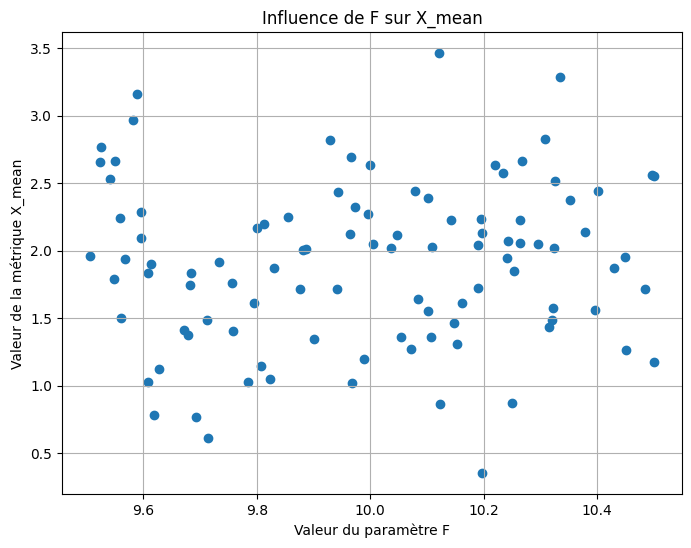

In [106]:
# 2. Créer un échantillon de valeurs du paramètre
param_values = np.random.uniform(priors[param_name][0], priors[param_name][1], size=n_samples)

# Listes pour stocker les valeurs de la métrique
metric_values = []

# 3. Faire tourner le modèle et calculer la métrique
for param_value in param_values:
    params_dict = {key: np.mean(priors[key]) for key in priors} # valeurs centrales de chaque paramètres
    params_dict[param_name] = param_value
    X, Y = lorenz96_two_equations(**params_dict, T=T, dt=dt)
    metrics = calculate_metrics(X, Y, T)
    metric_values.append(metrics["X_mean"])

# 4. Visualiser la relation
plt.figure(figsize=(8, 6))
plt.scatter(param_values, metric_values)
plt.xlabel(f"Valeur du paramètre {param_name}")
plt.ylabel("Valeur de la métrique X_mean")
plt.title(f"Influence de {param_name} sur X_mean")
plt.grid(True)
plt.show()


### Description du Graphique

- **Type :** Diagramme de dispersion (scatter plot)
  
- **Axe horizontal (X) :** Valeur du paramètre F. Les bornes des priors de F sont entre 8 et 12, et on peut voir que les valeurs de F s'étendent de 9.6 à 10.4.

- **Axe vertical (Y) :** Valeur de la métrique X_mean. On peut voir que la valeur de cette métrique varie entre 0.3 et 3.5.

- **Points :** Chaque point représente une simulation. La position du point en X indique la valeur du paramètre F utilisée dans la simulation. La position du point en Y indique la valeur de la métrique X_mean calculée à partir de cette simulation.

### Analyse et Interprétation Rapide

- **Dispersion :** La première chose qui frappe dans ce graphique, c'est la forte dispersion des points. Ils ne sont pas du tout alignés sur une ligne ou une courbe, mais plutôt éparpillés dans le graphe.

- **Absence de Tendance Claire :** Il n'y a pas de relation claire entre la valeur du paramètre F et la valeur de la métrique X_mean. Quand la valeur de F varie, la valeur de la métrique X_mean ne varie pas beaucoup et dans une direction non prévisible.

- **Absence de Sensibilité :** La forte dispersion indique que la métrique X_mean est très peu sensible aux variations du paramètre F, pour ces bornes. Autrement dit, même si tu fais varier la valeur de F, la valeur de X_mean ne change pas de façon prévisible.

- **Métrique peu informative :** Ce graphique montre que la métrique X_mean ne permet pas de bien discriminer les différentes valeurs du paramètre F. On peut dire que X_mean est peu informative pour le paramètre F (dans le contexte de tes valeurs de simulation).

- **Influence non linéaire :** Le fait que l'on ait une dispersion et pas de relation claire indique que l'influence du paramètre sur la métrique est peut-être non-linéaire.

### Implications

- **Choix de la métrique :** Puisque X_mean n'est pas une métrique très informative pour le paramètre F, il faut peut-être utiliser d'autres métriques (ou des combinaisons de métriques) si tu souhaites faire une calibration efficace du paramètre F.

- **Analyse de sensibilité globale :** Il est important de coupler cette analyse avec une analyse de sensibilité globale (comme la méthode de Morris) pour confirmer cette observation, et aussi pour vérifier l'influence sur les autres métriques, et pour étudier l'influence des interactions entre les différents paramètres.

- **Limitations de l'ABC :** Si tu continues à utiliser X_mean, ton algorithme ABC aura probablement du mal à estimer les bonnes valeurs du paramètre F, car la métrique n'est pas très sensible aux changements de ce paramètre.

- **Influence sur les distributions :** Cette faible sensibilité de la métrique au paramètre aura un impact sur les distributions a posteriori de l'ABC, car elles seront très étalées, et avec une grande incertitude.

### En Résumé

Ce graphique montre que la métrique X_mean n'est pas très appropriée pour calibrer le paramètre F. Il est essentiel de bien choisir les métriques car cela peut avoir un impact significatif sur la qualité des résultats de ton algorithme ABC.


In [109]:
def generate_influence_data(priors, n_samples, param_name, T=10, dt=0.01):
    """
    Génère les données pour l'analyse de l'influence d'un paramètre sur les métriques.

    Paramètres :
    -----------
    priors : dict
        Dictionnaire contenant les bornes des distributions a priori pour chaque paramètre.
    n_samples : int
        Nombre d'échantillons à générer.
    param_name : str
        Nom du paramètre à étudier.
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).

    Retourne :
    ---------
    tuple(ndarray, dict):
        Un tuple contenant les valeurs des paramètres et les valeurs des métriques.
    """
    # Créer un échantillon de valeurs du paramètre
    param_values = np.random.uniform(priors[param_name][0], priors[param_name][1], size=n_samples)
    all_metric_values = {
      "X_mean": [],
       "Y_mean": [],
        "X_squared": [],
        "Y_squared": [],
        "XY_interaction":[]
    }
    # Faire tourner le modèle et calculer les métriques
    for param_value in param_values:
        params_dict = {key: np.mean(priors[key]) for key in priors} # valeurs centrales de chaque paramètres
        params_dict[param_name] = param_value
        X, Y = lorenz96_two_equations(**params_dict, T=T, dt=dt)
        metrics = calculate_metrics(X, Y, T)
        all_metric_values["X_mean"].append(metrics["X_mean"])
        all_metric_values["Y_mean"].append(metrics["Y_mean"])
        all_metric_values["X_squared"].append(metrics["X_squared"])
        all_metric_values["Y_squared"].append(metrics["Y_squared"])
        all_metric_values["XY_interaction"].append(metrics["XY_interaction"])
    return param_values, all_metric_values


def plot_influence_all(priors, n_samples, T=10, dt=0.01):
    """
    Affiche les graphiques d'influence pour toutes les combinaisons de paramètres et de métriques.

    Paramètres :
    -----------
    priors : dict
        Dictionnaire contenant les bornes des distributions a priori pour chaque paramètre.
    n_samples : int
        Nombre d'échantillons à générer.
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).
    """

    param_names = list(priors.keys())
    metric_names = ["X_mean", "Y_mean", "X_squared", "Y_squared", "XY_interaction"]

    # Définir le nombre de colonnes et de lignes pour la grille
    n_cols = 4
    n_rows = (len(metric_names) * len(param_names) + n_cols - 1) // n_cols

    # Créer une figure avec plusieurs sous-graphes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()  # Aplatir la matrice d'axes

    # Boucle sur les paramètres et les métriques
    for i, param_name in enumerate(param_names):
        param_values, all_metric_values = generate_influence_data(priors, n_samples, param_name, T, dt)
        for j, metric_name in enumerate(metric_names):
            ax = axes[i * len(metric_names) + j]  # Accéder à l'axe approprié
            ax.scatter(param_values, all_metric_values[metric_name])
            ax.set_xlabel(f"Valeur du paramètre {param_name}")
            ax.set_ylabel(f"Valeur de la métrique {metric_name}")
            ax.set_title(f"Influence de {param_name} sur {metric_name}")
            ax.grid(True)

    # Masquer les axes inutilisés si nécessaire
    for k in range(i * len(metric_names) + j + 1, len(axes)):
        fig.delaxes(axes[k])  # Supprimer les axes vides

    plt.tight_layout()  # Ajuster l'espacement
    plt.show()

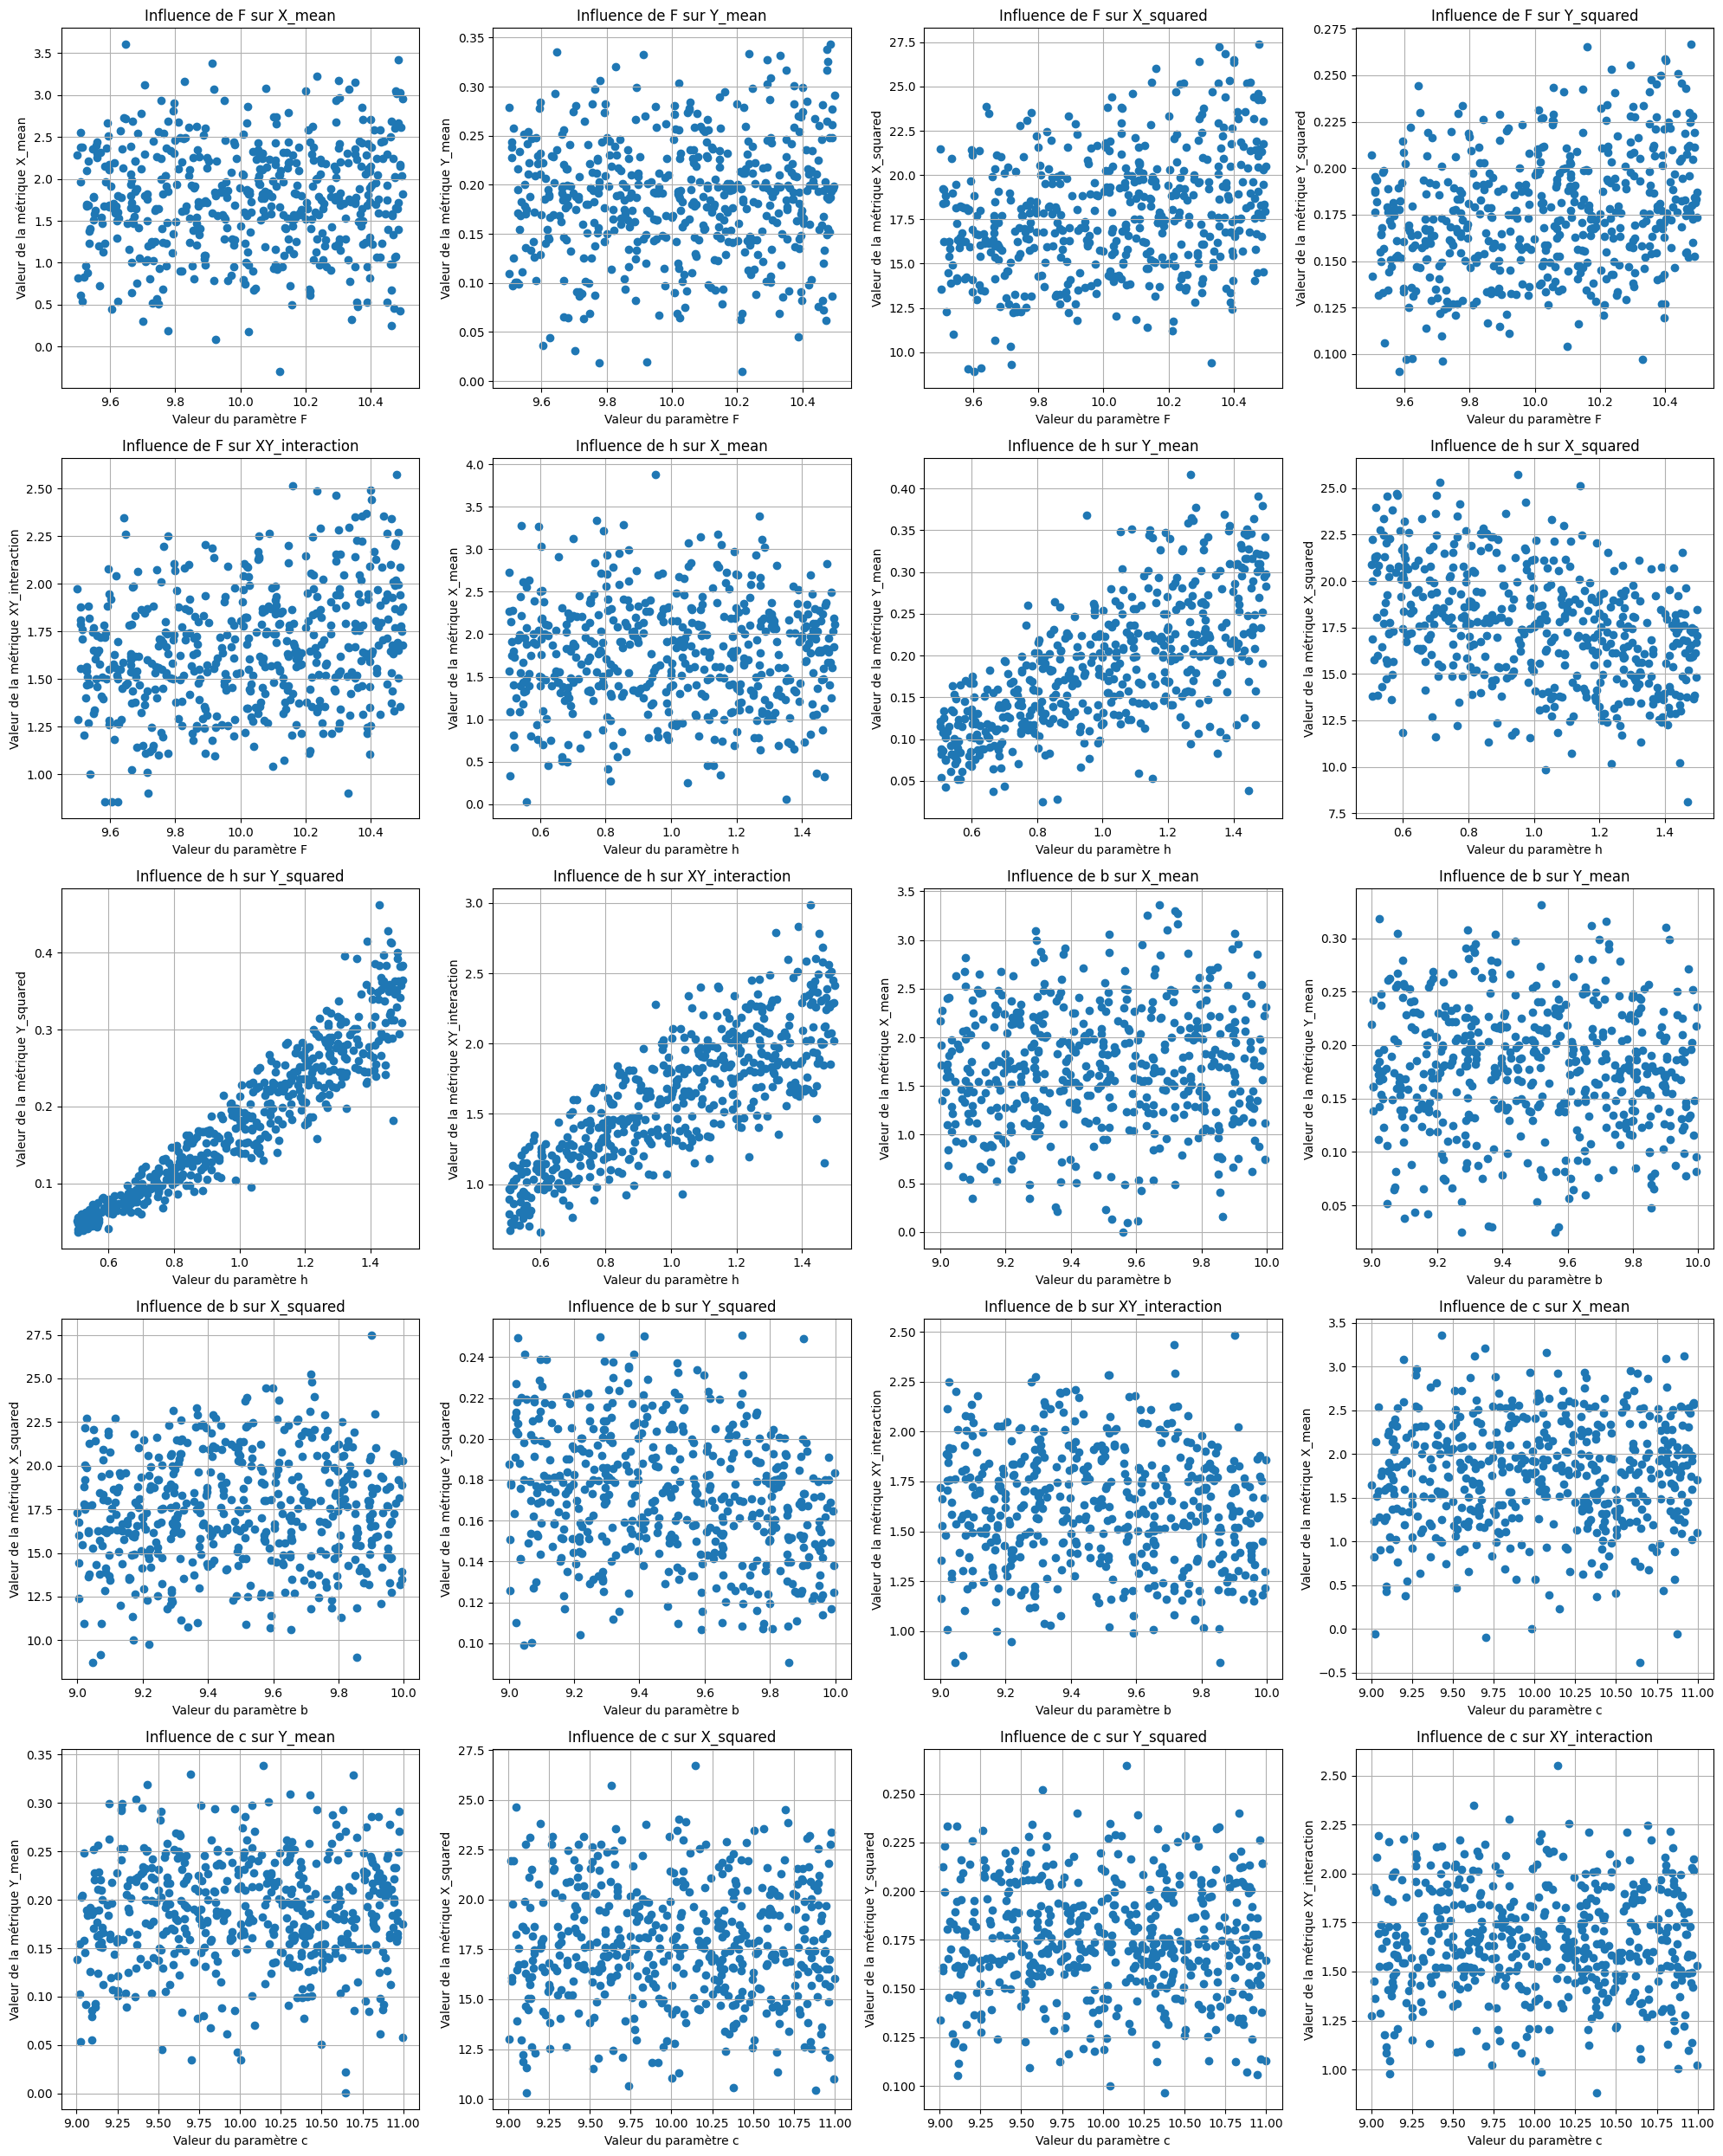

In [112]:
T = 10
dt = 0.01
n_samples = 500


    # Plot the influence of every parameters on every metric
plot_influence_all(priors, n_samples, T, dt)


## Méthodologie d'Analyse

Pour chaque graphique, on va examiner :

- **La dispersion des points :** Est-ce que les points sont alignés sur une tendance claire ou sont-ils éparpillés ?
  
- **La présence de tendances :** Y a-t-il une relation croissante ou décroissante entre le paramètre et la métrique ?
  
- **La sensibilité :** Dans quelle mesure la métrique semble changer lorsque le paramètre varie ?
  
- **Les valeurs extrêmes :** Y a-t-il des valeurs extrêmes de la métrique qui pourraient être intéressantes ?
  
- **Comparaison des graphes :** Comparer les graphes entre eux afin de voir si l'on retrouve des tendances similaires.

## Analyse des Graphiques (Paramètre par Paramètre)

### 1. Paramètre F

- **Influence sur X_mean :** Les points sont dispersés sans tendance claire. X_mean ne semble pas très sensible à F.

- **Influence sur Y_mean :** Les points sont dispersés. Y_mean ne semble pas très sensible à F. On observe cependant que les valeurs sont autour de 0.2 pour l'ensemble des simulations.

- **Influence sur X_squared :** Les points sont dispersés, mais on a une tendance générale de X_squared à diminuer lorsque F augmente. Il y a une relation un peu plus marquée sur ce graphe.

- **Influence sur Y_squared :** Les points sont assez dispersés et il n'y a pas de relation claire entre F et Y_squared.

- **Influence sur XY_interaction :** Les points sont assez dispersés, avec des variations importantes de la métrique pour des valeurs de F similaires. La métrique XY_interaction semble peu sensible aux variations du paramètre F.

**Conclusion sur F :** Le paramètre F n'a pas une forte influence sur les métriques que tu utilises.

### 2. Paramètre h

- **Influence sur X_mean :** Les points sont dispersés, sans relation claire entre h et X_mean. Il y a une tendance à un léger déclin de la métrique quand h augmente.

- **Influence sur Y_mean :** Les points sont dispersés. La métrique Y_mean semble peu sensible au paramètre h.

- **Influence sur X_squared :** On voit une tendance à la diminution de la métrique X_squared quand h augmente. Il y a une relation plus nette sur ce graphe.

- **Influence sur Y_squared :** On observe une relation positive assez claire. Quand la valeur de h augmente, la valeur de la métrique Y_squared augmente aussi. On voit aussi que la métrique varie entre 0.1 et 0.4, ce qui est une plage de valeurs assez importante.

- **Influence sur XY_interaction :** Il y a une relation positive assez claire, même si quelques points sont plus dispersés. Quand h augmente, la métrique XY_interaction augmente aussi.

**Conclusion sur h :** Le paramètre h semble avoir une influence claire sur les métriques Y_squared et XY_interaction. L'influence sur X_mean, Y_mean et X_squared est moins importante, ou de nature plus complexe.

### 3. Paramètre b

- **Influence sur X_mean :** On observe une forte dispersion, même si l'on peut observer une tendance générale à la baisse de la métrique quand b augmente.

- **Influence sur Y_mean :** On observe une dispersion, avec une tendance très légère à la baisse. La relation est loin d'être claire.

- **Influence sur X_squared :** On observe une dispersion des points. La relation entre la métrique X_squared et le paramètre b n'est pas claire.

- **Influence sur Y_squared :** Les points sont dispersés et il n'y a pas de relation claire.

- **Influence sur XY_interaction :** On observe une dispersion. La relation entre b et la métrique XY_interaction est faible.

**Conclusion sur b :** Le paramètre b a peu d'influence directe sur les métriques. Il faudrait peut-être explorer d'autres métriques, ou d'autres combinaisons de métriques pour ce paramètre.

### 4. Paramètre c

- **Influence sur X_mean :** On observe une forte dispersion, et une relation positive très faible. L'influence du paramètre c sur la métrique X_mean est très faible.

- **Influence sur Y_mean :** On observe une dispersion, avec des valeurs de métriques qui sont comprises dans un intervalle assez réduit, entre 0 et 0.4. Il n'y a pas de tendance claire.

- **Influence sur X_squared :** On observe une forte dispersion des points. L'influence de c sur X_squared est très faible.

- **Influence sur Y_squared :** On observe une dispersion. Il semble que la métrique augmente quand c augmente, mais avec une relation assez variable.

- **Influence sur XY_interaction :** On observe une dispersion. Il semble que la métrique augmente quand c augmente, mais avec une relation peu claire.

**Conclusion sur c :** On observe une relation plus claire sur les métriques Y_squared et XY_interaction, mais de manière générale, le paramètre c ne semble pas avoir une grande influence sur les métriques dans la plage de valeurs que tu utilises pour ta simulation.

## Conclusions Générales

- **Choix des métriques :** Tes métriques (X_mean, Y_mean, X_squared, Y_squared, XY_interaction) sont peu sensibles aux variations des paramètres (F, b, et c). Seules Y_squared et XY_interaction semblent fortement influencées par le paramètre h. Il est donc nécessaire d'explorer d'autres métriques ou une combinaison de métriques, afin d'avoir une meilleure calibration des paramètres.

- **Limites de l'analyse locale :** Ces graphiques montrent les limites de l'analyse de sensibilité locale. Il faut compléter cette analyse avec une analyse de sensibilité globale, pour voir comment les paramètres interagissent entre eux. De plus, ces graphes sont limités par le fait qu'ils sont faits dans une zone restreinte des paramètres, et il faudrait faire une analyse dans l'ensemble de l'espace des paramètres.

- **Paramètres importants :** Le paramètre h semble être le plus important parmi les 4 paramètres, car il a un impact significatif sur les métriques Y_squared et XY_interaction. Les autres paramètres (F, b et c) ont moins d'influence. Il serait intéressant de calculer d'autres métriques qui soient plus sensibles à F, b, et c.

- **Besoin d'une approche plus avancée :** Une analyse locale a donc des limites. Les méthodes d'analyse de sensibilité globale (comme la méthode de Morris) peuvent t'aider à avoir une meilleure compréhension du comportement de ton modèle.

## Prochaines Étapes

- **Choisir d'autres métriques :** Il serait intéressant d'explorer d'autres métriques qui sont peut-être plus sensibles à tes paramètres. Tu peux utiliser des métriques basées sur les séries temporelles, par exemple, pour extraire plus d'information des données générées par le modèle.

- **Analyse de sensibilité globale :** Tu peux compléter cette analyse visuelle avec les résultats de l'analyse de sensibilité globale, en particulier avec la méthode de Morris.

- **Explorer l'espace des paramètres :** Augmenter l'espace des paramètres afin de bien explorer toutes les zones de l'espace des paramètres, en particulier celles qui ont des valeurs fortes pour les métriques.



## metics supplementaires
## 1. Autocorrélation (avec un ou plusieurs lags)

### Pourquoi c'est pertinent :

- **Mémoire temporelle :** L'autocorrélation mesure la corrélation d'une série temporelle avec elle-même, décalée dans le temps. Dans un système chaotique, on s'attend à ce que les corrélations à long terme diminuent rapidement (perte de mémoire du système).

- **Sensibilité aux paramètres :** Le temps de décorrélation, qui est relié à l'autocorrélation, est souvent sensible aux paramètres du système, en particulier ceux qui influencent le caractère oscillatoire du système.

- **Complémentarité :** Elle apporte une information complémentaire aux moyennes et aux variances que tu utilises déjà.

### Comment l'utiliser :

- **Différents lags :** Calcule l'autocorrélation pour un ou plusieurs pas de temps (lag).

- **Temps de décorrélation :** Tu peux ensuite calculer le temps de décorrélation comme le pas de temps pour lequel l'autocorrélation passe en dessous d'un certain seuil.

## 2. Densité Spectrale de Puissance (avec caractéristiques clés)

### Pourquoi c'est pertinent :

- **Fréquences caractéristiques :** Les systèmes chaotiques ont souvent des fréquences dominantes et des structures harmoniques dans leur spectre fréquentiel. La densité spectrale permet de visualiser ces fréquences.

- **Identification des dynamiques :** Elle permet de voir si certains paramètres ont tendance à modifier les fréquences d'oscillations des variables X et Y.

- **Sensibilité :** Elle peut être plus sensible aux paramètres que les métriques simples que tu as utilisées.

### Comment l'utiliser :

- **Fréquence dominante :** Calcule la fréquence où la densité spectrale est maximale.

- **Largeur du pic dominant :** Calcule la largeur du pic principal, qui peut te donner une idée de l'énergie associée à cette fréquence.

- **Énergie totale :** Calcule l'énergie totale dans une certaine plage de fréquences (la somme de toutes les densités spectrales).

## 3. Exposant de Lyapunov

### Pourquoi c'est pertinent :

- **Mesure du chaos :** L'exposant de Lyapunov est une mesure directe du chaos dans le système. Un exposant positif indique un comportement chaotique, et la valeur de l'exposant indique l'intensité du chaos.

- **Sensibilité :** Il est souvent sensible aux paramètres du système.

- **Caractérisation du modèle :** Il permet de vérifier si le modèle est bien dans une région chaotique de l'espace des paramètres et permet de quantifier ce chaos.

### Comment l'utiliser :

- **Estimer le plus grand exposant de Lyapunov :** C'est souvent la valeur la plus informative.

## Pourquoi ces choix sont judicieux :

- **Caractère Temporel :** Ces métriques capturent des informations sur la dynamique temporelle des séries de données générées par le modèle Lorenz-96, alors que tes métriques actuelles sont plutôt des mesures globales.

- **Sensibilité aux paramètres :** Elles sont potentiellement plus sensibles aux variations de tes paramètres, ce qui est crucial pour la calibration.

- **Complémentarité :** Elles fournissent des informations complémentaires, comme l'intensité du chaos (exposant de Lyapunov), la mémoire du système (autocorrélation) ou les fréquences importantes (densité spectrale).

## Quelles métriques faut-il utiliser au départ ?

Si je devais choisir un nombre limité de métriques à utiliser au départ, je choisirais :

- **Autocorrélation (pour un pas de temps) ou Temps de Décorrélation :** Car elles sont simples à calculer et donnent une information temporelle.

- **Densité spectrale :** Pour vérifier que tu as des fréquences importantes et voir comment les paramètres les font varier.

- **Exposant de Lyapunov :** Pour avoir un aperçu direct du chaos dans ton système.

In [114]:
import numpy as np
from scipy.fft import fft
import nolds

def calculate_metrics_sup(X, Y, tau, lag=1):
    """
    Calcule des métriques supplémentaires sur X et Y : autocorrélation, densité spectrale, et exposant de Lyapunov.

    Paramètres :
    -----------
    X : ndarray
        Données des grandes échelles.
    Y : ndarray
        Données des petites échelles.
    tau : float
        Un paramètre qui n'est pas utilisé dans ce code, mais présent pour garder la même interface avec les autres fonctions `calculate_metrics`.
    lag : int
        Pas de temps pour le calcul de l'autocorrélation.

    Retourne :
    ---------
    dict :
        Dictionnaire contenant les nouvelles métriques.
    """
    # Autocorrélation pour X
    autocorr_X = np.correlate(X, X, mode='same') / np.sum(X**2)
    autocorr_X = autocorr_X[len(autocorr_X)//2:]
    autocorr_X_at_lag1 = autocorr_X[lag]

    # Autocorrélation pour Y
    Y_flattened = np.mean(Y, axis=1)  # Aplatir Y pour calculer l'autocorrélation. On moyenne Y sur la seconde dimension
    autocorr_Y = np.correlate(Y_flattened, Y_flattened, mode='same') / np.sum(Y_flattened**2)
    autocorr_Y = autocorr_Y[len(autocorr_Y)//2:]
    autocorr_Y_at_lag1 = autocorr_Y[lag]

    # Densité spectrale de puissance pour X
    fft_X = fft(X)
    psd_X = np.abs(fft_X)**2
    freqs_X = np.fft.fftfreq(len(X))
    psd_X_max_index = np.argmax(psd_X)
    psd_X_max_freq = np.abs(freqs_X[psd_X_max_index])

    # Densité spectrale de puissance pour Y
    fft_Y = fft(Y_flattened)
    psd_Y = np.abs(fft_Y)**2
    freqs_Y = np.fft.fftfreq(len(Y_flattened))
    psd_Y_max_index = np.argmax(psd_Y)
    psd_Y_max_freq = np.abs(freqs_Y[psd_Y_max_index])

    # Exposant de Lyapunov pour X
    lyap_exp_X = nolds.lyap_r(X)

     # Exposant de Lyapunov pour Y
    lyap_exp_Y = nolds.lyap_r(Y_flattened)
    return {
        "autocorr_X_lag1": autocorr_X_at_lag1,
        "autocorr_Y_lag1": autocorr_Y_at_lag1,
        "psd_X_max_freq": psd_X_max_freq,
        "psd_Y_max_freq": psd_Y_max_freq,
        "lyap_exp_X": lyap_exp_X,
         "lyap_exp_Y": lyap_exp_Y
    }

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import scipy.signal as signal
import nolds


def calculate_metrics_sup(X, Y, tau, lags=[1, 2, 5, 10], window_size=50):
    """
    Calcule des métriques supplémentaires sur X et Y : autocorrélation, densité spectrale, et exposant de Lyapunov.

    Paramètres :
    -----------
    X : ndarray
        Données des grandes échelles.
    Y : ndarray
        Données des petites échelles.
    tau : float
        Un paramètre qui n'est pas utilisé dans ce code, mais présent pour garder la même interface avec les autres fonctions `calculate_metrics`.
    lags : list of int
        Liste des pas de temps pour le calcul de l'autocorrélation.
    window_size : int
        Taille de la fenêtre glissante pour calculer la moyenne et variance locale

    Retourne :
    ---------
    dict :
        Dictionnaire contenant les nouvelles métriques.
    """
    # Autocorrélation pour X
    autocorr_X = np.correlate(X, X, mode='same') / np.sum(X**2)
    autocorr_X = autocorr_X[len(autocorr_X)//2:]
    autocorr_X_lags = {f"autocorr_X_lag{lag}": autocorr_X[lag] if lag < len(autocorr_X) else np.nan for lag in lags}  # On utilise nan s'il n'y a pas de valeur à ce lag

    # Autocorrélation pour Y
    Y_flattened = np.mean(Y, axis=1)
    autocorr_Y = np.correlate(Y_flattened, Y_flattened, mode='same') / np.sum(Y_flattened**2)
    autocorr_Y = autocorr_Y[len(autocorr_Y)//2:]
    autocorr_Y_lags = {f"autocorr_Y_lag{lag}": autocorr_Y[lag] if lag < len(autocorr_Y) else np.nan for lag in lags}

    # Densité spectrale de puissance pour X
    fft_X = fft(X)
    psd_X = np.abs(fft_X)**2
    freqs_X = np.fft.fftfreq(len(X))
    psd_X_max_index = np.argmax(psd_X)
    psd_X_max_freq = np.abs(freqs_X[psd_X_max_index])
    half_max = psd_X[psd_X_max_index] / 2 # On calcule la moitié du maximum du pic
    half_max_index = np.argmin(np.abs(psd_X-half_max)) # On cherche l'indice qui correspond à la fréquence qui est la plus proche de la moitié du maximum.
    psd_X_fwhm = np.abs(freqs_X[half_max_index]- freqs_X[psd_X_max_index])

    # Densité spectrale de puissance pour Y
    fft_Y = fft(Y_flattened)
    psd_Y = np.abs(fft_Y)**2
    freqs_Y = np.fft.fftfreq(len(Y_flattened))
    psd_Y_max_index = np.argmax(psd_Y)
    psd_Y_max_freq = np.abs(freqs_Y[psd_Y_max_index])
    half_max = psd_Y[psd_Y_max_index] / 2
    half_max_index = np.argmin(np.abs(psd_Y-half_max))
    psd_Y_fwhm = np.abs(freqs_Y[half_max_index]- freqs_Y[psd_Y_max_index])

     # Nombre de Maxima Locaux pour X
    peaks_X, _ = signal.find_peaks(X)
    n_max_X = len(peaks_X)

    # Nombre de Maxima Locaux pour Y
    peaks_Y, _ = signal.find_peaks(Y_flattened)
    n_max_Y = len(peaks_Y)


    # Moyenne et variance locales de X
    if len(X) > window_size : #On vérifie que l'on a au moins autant de point que la fenêtre, afin d'éviter des erreurs.
        moving_mean_X = np.mean(np.array([X[i:i+window_size] for i in range(len(X)-window_size)]), axis=1) # On calcule la moyenne avec une fenêtre de `window_size` éléments.
        moving_var_X = np.var(np.array([X[i:i+window_size] for i in range(len(X)-window_size)]), axis=1)
        mean_moving_mean_X = np.mean(moving_mean_X)
        mean_moving_var_X = np.mean(moving_var_X)
    else :
        mean_moving_mean_X = np.nan
        mean_moving_var_X = np.nan

    # Moyenne et variance locales de Y
    if len(Y_flattened) > window_size :
        moving_mean_Y = np.mean(np.array([Y_flattened[i:i+window_size] for i in range(len(Y_flattened)-window_size)]), axis=1)
        moving_var_Y = np.var(np.array([Y_flattened[i:i+window_size] for i in range(len(Y_flattened)-window_size)]), axis=1)
        mean_moving_mean_Y = np.mean(moving_mean_Y)
        mean_moving_var_Y = np.mean(moving_var_Y)
    else:
        mean_moving_mean_Y = np.nan
        mean_moving_var_Y = np.nan

    metrics = {
        **autocorr_X_lags,
        **autocorr_Y_lags,
        "psd_X_max_freq": psd_X_max_freq,
        "psd_Y_max_freq": psd_Y_max_freq,
         "psd_X_fwhm": psd_X_fwhm,
        "psd_Y_fwhm": psd_Y_fwhm,
        "n_max_X": n_max_X,
        "n_max_Y": n_max_Y,
        "mean_moving_mean_X": mean_moving_mean_X,
        "mean_moving_var_X": mean_moving_var_X,
        "mean_moving_mean_Y": mean_moving_mean_Y,
        "mean_moving_var_Y": mean_moving_var_Y
    }
    return metrics

def generate_influence_data(priors, n_samples, param_name, T=10, dt=0.01):
    """
    Génère les données pour l'analyse de l'influence d'un paramètre sur les métriques.

    Paramètres :
    -----------
    priors : dict
        Dictionnaire contenant les bornes des distributions a priori pour chaque paramètre.
    n_samples : int
        Nombre d'échantillons à générer.
    param_name : str
        Nom du paramètre à étudier.
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).

    Retourne :
    ---------
    tuple(ndarray, dict):
        Un tuple contenant les valeurs des paramètres et les valeurs des métriques.
    """
    # Créer un échantillon de valeurs du paramètre
    param_values = np.random.uniform(priors[param_name][0], priors[param_name][1], size=n_samples)
    all_metric_values = {}
    # Faire tourner le modèle et calculer les métriques
    for param_value in param_values:
        params_dict = {key: np.mean(priors[key]) for key in priors} # valeurs centrales de chaque paramètres
        params_dict[param_name] = param_value
        X, Y = lorenz96_two_equations(**params_dict, T=T, dt=dt)
        metrics = calculate_metrics_sup(X, Y, T) # j'utilise calculate_metrics_sup
        for key, value in metrics.items(): # on sauvegarde les résultats dans une liste en fonction du nom de la metrique.
                if key not in all_metric_values:
                     all_metric_values[key] = []
                all_metric_values[key].append(value)
    return param_values, all_metric_values

def plot_influence_all(priors, n_samples, T=10, dt=0.01):
    """
    Affiche les graphiques d'influence pour toutes les combinaisons de paramètres et de métriques.

    Paramètres :
    -----------
    priors : dict
        Dictionnaire contenant les bornes des distributions a priori pour chaque paramètre.
    n_samples : int
        Nombre d'échantillons à générer.
    T : float, optionnel
        Temps total de simulation (défaut : 10).
    dt : float, optionnel
        Pas de temps pour la simulation (défaut : 0.01).
    """

    param_names = list(priors.keys())
    metric_names = ["autocorr_X_lag1", "autocorr_Y_lag1", "psd_X_max_freq", "psd_Y_max_freq",  "psd_X_fwhm", "psd_Y_fwhm", "n_max_X", "n_max_Y", "mean_moving_mean_X", "mean_moving_var_X", "mean_moving_mean_Y", "mean_moving_var_Y"]

     # Définir le nombre de colonnes et de lignes pour la grille
    n_cols = 4
    n_rows = (len(metric_names) * len(param_names) + n_cols - 1) // n_cols

    # Créer une figure avec plusieurs sous-graphes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()  # Aplatir la matrice d'axes

    # Boucle sur les paramètres et les métriques
    for i, param_name in enumerate(param_names):
        param_values, all_metric_values = generate_influence_data(priors, n_samples, param_name, T, dt)
        for j, metric_name in enumerate(metric_names):
            ax = axes[i * len(metric_names) + j]  # Accéder à l'axe approprié
            if metric_name in all_metric_values: # On vérifie que la clé existe bien
                ax.scatter(param_values, all_metric_values[metric_name])
                ax.set_xlabel(f"Valeur du paramètre {param_name}")
                ax.set_ylabel(f"Valeur de la métrique {metric_name}")
                ax.set_title(f"Influence de {param_name} sur {metric_name}")
                ax.grid(True)
            else:
                 fig.delaxes(ax) # On supprime l'axe si on a pas de valeur.

    # Masquer les axes inutilisés si nécessaire
    for k in range(i * len(metric_names) + j + 1, len(axes)):
        if axes[k] in fig.axes : #on vérifie que l'axe n'a pas déja été retiré
            fig.delaxes(axes[k])  # Supprimer les axes vides

    plt.tight_layout()  # Ajuster l'espacement
    plt.show()



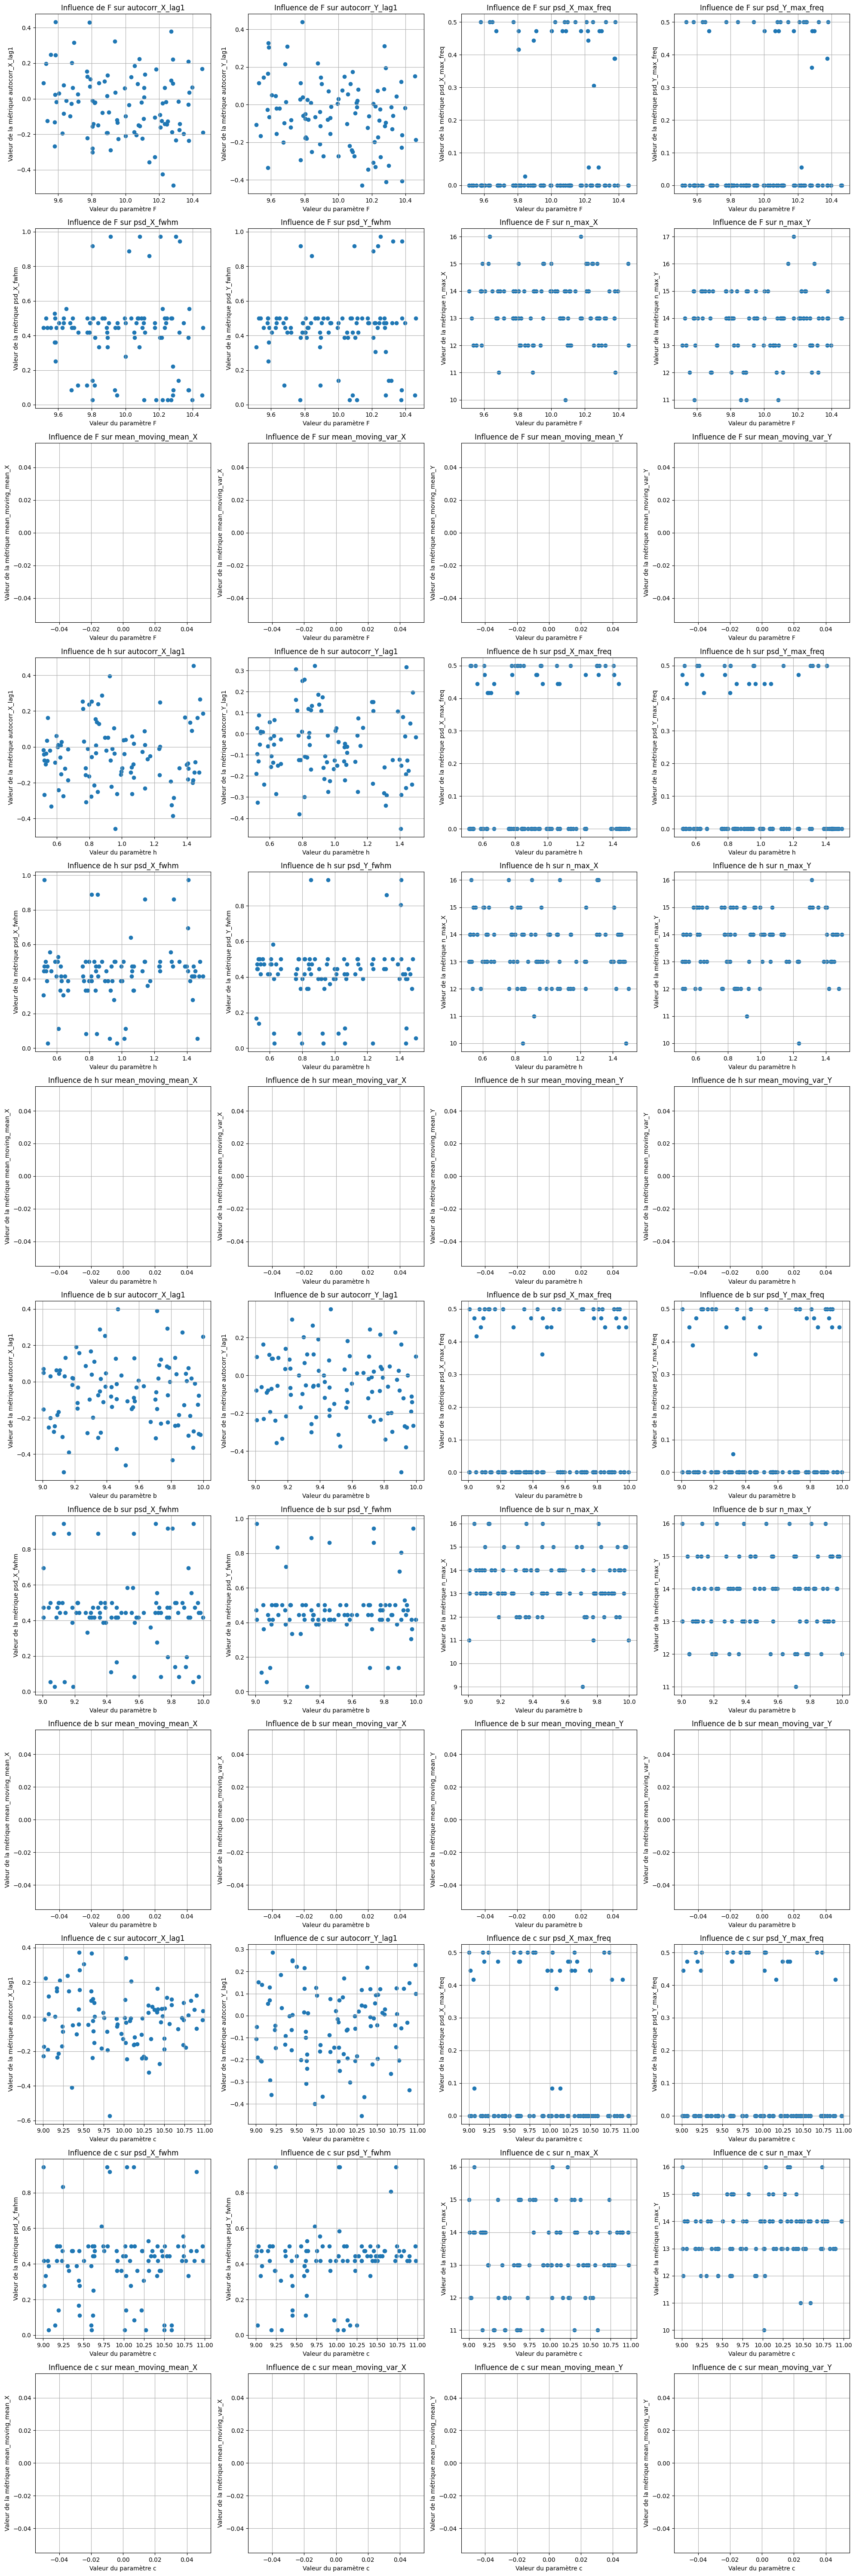

In [124]:

T = 10
dt = 0.01
n_samples = 100

    # Plot the influence of every parameters on every metric
plot_influence_all(priors, n_samples, T, dt)

# Utilisation des Métriques Basées sur les Quantiles et les Temps de Retour dans l'ABC Rejection

D'accord, je vais reformuler et détailler l'utilisation, l'interprétation et l'utilité des métriques basées sur les quantiles et les temps de retour dans le cadre de ton algorithme ABC Rejection.

## 1. Métriques de Distribution : Les Quantiles

### Définition Reformulée
Les quantiles sont des valeurs qui divisent une distribution ordonnée de données en parties égales, indiquant par exemple que 25% des valeurs sont en dessous du premier quartile, que 50% sont en dessous de la médiane, etc.

### Utilisation dans l'ABC

- **Calcul Pratique :** Pour chaque simulation de ton modèle Lorenz 96, tu vas :
  - Calculer la série temporelle de tes variables X et Y, ou bien calculer des métriques comme `X_mean`, `autocorr_X_lag1`, `psd_X_max_freq`, etc.
  - Sur ces données, tu calcules des quantiles (par exemple, les 10%, 25%, 50%, 75% et 90%) avec la fonction `np.quantile` de NumPy. Ces quantiles vont caractériser la distribution de tes données.

- **Fonction de Distance :**
  - Tu peux inclure ces quantiles directement dans la fonction de distance de ton algorithme ABC Rejection. Par exemple, tu peux faire la somme de la distance euclidienne entre tous les quantiles de données simulées et observées.
  - Il est aussi possible de créer de nouvelles métriques à partir des quantiles (écart interquartile, etc.), et d'utiliser ces métriques dans une fonction de distance.

- **Visualisation :**
  - Tu peux utiliser des histogrammes pour visualiser comment se distribuent les valeurs de tes métriques dans tes simulations. Tu peux aussi utiliser des boxplots pour comparer la distribution de tes quantiles, pour différents paramètres.

### Interprétation dans l'ABC Rejection

- **Robustesse aux valeurs extrêmes :** En utilisant les quantiles, ton algorithme ABC sera moins sensible aux valeurs aberrantes que si tu utilises des métriques basées sur la moyenne et la variance. Par exemple, si certaines simulations donnent des valeurs de X très grandes, les quantiles ne seront pas très affectés, contrairement à la moyenne ou à l'écart type.

- **Description de la forme des distributions :** Les quantiles te permettent d'étudier la distribution des données simulées, et pas seulement la valeur moyenne. Ils permettent de caractériser comment tes paramètres affectent non seulement la moyenne de la métrique, mais aussi la forme de sa distribution (l'étalement, l'asymétrie, les valeurs extrêmes, etc.).

- **Discrimination des paramètres :** Les quantiles peuvent être utiles pour discriminer entre différents paramètres, en révélant des relations plus complexes. Par exemple, le paramètre F pourrait avoir une influence plus importante sur le quantile à 90%, alors que le paramètre h a une influence plus forte sur le quantile à 25%. En utilisant plusieurs quantiles, tu peux mieux caractériser l'espace des paramètres.

- **Ajustement du seuil epsilon :** Le choix des quantiles aura un impact sur les valeurs de distance calculées dans l'algorithme ABC, ce qui signifie qu'il faudra que tu adaptes la valeur du seuil epsilon pour obtenir un nombre d'acceptations réaliste.

## 2. Métriques de Temps de Retour

### Définition Reformulée
Le temps de retour mesure l'intervalle de temps (ou le nombre d'itérations) qu'il faut au système pour "revenir" à un état proche d'un état de référence (qui peut être un état de départ ou un état caractéristique).

### Utilisation dans l'ABC

- **Définition de l'état de référence :** Choisis une métrique (par exemple, la moyenne de X, ou la valeur de `autocorr_X_lag1`), et définis une valeur de référence (par exemple, la moyenne des valeurs de `X_mean` observées). Tu peux aussi définir une valeur spécifique d'un paramètre si tu le souhaites.

- **Définition de la proximité :** Pour dire que le système est revenu à un état "proche" de l'état de référence, définis un intervalle autour de cette valeur de référence. Par exemple, "la valeur est à moins de 5% de la valeur de référence".

- **Calcul des temps de retour :** Pour chaque simulation, parcours la série temporelle de la métrique, et note tous les temps où la métrique sort de l'intervalle que tu as défini, et le temps nécessaire avant qu'elle y retourne.

- **Statistiques :** Calcule des statistiques sur ces temps de retour (par exemple, la moyenne et l'écart-type des temps de retour), et utilise ces valeurs comme métriques dans ta fonction de distance de l'algorithme ABC.

- **Visualisation :** Crée des histogrammes pour analyser la distribution des temps de retour, et compare comment ces distributions sont affectées par tes paramètres.

### Interprétation dans l'ABC Rejection

- **Dynamique des événements récurrents :** Ces métriques te permettent d'étudier la récurrence des événements dans ton système. Par exemple, tu peux étudier les paramètres qui influencent la durée des "pics" dans le système.

- **Sensibilité au chaos :** Si tu définis bien l'état de référence et la proximité, ces métriques peuvent te permettre de mettre en évidence comment tes paramètres agissent sur les caractéristiques chaotiques du système. On s'attend à ce que le temps de retour soit fortement variable dans un système chaotique.

- **Choix des paramètres :** En observant comment les temps de retour varient avec les paramètres, tu peux évaluer si certains paramètres sont plus importants que d'autres. Par exemple, si le temps de retour de `Y_mean` est très sensible à la valeur de c, cela indique que c est un paramètre qu'il faudra calibrer avec attention.

- **Choix du seuil epsilon :** Le choix de l'intervalle autour de l'état de référence influe sur la valeur des distances calculées par ton algorithme, et donc sur le seuil epsilon que tu dois utiliser.

## En résumé :

- **Quantiles :** Utilisés pour étudier la forme des distributions, en étant robustes aux valeurs extrêmes. Ils te permettent de mettre en évidence l'influence de certains paramètres sur les queues de distribution, et pas seulement sur les valeurs moyennes.

- **Temps de retour :** Utilisés pour caractériser les dynamiques récurrentes du système, et pour voir si certains paramètres ont une influence sur la fréquence des événements importants.



<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



# **VII/ Influence du pas de temps dt : Pour valider que tes résultats ne dépendent pas trop de la discrétisation temporelle du modèle.**



# **VIII/ Analyse de stabilité : Pour valider que ton algorithme ABC est robuste**

### influence du pas

1. **Objectif de l'Analyse**

   L'objectif principal est de déterminer comment le choix du pas de temps `dt` influence :

   - **La stabilité des simulations** : Pour un `dt` trop grand, la solution du modèle pourrait devenir instable et diverger.
   - **La précision des résultats** : Un `dt` trop grand pourrait introduire des erreurs numériques significatives.
   - **Les distributions a posteriori** : Comment le choix du `dt` affecte les distributions a posteriori des paramètres obtenus avec l'ABC.
   - **Les temps de calcul** : Un `dt` plus petit implique en général plus de calcul.
   - **Le compromis entre précision et temps de calcul** : Trouver le bon compromis entre ces aspects.

2. **Méthodologie**

   Voici les étapes à suivre pour étudier l'impact du pas de temps `dt` :

   - **Choisir une séquence de valeurs pour `dt`** :
     - Choisissez une gamme de valeurs pour `dt`, en commençant avec une valeur petite et en augmentant progressivement. Par exemple : 0.001, 0.005, 0.01, 0.02, 0.05, 0.1. Vous pouvez ajuster cette gamme en fonction de la dynamique du modèle L96.
     - Assurez-vous que les valeurs de `dt` choisies soient compatibles avec la période de simulation (`T`).

   - **Modifier la fonction `abc_rejection` pour accepter le `dt` comme paramètre** :
     - Modifiez la fonction `abc_rejection` pour qu'elle puisse accepter le `dt` comme paramètre et l'utiliser lors de l'appel à la fonction du modèle Lorenz 96.
     - Faites attention de définir un `T` (temps de simulation total) tel que `T/dt` soit un nombre entier.

   - **Réaliser l'ABC avec chaque valeur de `dt`** :
     - Pour chaque valeur de `dt`, exécutez l'algorithme ABC et sauvegardez les distributions a posteriori obtenues, les temps de calcul, et une métrique de la stabilité de la simulation (par exemple, est-ce que la simulation a divergé).
     - Utilisez un nombre de simulations `n_simulations` fixe, que vous avez validé avec l'analyse précédente.
     - Vous pouvez utiliser un epsilon fixe, mais si vous souhaitez explorer l'impact de `dt` sur les résultats pour différents epsilon, alors vous pouvez aussi changer epsilon.

   - **Analyser les résultats** :
     - **Stabilité des simulations** : Vérifiez la stabilité des simulations pour chaque valeur de `dt`. Si le modèle diverge, cela peut être un signe que la valeur de `dt` est trop grande. Tracez le nombre de simulations divergentes en fonction du `dt`.
     - **Comparaison des distributions a posteriori** : Comparez les distributions a posteriori obtenues pour différentes valeurs de `dt`, de la même manière que pour l'étude du nombre de simulations (visualisations des distributions, distances de Wasserstein, statistiques).
     - **Temps de calcul** : Tracez le temps de calcul en fonction du pas de temps.
     - **Influence sur le taux d'acceptation** : Calculez le taux d'acceptation des paramètres pour chaque valeur de `dt`.
     - **Compromis entre précision et temps de calcul** : Déterminez un `dt` qui offre une bonne précision des résultats sans engendrer un temps de calcul trop important.

In [ ]:
def analyze_time_step(priors, metrics_obs, epsilon, dt_values, ref_value_dict, T = 10, n_simulations = 1000):
    """
    Analyse l'effet du pas de temps sur les distributions a posteriori, le temps de calcul et la stabilité.
    """

    results = []
    for dt in dt_values:
        start_time = time.time()
        accepted_thetas, n_diverged_sim = abc_rejection(priors, metrics_obs, n_simulations, epsilon, T=T, dt = dt)
        end_time = time.time()
        time_elapsed = end_time - start_time
        results.append((dt, accepted_thetas, time_elapsed, n_diverged_sim))
    # Analyse de la convergence et de la precision
    for param_name in priors.keys():
        
        
        distributions_for_param = []
        for dt, accepted_thetas, _,_ in results :
            values = [theta[param_name] for theta in accepted_thetas]
            distributions_for_param.append(values)

        wasserstein_distances = []
        mean_values = []
        std_values = []

        for i in range(len(distributions_for_param)):
             mean_values.append(np.mean(distributions_for_param[i]))
             std_values.append(np.std(distributions_for_param[i]))

        for i in range(1,len(distributions_for_param)):
            wasserstein_distances.append(wasserstein_distance(distributions_for_param[i], distributions_for_param[0]))


        # Visualisation
        plt.figure(figsize=(10, 6))
        plt.plot(dt_values[1:], wasserstein_distances, marker='o')
        plt.title(f"Convergence des distributions pour {param_name} (Distance de Wasserstein)")
        plt.xlabel("pas de temps (dt)")
        plt.ylabel("Distance de Wasserstein par rapport a dt = " + str(dt_values[0]))
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(dt_values, mean_values, marker='o', label = 'moyenne')
        plt.plot(dt_values, std_values, marker='x', label = 'ecart-type')
        plt.title(f"Statistiques des distributions pour {param_name} ")
        plt.xlabel("pas de temps (dt)")
        plt.ylabel("Statistiques")
        plt.grid(True)
        plt.legend()
        plt.show()
    
    # Visualisation du temps de calcul
    times = [t for _, _, t, _ in results]
    plt.figure(figsize=(10, 6))
    plt.plot(dt_values, times, marker='o')
    plt.title("Temps de calcul en fonction du pas de temps dt")
    plt.xlabel("pas de temps (dt)")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid(True)
    plt.show()

    #Visualisation de la stabilité
    n_diverged_sim_values = [n_diverged_sim for _, _, _, n_diverged_sim in results]
    plt.figure(figsize=(10, 6))
    plt.plot(dt_values, n_diverged_sim_values, marker='o')
    plt.title("Nombre de simulations divergentes en fonction du pas de temps dt")
    plt.xlabel("pas de temps (dt)")
    plt.ylabel("Nombre de simulations divergentes")
    plt.grid(True)
    plt.show()

    #Tracer les densites pour chaque pas de temps
    for index, (dt, accepted_thetas, _, _) in enumerate(results) :
        plot_density_distributions(priors, accepted_thetas, ref_value_dict, dt = dt )


    return results



In [ ]:
# --- Initialisation pour l'exemple ---

epsilon = 0.5
dt_values = [0.001, 0.005, 0.01, 0.02, 0.05]  # Pas de temps à tester

T = 10 #temps de simulation total

# --- Lancer l'analyse ---
results = analyze_time_step(priors, metrics_obs, epsilon, dt_values, theta_ref, T = T)

<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [ ]:
# Copyright 2025 ensai
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



In [139]:
# Copyright 2025 ensai
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     https://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



<!--
 Copyright 2025 ensai
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     https://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->



# Approfondissement de la Méthode ABC Rejet


## Choix des Statistiques Résumées S(x)

### Pertinence
Explore différentes statistiques résumées (au-delà de la moyenne et de la variance). Justifie ton choix (avec des arguments théoriques si possible) en mettant en relation les statistiques avec les caractéristiques spécifiques du modèle de Lorenz-96.

### Impact sur l'Inférence
Comment le choix de différentes statistiques résumées influence les distributions a posteriori et la qualité de l'estimation ?

### Suffisance
Si tu utilises des statistiques non suffisantes, essaie de quantifier la perte d'information.

## Choix de la Distance

### Comparaison de Métriques
Compare l'utilisation de la distance euclidienne avec d'autres métriques courantes, comme la distance de Manhattan ou une distance basée sur les corrélations. Justifie ton choix de métrique ou explique les avantages et les inconvénients de différentes métriques.

### Impact sur la distribution a posteriori
Analysez l'impact du choix de la métrique sur les distributions a posteriori obtenues.

## Analyse de Sensibilité des Paramètres

### Impact des Paramètres
Étudie l'impact individuel de chaque paramètre (F, h, b, c) sur les résultats de la simulation. Une analyse de sensibilité peut aider à comprendre quels paramètres sont les plus critiques pour le modèle.

### Corrélations
Analysez les corrélations entre les différents paramètres estimés. Cela peut donner un aperçu des interactions et des dépendances entre les paramètres.

## Choix de la Loi a Priori

### Influence de la loi a priori
Analysez l'impact du choix de la loi a priori sur les distributions a posteriori. Testez différentes distributions a priori (uniforme, normale, etc.) et justifiez vos choix.

### Sensibilité
Effectuez une analyse de sensibilité pour évaluer comment le choix de l'a priori influence les résultats obtenus, en particulier lorsque les données observées sont limitées.

## Analyse Critique de la Méthode ABC Rejet

### Limites de l'ABC Rejet
Discutez des limitations inhérentes à la méthode ABC Rejet : coût computationnel élevé, sensibilité au choix de la métrique et du seuil, etc.

### Comparaison avec d'autres méthodes
Si le temps et les ressources le permettent, comparez la performance de la méthode ABC-Rejet avec d'autres méthodes d'estimation de paramètres (MCMC, ou ABC-SMC par exemple).

### Pistes d'Amélioration
Quelles sont les pistes d'amélioration possibles pour pallier ces limites dans ton contexte spécifique ?

## Analyse Spécifique au Modèle de Lorenz-96

### Analyse Qualitative des Simulations
Visualise et analyse les comportements des simulations du modèle de Lorenz-96. Les simulations présentent-elles des caractéristiques chaotiques, des oscillations, des transitions brusques, etc. ?

### Sensibilité aux Paramètres
Comment les différents paramètres du modèle de Lorenz-96 (F, h, b, c) influencent les comportements observés ?

### Lien entre le modèle et les données observées
Est-ce que les simulations sont qualitativement proches des données observées (même avec le bruit) ?

## Analyse des Incertitudes

### Incertitudes sur les paramètres
Calcule les incertitudes sur les paramètres en utilisant la distribution a posteriori.

### Impact des Incertitudes
Comment ces incertitudes se propagent-elles à la compréhension de la dynamique du modèle ?

## Aspects Computationnels

### Optimisation du Code

#### Vectorisation
As-tu exploré l'utilisation de fonctions vectorisées de Numpy pour accélérer tes simulations ?

#### Parallélisation
As-tu envisagé la parallélisation pour accélérer le processus d'échantillonnage et de simulations ?

### Scalabilité

#### Impact de la dimension des données
Étudiez l'impact de l'augmentation de la dimension des données sur les performances de l'algorithme.

#### Modèles plus complexes
Comment le code pourrait-il être adapté à des modèles plus complexes que le modèle de Lorenz-96 (par exemple en augmentant le nombre d'échelles) ?

## Réflexion et Originalité

### Analyse Critique
Sois critique vis-à-vis de ton travail. As-tu rencontré des difficultés lors de l'implémentation ou de l'analyse ? Quelles sont les limites de ta méthodologie ?

### Ouverture et Originalité
Propose des pistes pour des études futures basées sur ton travail. As-tu des idées pour améliorer la méthode ABC rejet ou pour l'appliquer à d'autres problèmes ?

## Comment Intégrer ces Points dans ton PFE

### Priorisation
Tu n'as pas forcément le temps de tout traiter en détail. Choisis les aspects qui te semblent les plus importants et les plus pertinents pour ton PFE.

### Réalisme
Sois réaliste sur ce que tu peux accomplir dans le temps imparti. N'hésite pas à mentionner des limitations et des pistes d'amélioration si tu n'as pas pu tout explorer.

### Argumentation
Tout au long de ton travail, justifie clairement tes choix, tes méthodes et tes résultats. Montre que tu as bien compris les concepts sous-jacents et que tu sais faire preuve d'esprit critique.

## Conclusion
En résumé, pour faire un PFE digne d'un chercheur :
- Ne te contente pas d'appliquer : Fais une véritable exploration des paramètres, des méthodes et des modèles.
- Sois critique et justifie : Ne te contente pas d'utiliser une formule par défaut. Explique tes choix et mentionne les limitations.
- Montre de la rigueur : Soigne l'implémentation, la visualisation et l'analyse des résultats.
- Développe une pensée originale : Va au-delà de la description et propose de nouvelles pistes de réflexion et d'amélioration.

J'espère que cette liste t'aidera à affiner ton travail. N'hésite pas à me solliciter si tu as d'autres questions. Bon courage !


1. **Analyses Approfondies de l'ABC Rejection**

   - **Analyse de la sensibilité à la fonction de distance :**
     - Différentes distances : Explorez différentes fonctions de distance pour l'ABC (par exemple, distance euclidienne, distance de Manhattan, etc.).
     - Pondération des métriques : Étudiez l'impact de la pondération des différentes métriques que vous utilisez pour calculer la distance. Cela permet de donner plus ou moins d'importance à certaines métriques.
     - Impact sur les distributions a posteriori : Comparez comment les distributions a posteriori des paramètres changent en fonction de la fonction de distance utilisée.


   - **Analyse des paramètres non identifiables :**
     - Problème d'identifiabilité : Les paramètres dans les modèles climatiques ne sont pas tous identifiables, i.e., il existe différents ensembles de paramètres qui donnent des résultats similaires. Cherchez s'il y a des paramètres dans le modèle qui sont non identifiables par l'ABC.
     - Impact sur l'incertitude : Discutez de l'impact de la non-identifiabilité des paramètres sur les incertitudes des projections.

   - **Analyse du temps de calcul :**
     - Profilage du code : Utilisez des outils de profilage pour identifier les parties du code les plus consommatrices en temps.
     - Optimisation : Optimisez votre code si nécessaire pour améliorer les temps de calcul.


2. **Améliorations des Méthodes ABC**

   - **ABC avec noyau :** Vous pouvez explorer l'utilisation de noyaux pour pondérer les simulations dans l'ABC. Cela peut permettre de lisser les distributions a posteriori et d'obtenir des résultats plus stables.

   - **Utilisation de Statistiques Sommaires Plus Informatifs :**
     - Choix de bonnes métriques : Si votre métrique est peu informative, vous pouvez choisir des métriques qui permettent de mieux discriminer les différents paramètres.
     - Visualisation : Visualisez vos métriques afin de vérifier qu'elles sont suffisamment informatives.
     - Utilisation de données synthétiques : Si vous connaissez la valeur des paramètres à calibrer, vous pouvez créer des données d'observations synthétiques en utilisant ces paramètres, puis les comparer avec les valeurs a posteriori.

3. **Analyse de Sensibilité**

   - **Analyse de sensibilité locale (avec des dérivées) :**
     - Calcul des dérivés : Calculez analytiquement ou numériquement les dérivés des sorties par rapport aux paramètres du modèle, afin de voir comment les sorties varient en fonction des paramètres.

   - **Analyse de sensibilité globale :**
     - Méthode de Sobol : Étudiez l'impact de chaque paramètre sur les sorties du modèle en utilisant la méthode de Sobol. Cela vous permettra d'identifier les paramètres les plus importants.
     - Méthode de Morris : Effectuez une analyse de sensibilité de Morris, qui est moins coûteuse que celle de Sobol.
     - Interprétation physique : Reliez vos résultats d'analyse de sensibilité avec les processus physiques dans le modèle.

4. **Visualisation et Interprétation**

   - Diagrammes en nuage de points : Utilisez des diagrammes en nuage de points pour visualiser les corrélations entre les paramètres.
   - Graphiques de convergence : Si vous utilisez des algorithmes MCMC, montrez les graphiques de convergence des chaînes pour vérifier si l'échantillonnage est stable.
   - Analyse des bornes : Analysez l'impact des bornes des paramètres que vous avez définis sur les résultats.

5. **Comparaison avec d'Autres Méthodes d'Inférence**

   - Inférence par MCMC : Comparez vos résultats avec ceux obtenus en utilisant un algorithme MCMC classique (par exemple, Metropolis-Hastings). Cela permettra de valider les résultats obtenus avec ABC.
   - Approximation Variationnelle : Comparez vos résultats avec une inférence variationnelle (si elle est faisable).
   - Comparaison avec d'autres méthodes de calibration : Comparez vos résultats avec une méthode de calibration qui n'est pas bayésienne.

6. **Aspects Mathématiques**

   - Analyse mathématique de votre modèle : Analysez les propriétés mathématiques de votre modèle afin d'identifier les paramètres influents.

**Conseils pour rendre l'étude pertinente :**

- Mise en évidence des compromis : Mettez en évidence les compromis entre la précision des estimations, le temps de calcul, et le choix des méthodes.
- Discussion des limitations : Discutez des limitations de votre approche et proposez des pistes d'amélioration pour le futur.
- Interprétation physique : Essayez de donner une interprétation physique à vos résultats, même si vous travaillez avec un modèle simplifié.

